# House Pricing

## Preporations

### Import Libraries and download dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Preprocessing
import pandas as pd
import numpy as np
import pandas_profiling as pp
import missingno as msno #library for work with NaN values
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import f_classif, mutual_info_classif

import datetime
from datetime import datetime

In [3]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pprint

# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

from scipy import stats
from scipy.stats import skew, norm


#plt.style.use('seaborn')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 100
pd.set_option('max_columns', None)
%matplotlib inline

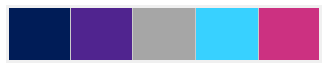

In [4]:
# Set project colors
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

In [5]:
# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor


from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, StackingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer

from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline


import catboost
from catboost import CatBoostRegressor

import optuna
from functools import partial

In [6]:
# classtering

from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

### Functions

In [7]:
def missing_vars(data, col='education', random_proba=True):
    '''Function is called for filling of missing data'''
    # With using probability and random choise

    if random_proba:
        col_name = data[col].value_counts().index.to_list(
        )  # get list of values
        col_distr = data[col].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name
        data.loc[missing, [col]] = np.random.choice(col_name,
                                                    size=len(data[missing]),
                                                    p=col_distr)

    # Using  most common in  column
    data[col] = data[col].fillna(data[col].value_counts().index[0])

In [8]:
def get_boxplot(data, col1, col2, hue=None, title=None):
    '''Function is called to plot boxplots'''
    title = title if title is not None else f"Distribution for '{col1, col2}"
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(x=col1, y=col2, hue=hue, data=data, palette=colors, ax=ax)
    plt.style.use('seaborn')
    plt.show()

In [9]:
def get_num_info(col, title=None, target=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5),)
    
    sns.distplot(col.values, bins=20, ax=ax1, fit=norm) 
    
    fig = sm.qqplot(col, fit=False, line='45', ax=ax2)
    fig.suptitle(title, fontsize=20)
    
    ax3.boxplot(col.values,vert = False)
    
    ax4.scatter(x = col.values, y = target)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Boxplot')
    ax4.set_title('Scatter')
    
    plt.show()

In [10]:
def get_num_info_2(col, title=None):
    '''Function is called to plot feture distribution'''

    title = title if title is not None else f"Distribution for '{col}"
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5),)
    fig = sm.qqplot(col, fit=False, line='45', ax=ax1)
    fig.suptitle(title, fontsize=20)

    sns.distplot(col.values, bins=20, color=colors[1], ax=ax2, fit=norm)
    sns.violinplot(col.values, color=colors[3], bw=.3, cut=1, linewidth=4)

    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')

    plt.show()

In [11]:
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1, q3 = np.percentile(sorted(data), [25, 75])

    IQR = q3 - q1

    l_b = q1 - (1.5 * IQR) # lower bound
    u_b = q3 + (1.5 * IQR) # upper bound
    outl_count = len(data[data < l_b]) + len(data[data > u_b])

    print(
        f'Lower Bound: {round(l_b,3)}, Upper Bound {round(u_b,3)}, Outliers Count: {outl_count}')

In [12]:
def get_metrics_regression(y_test, y_pred):
    print('Accuracy = %0.4f' % mean_squared_error(y_test,y_pred) 
          + '\nPrecision = %0.4f' % mean_absolute_error(y_test,y_pred)
          + '\nReacall = %0.4f' % mean_absolute_percentage_error(y_test,y_pred)
          + '\nF1_score = %0.4f' % r2_score(y_test,y_pred))

In [13]:
def NullClearner(df):
    if(isinstance(df, pd.Series) and (df.dtype in ["float64","int64"])):
        df.fillna(df.mean(),inplace=True)
        return df
    elif(isinstance(df, pd.Series)):
        df.fillna(df.mode()[0],inplace=True)
        return df
    else:return df
    
def EncodeX(df):
    return pd.get_dummies(df)

In [14]:
'''Function that returns the ordinal day of the year'''
def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day

'''A function that returns the number of days between the order date and today's date'''
def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    
'''Function that returns the flag of filing an application on a weekend'''
def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0
    
'''Function that returns month'''
def month(x):
    month = x.month
    return month

'''A function that returns the number of years between the order year and today's year'''
def get_years_beetwen(x):
    curr_date = datetime.today().year
    count = (curr_date-x)
    return count

In [15]:
def type_separator(df):
    
    ''' 
    Divides DF into 3 arrays by dtype(object, int64, float64) 
    '''   
    
    cat = list(df.select_dtypes(include=['object']).columns)
    nums = list(df.select_dtypes(exclude=['object']).columns)
    
    if df.shape[1] == len(cat + nums):
        return cat, nums   
    else: print('DataFrame have another type(not int, float, object)')

In [16]:
def get_nan(df):
    miss_features = df.isnull().sum().sort_values(ascending=False)
    return miss_features[miss_features > 0]

In [17]:
def NoneFillner(df, l):
    for feature in l:
        if(isinstance(df[feature], pd.Series)):
            df[feature].fillna('None',inplace=True)
    return df[l].isnull().sum().sort_values(ascending=False)

In [18]:
def get_uniq_values(df):
    return pd.DataFrame(df.apply(pd.unique)).rename(columns={0:'Unique values'})

## Dataset preproration

### Downloading

In [138]:
# Download dataset
df_train = pd.read_csv('/home/mark/Documents/GitHub/Datasets/HousePrices/train.csv')
df_test = pd.read_csv('/home/mark/Documents/GitHub/Datasets/HousePrices/test.csv')
df_ss = pd.read_csv('/home/mark/Documents/GitHub/Datasets/HousePrices/sample_submission.csv')

In [139]:
target = df_train['SalePrice']

In [140]:
# Merge train and test
df = pd.concat([df_train, df_test], axis=0)

# Drop useless 'ID'
df = df.reset_index()
df.drop(['Id', 'index'], axis=1, inplace=True)

# Создадим для удобства новую переменную, чтобы отличать тест и трейн выборки
df['train'] = df['SalePrice'].apply(lambda x: 1 if x>0 else 0)

In [141]:
# Попытка заполнить целевую переменную предсказанными ранее значениями

saleprice = pd.read_csv('/home/mark/Documents/GitHub/ds_bootcamp/learning/00_Projects/Project_2/SalePrice.csv').drop('Id', axis=1, inplace=False)
df['SalePrice'] = saleprice

### Profiling

In [23]:
df_profile = df.profile_report()

**[Profile Report - Link](./result1.html)**

### Get Type Features

In [24]:
cat, nums= type_separator(df)

In [25]:
pprint.pprint([cat, nums], compact=True, indent=1, width=80)

[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
  'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
  'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
  'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
  'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
  'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
  'SaleCondition'],
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
  'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
  'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
  'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
  'GarageCars', 'GarageArea', 'WoodDe

### Work with miss/NaN values

Посмотрим на признаки в которых есть пропуски

In [142]:
get_nan(df)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageQual       159
GarageYrBlt      159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtFullBath       2
BsmtHalfBath       2
BsmtUnfSF          1
BsmtFinSF2         1
TotalBsmtSF        1
Electrical         1
BsmtFinSF1         1
KitchenQual        1
GarageCars         1
Exterior2nd        1
Exterior1st        1
SaleType           1
GarageArea         1
dtype: int64

In [143]:
# Определим переменные в которых пропуск не является пропуском, а отдельной категорией

None_values = ['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'FireplaceQu', 'GarageCond', 
               'GarageFinish', 'GarageQual', 'GarageType', 
              'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']

# Заполним значением "None"
NoneFillner(df, None_values)

# У категориальных переменных заполним пропуски самым частоповторяемым значением
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

# У данных переменных более правильным будет заполнить именно этими значениями, т.к. иначе заполнится неверным значением
df['Functional'] = df['Functional'].fillna('Typ') 
df['Electrical'] = df['Electrical'].fillna("SBrkr") 
df['KitchenQual'] = df['KitchenQual'].fillna("TA") 

# Заполняем 0 численные переменные у которых данные удобства отсутствуют в доме
for col in ('GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)  
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

# Оставшиеся численные переменные заполняем медианой
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())

In [145]:
# Посмотрим на признаки в которых есть пропуски снова
get_nan(df)

MiscFeature    2814
Utilities         2
dtype: int64

## Data Analysys

### Анализ числовых данных

#### Первичное построение графиков

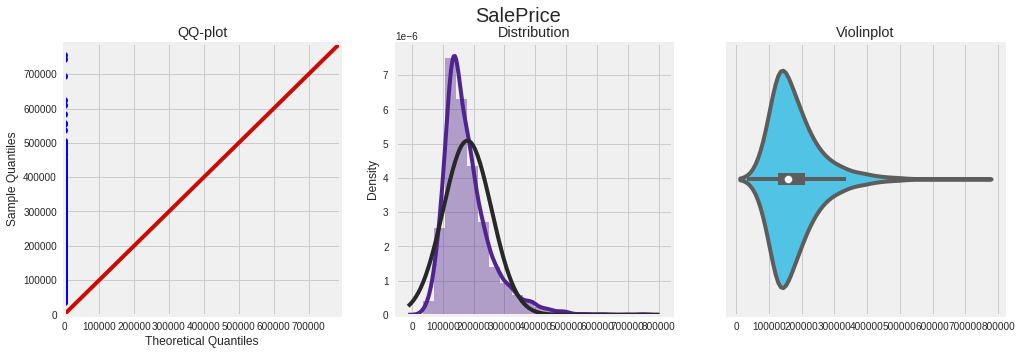

Lower Bound: 3250.0, Upper Bound 337250.0, Outliers Count: 135


In [394]:
get_num_info_2(df['SalePrice'], title='SalePrice')
detect_outliers(df['SalePrice'])

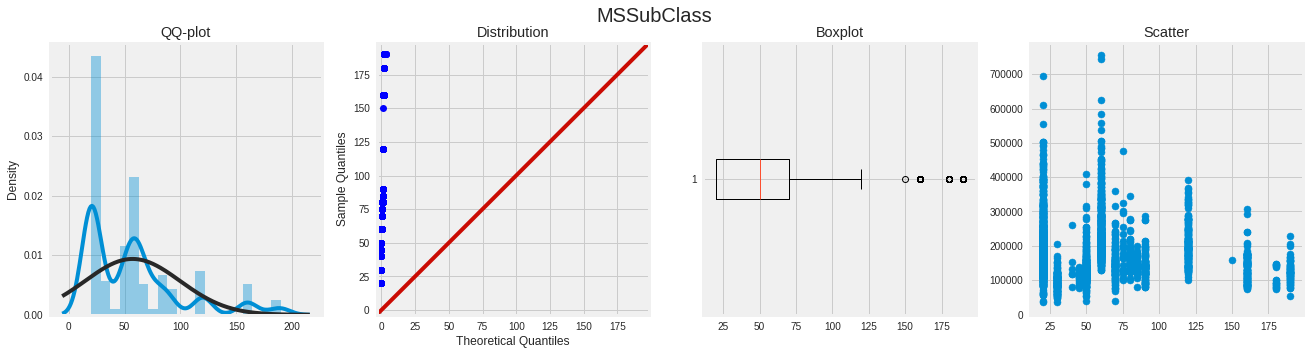

Lower Bound: -55.0, Upper Bound 145.0, Outliers Count: 207


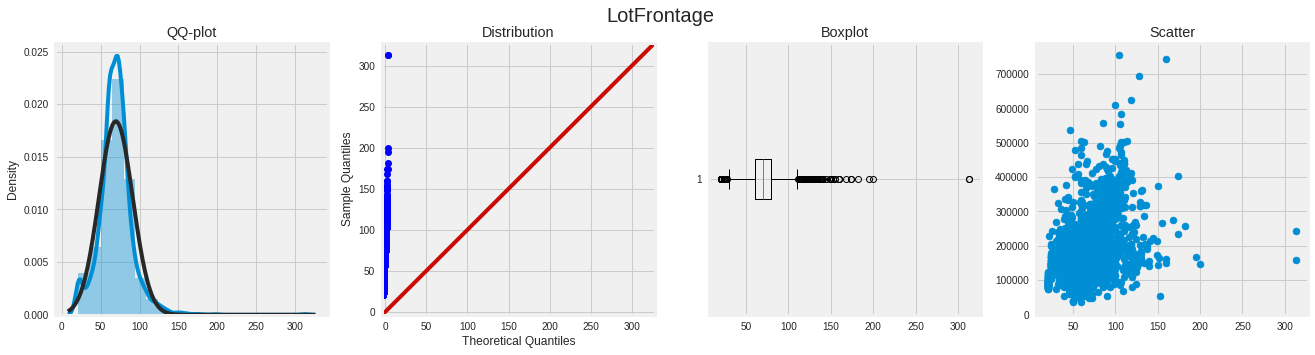

Lower Bound: 30.0, Upper Bound 110.0, Outliers Count: 206


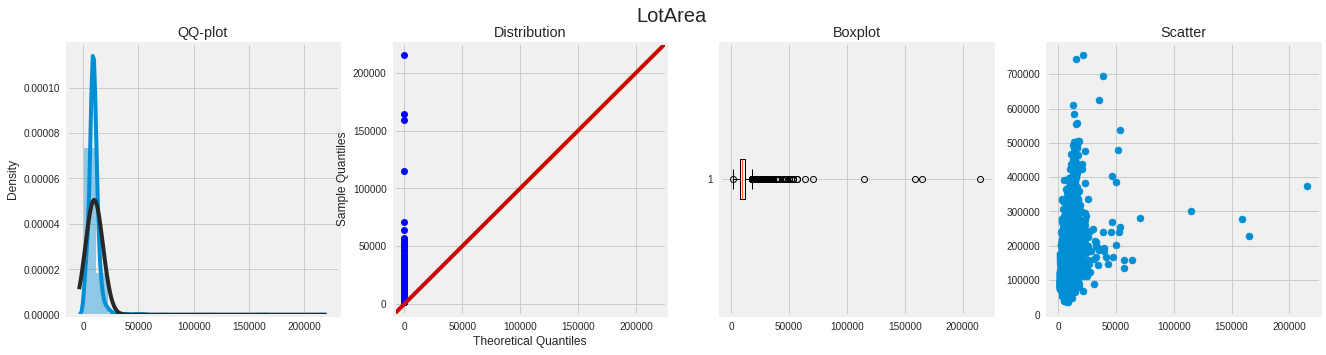

Lower Bound: 1340.0, Upper Bound 17708.0, Outliers Count: 128


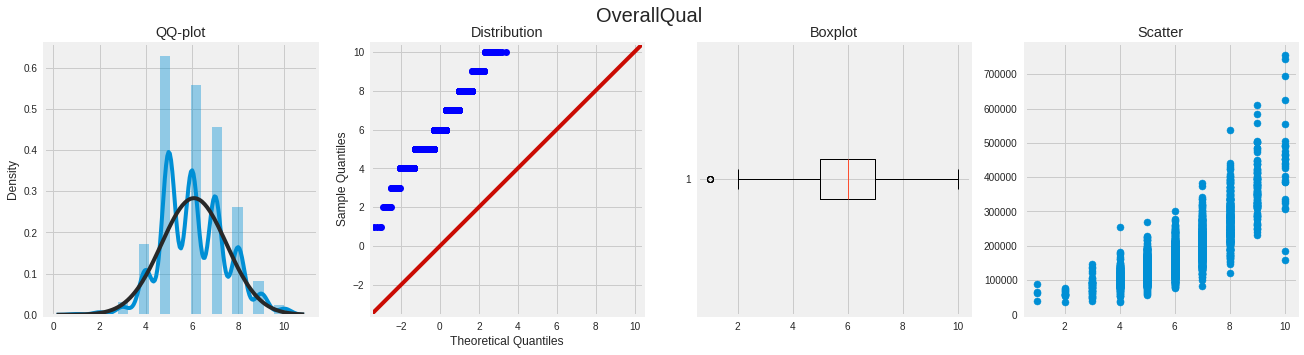

Lower Bound: 2.0, Upper Bound 10.0, Outliers Count: 4


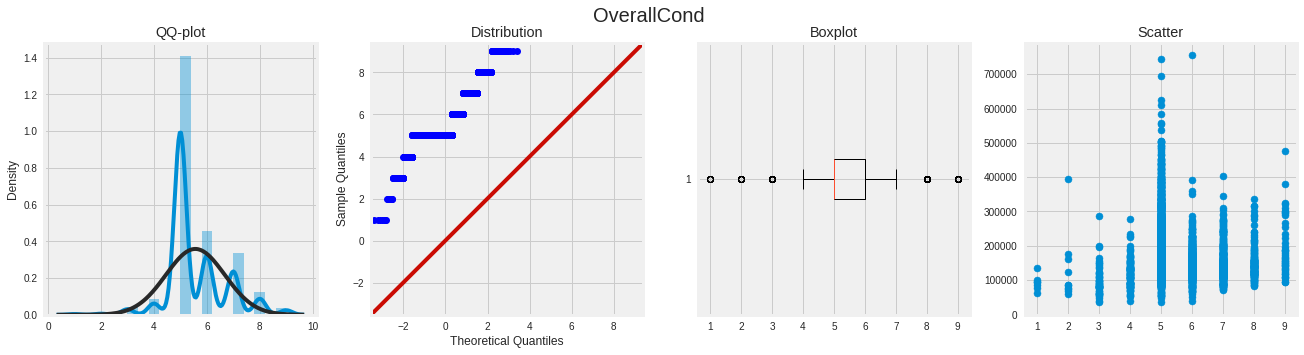

Lower Bound: 3.5, Upper Bound 7.5, Outliers Count: 252


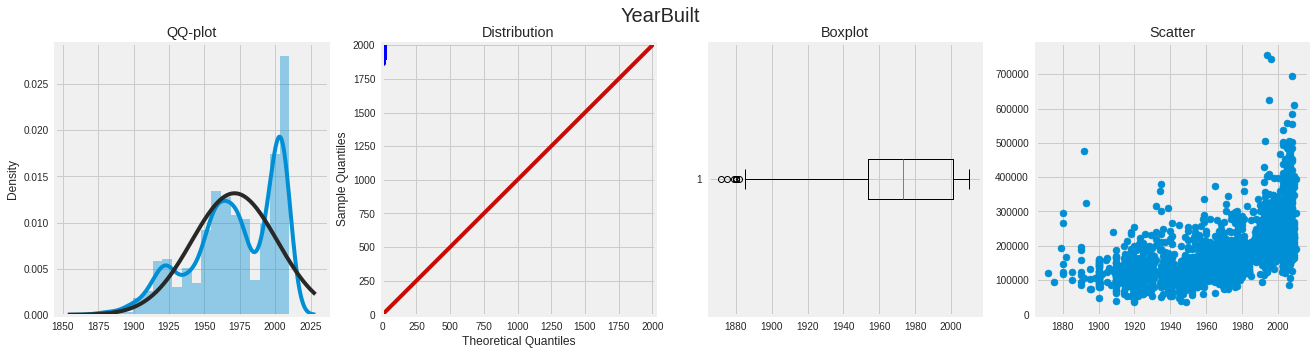

Lower Bound: 1882.25, Upper Bound 2072.25, Outliers Count: 9


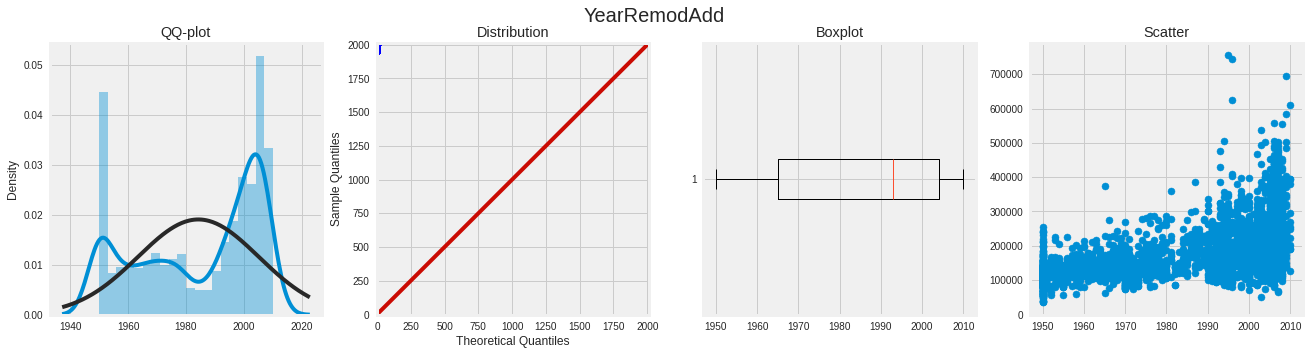

Lower Bound: 1906.5, Upper Bound 2062.5, Outliers Count: 0


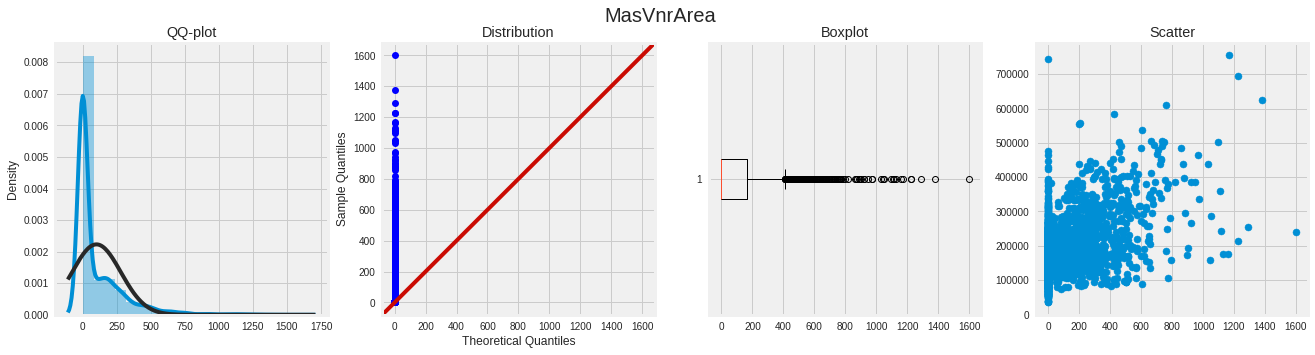

Lower Bound: -245.25, Upper Bound 408.75, Outliers Count: 202


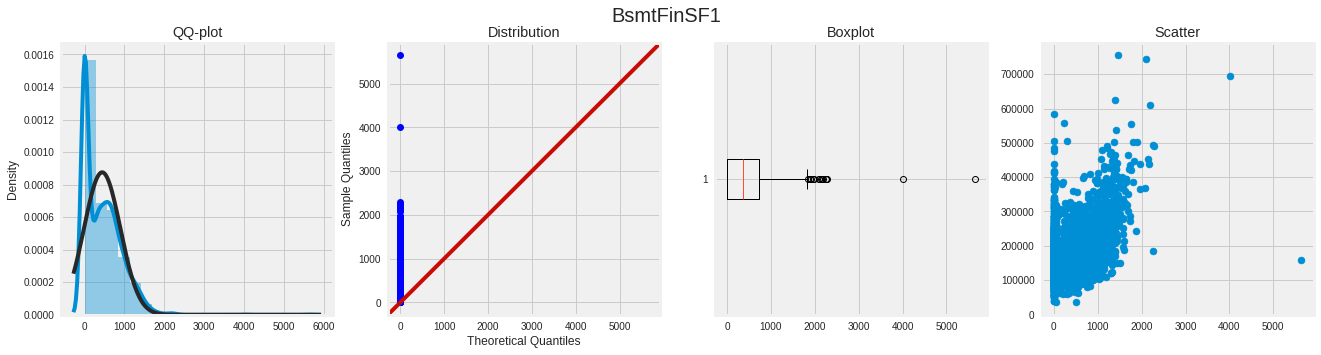

Lower Bound: -1099.5, Upper Bound 1832.5, Outliers Count: 15


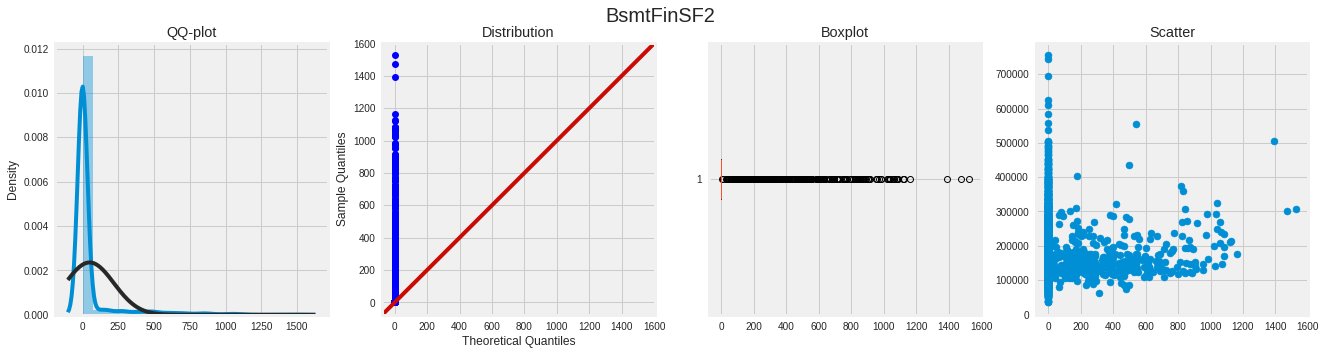

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 347


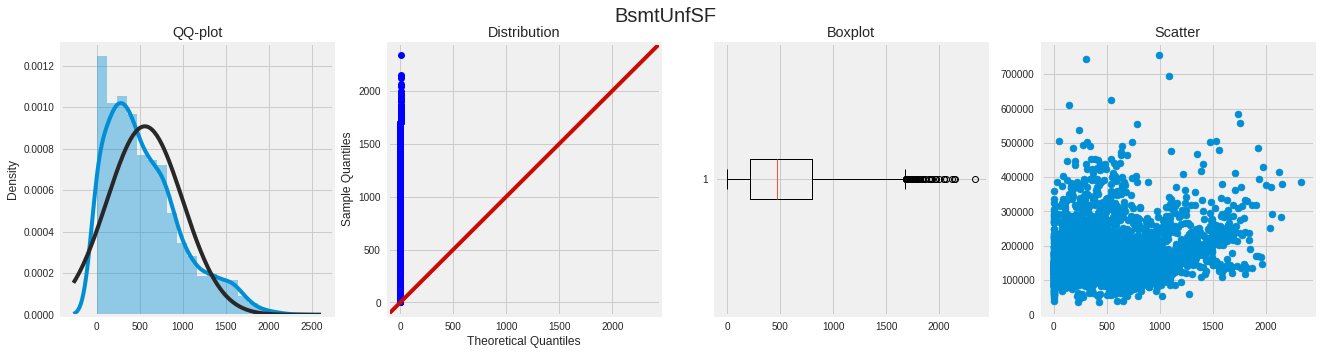

Lower Bound: -657.5, Upper Bound 1682.5, Outliers Count: 53


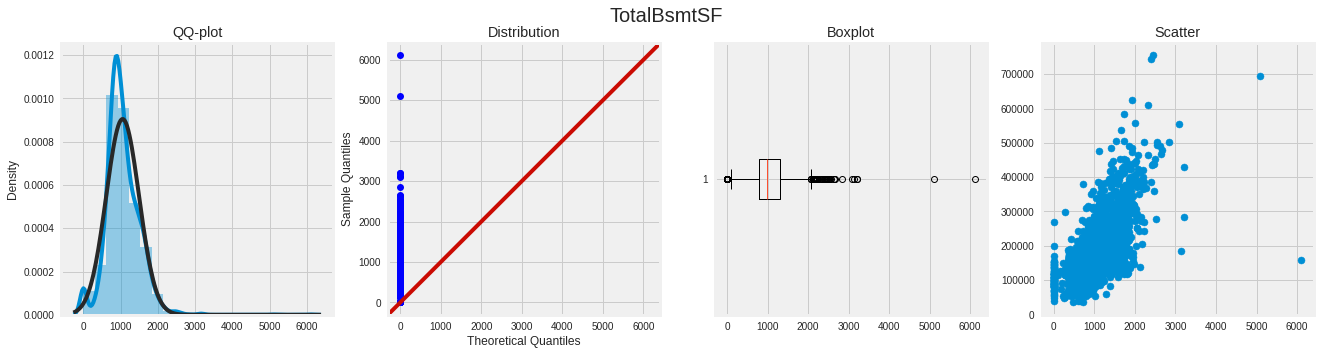

Lower Bound: 29.5, Upper Bound 2065.5, Outliers Count: 123


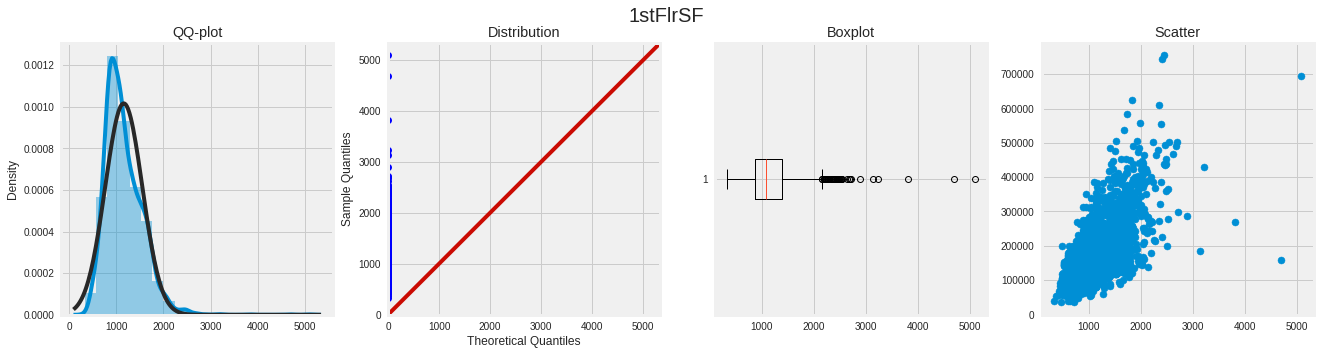

Lower Bound: 108.75, Upper Bound 2154.75, Outliers Count: 42


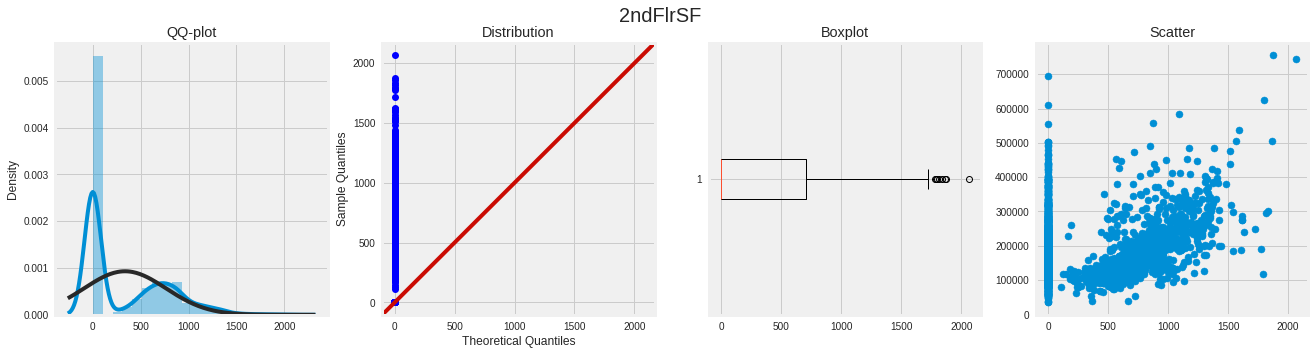

Lower Bound: -1056.0, Upper Bound 1760.0, Outliers Count: 8


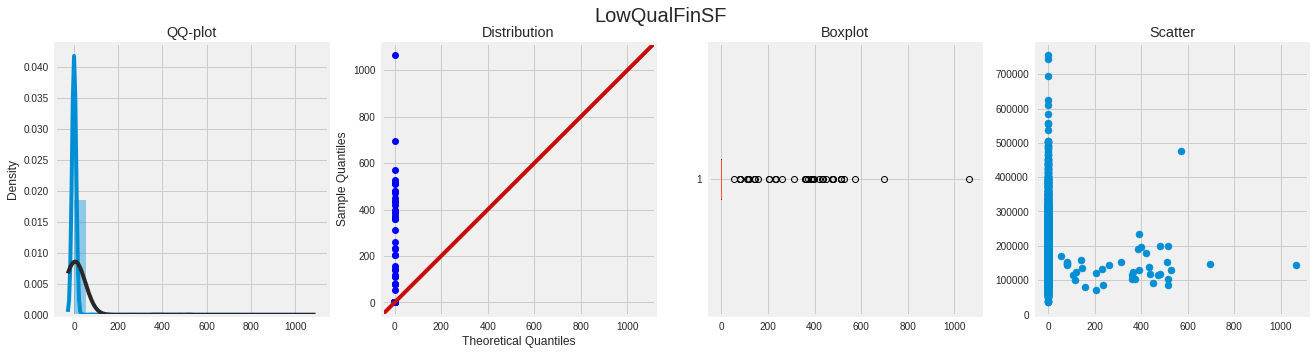

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 40


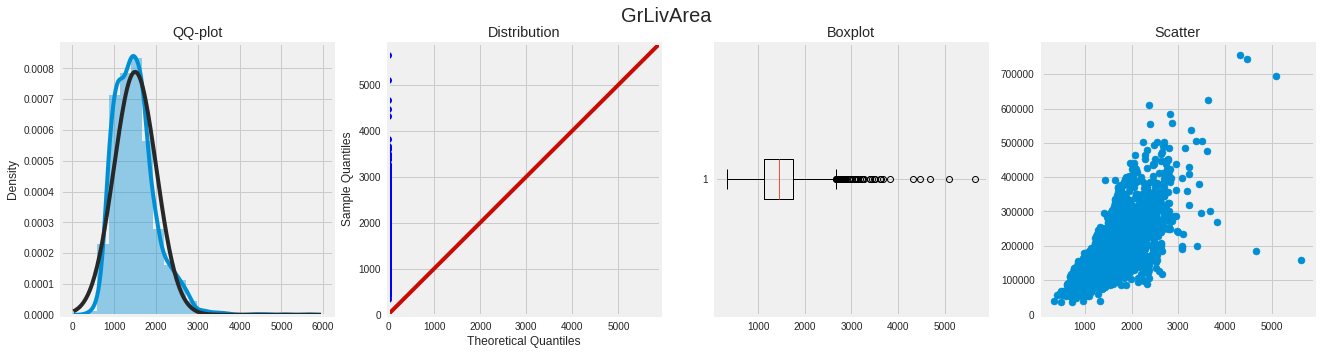

Lower Bound: 199.75, Upper Bound 2669.75, Outliers Count: 74


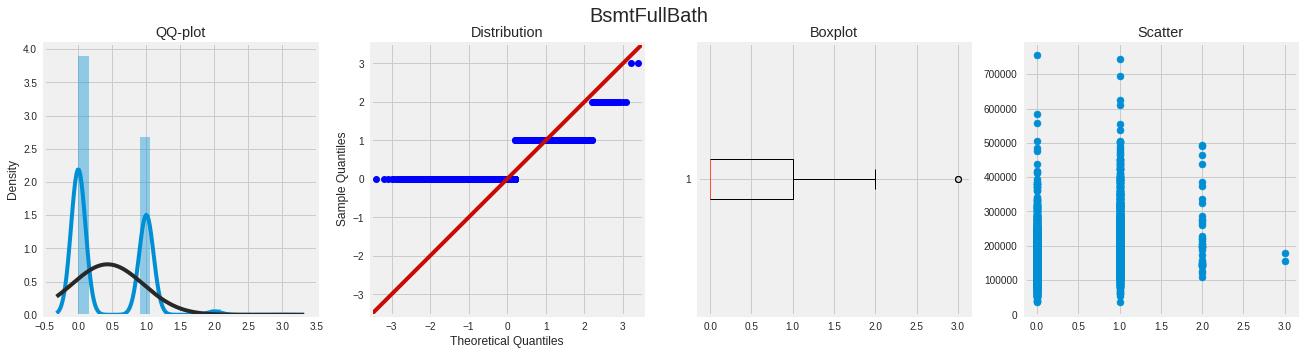

Lower Bound: -1.5, Upper Bound 2.5, Outliers Count: 2


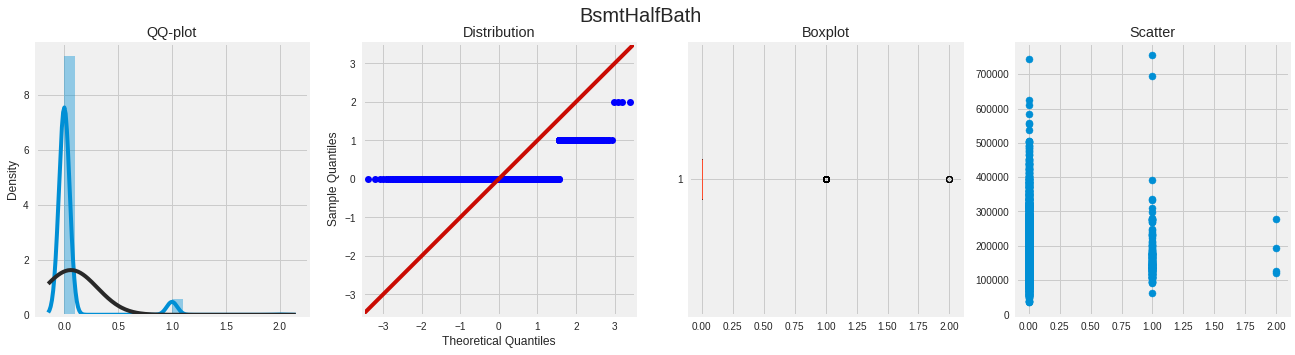

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 175


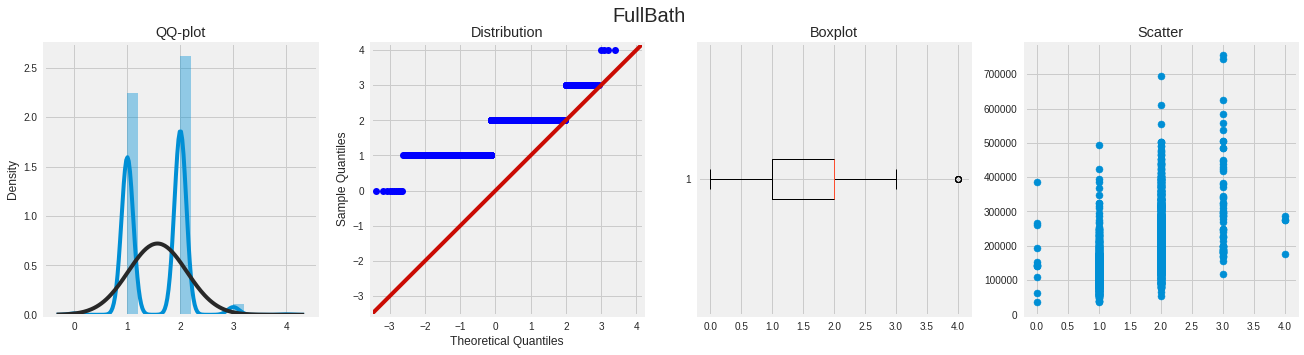

Lower Bound: -0.5, Upper Bound 3.5, Outliers Count: 4


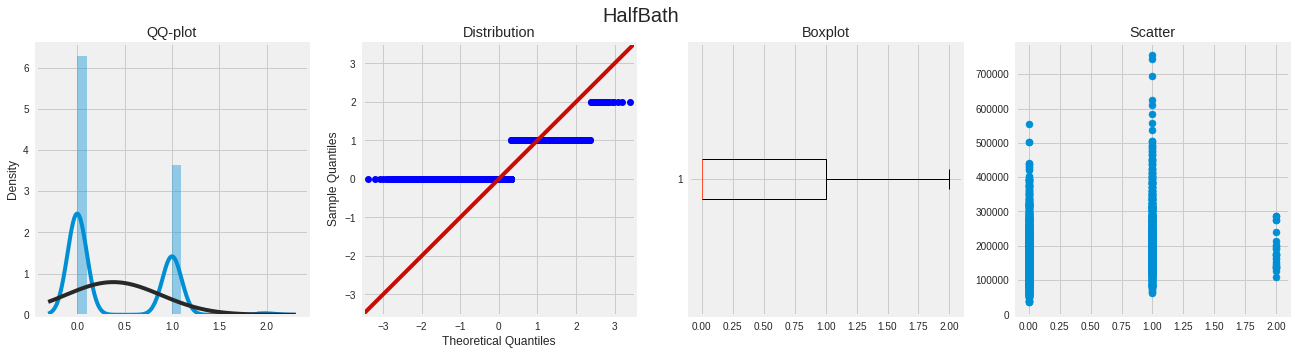

Lower Bound: -1.5, Upper Bound 2.5, Outliers Count: 0


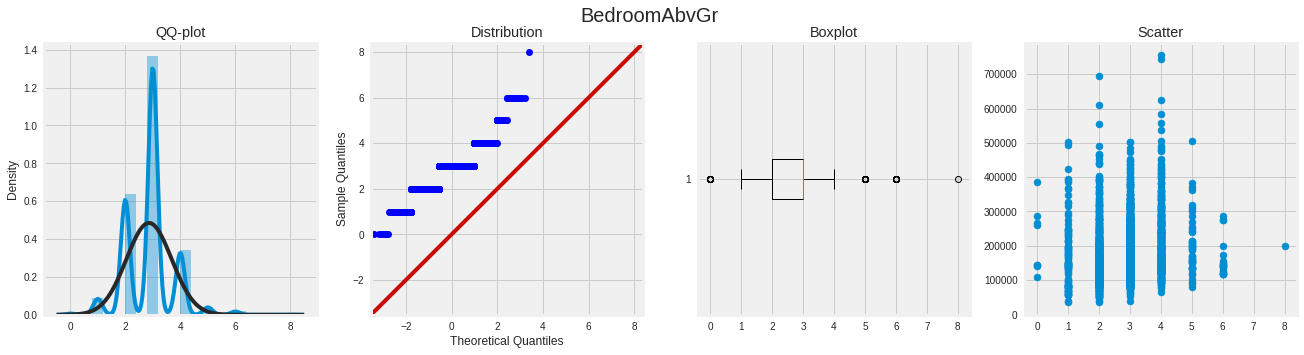

Lower Bound: 0.5, Upper Bound 4.5, Outliers Count: 78


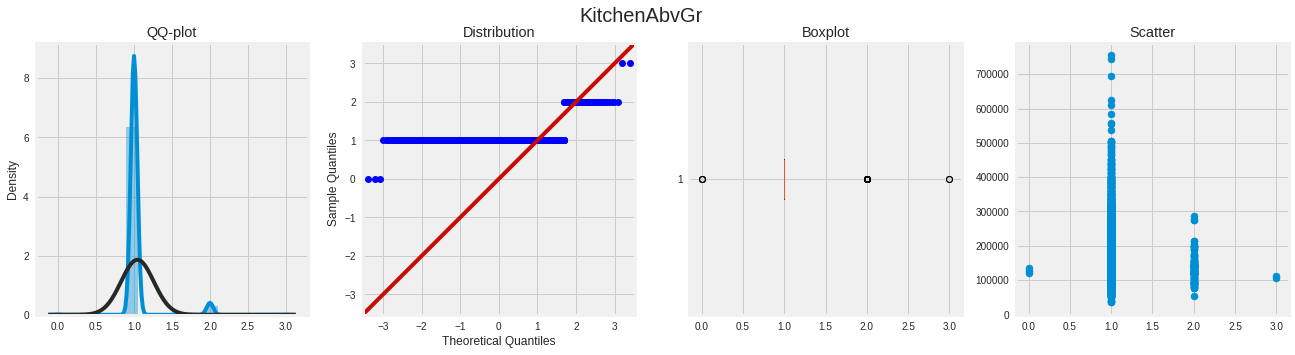

Lower Bound: 1.0, Upper Bound 1.0, Outliers Count: 134


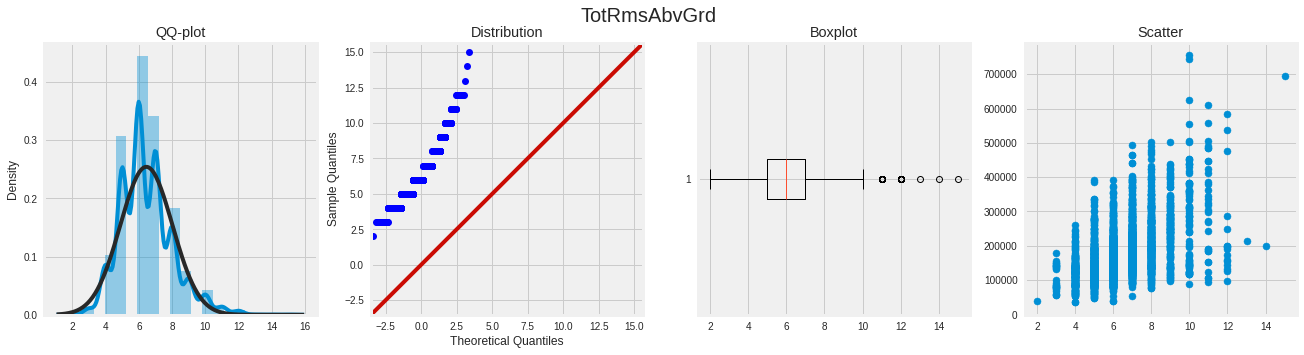

Lower Bound: 2.0, Upper Bound 10.0, Outliers Count: 51


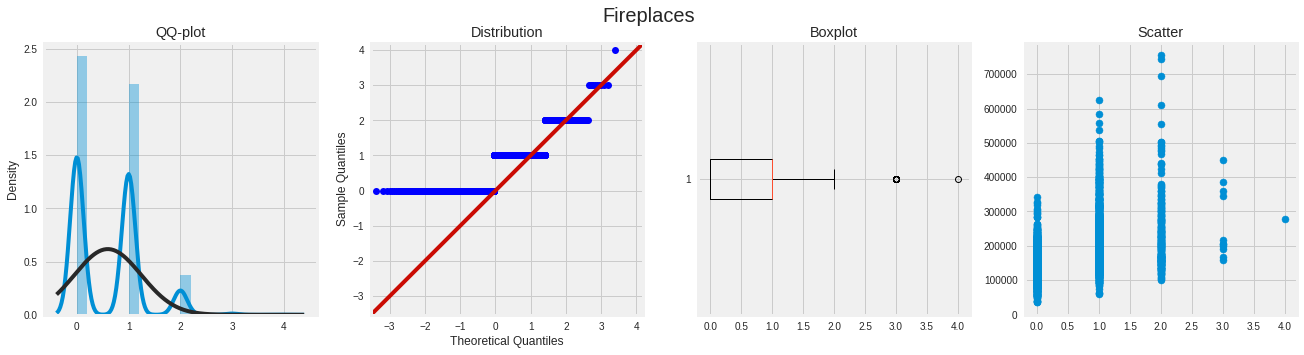

Lower Bound: -1.5, Upper Bound 2.5, Outliers Count: 12


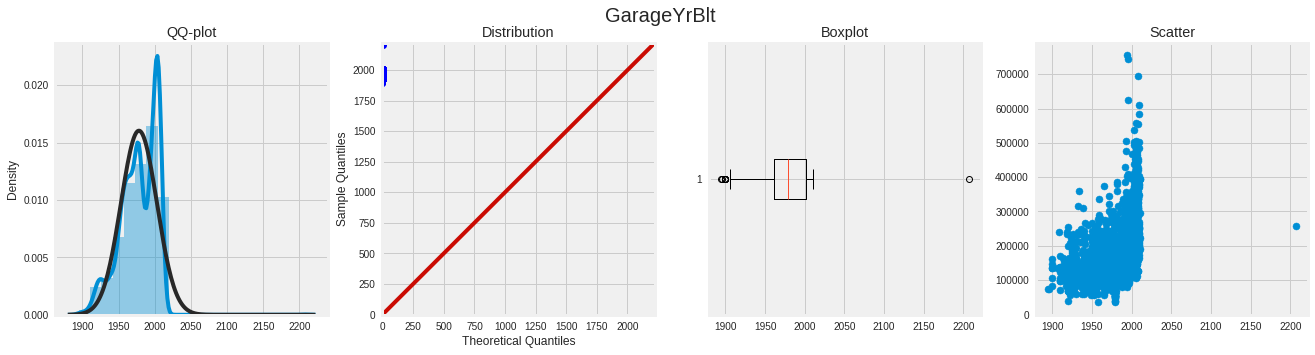

Lower Bound: 1902.25, Upper Bound 2060.25, Outliers Count: 9


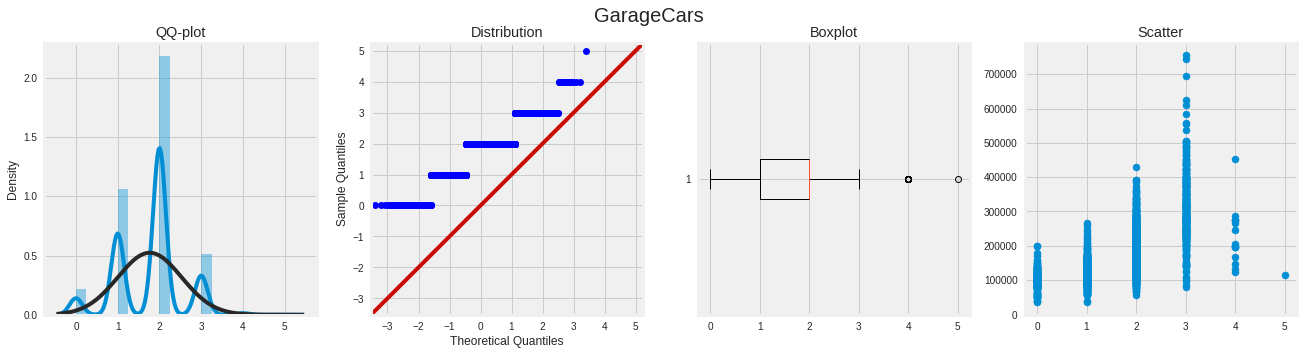

Lower Bound: -0.5, Upper Bound 3.5, Outliers Count: 17


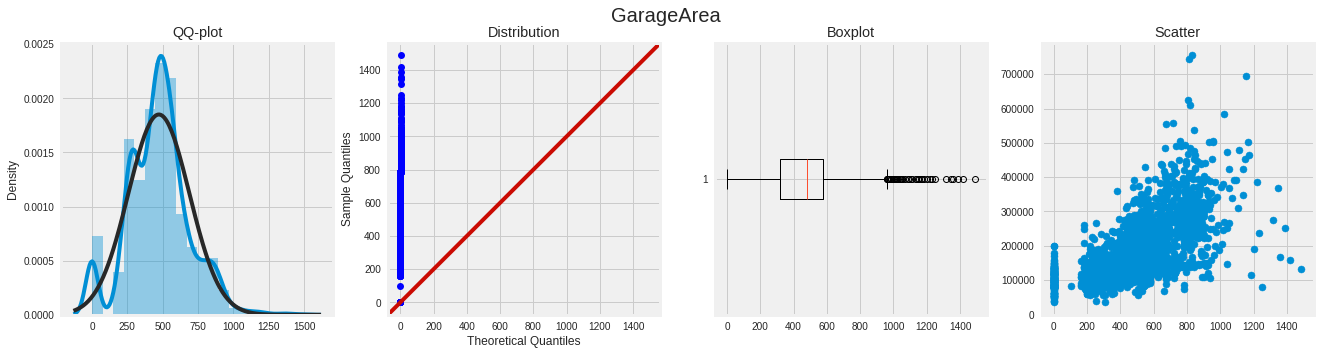

Lower Bound: -64.0, Upper Bound 960.0, Outliers Count: 42


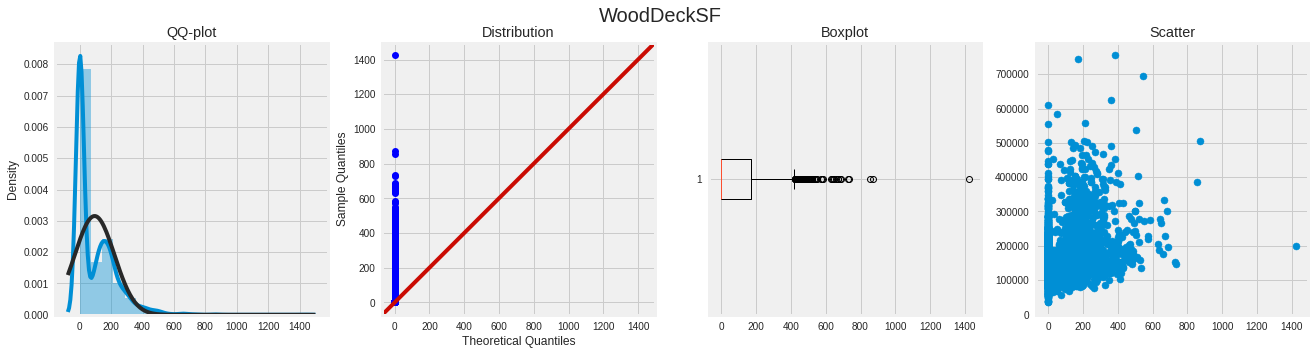

Lower Bound: -252.0, Upper Bound 420.0, Outliers Count: 67


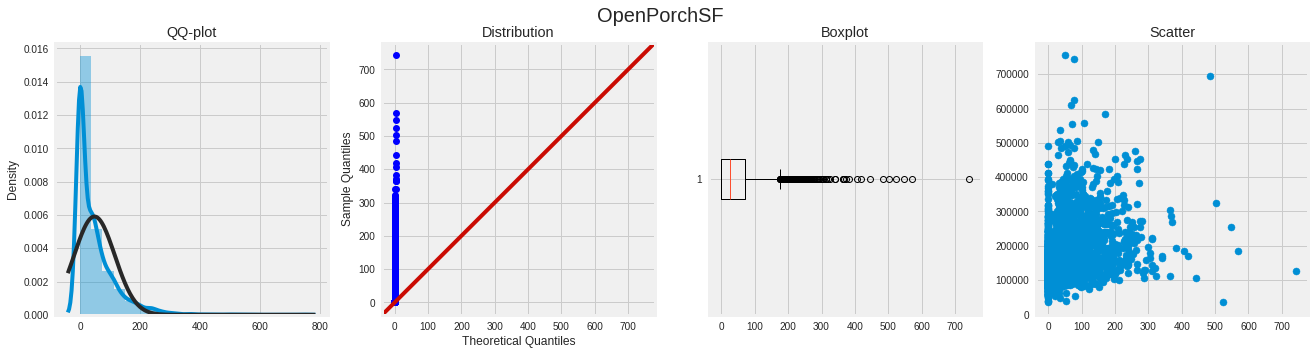

Lower Bound: -105.0, Upper Bound 175.0, Outliers Count: 159


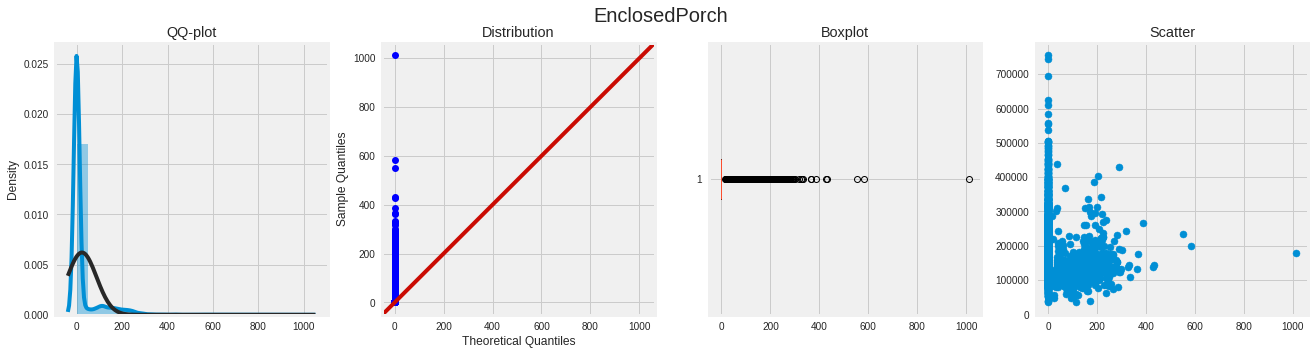

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 459


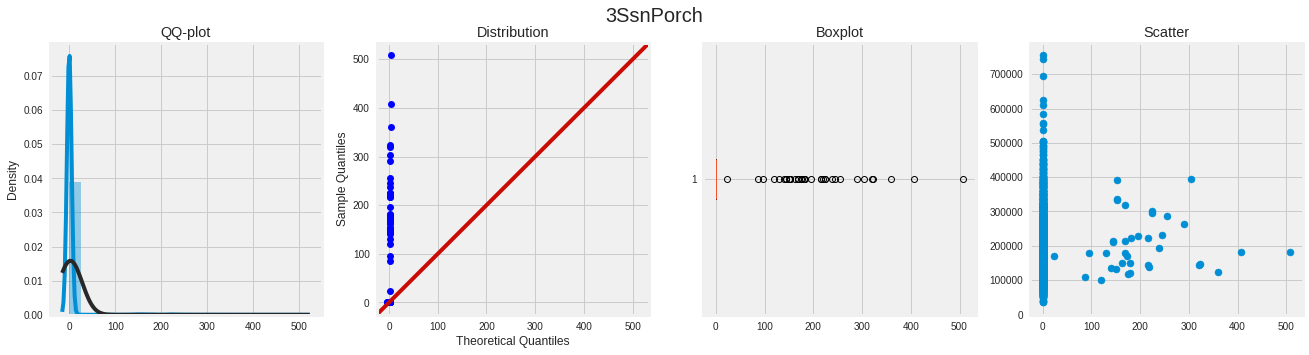

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 37


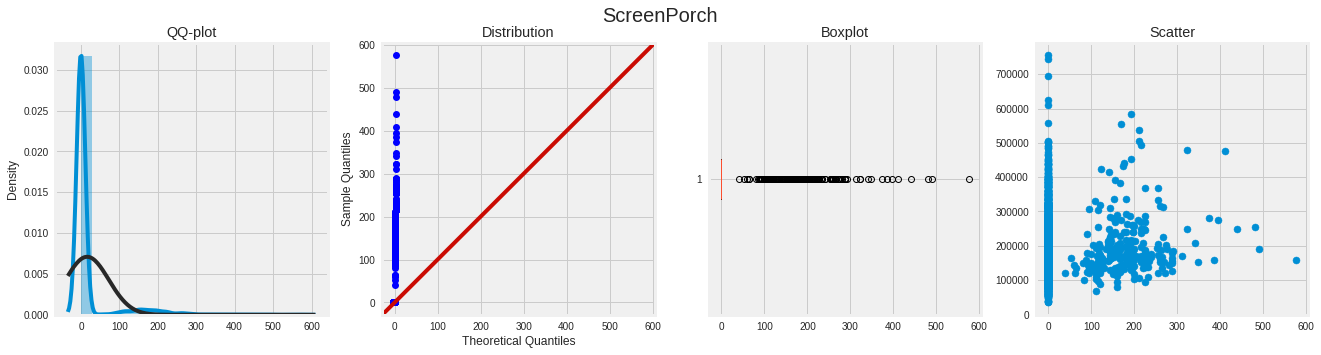

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 256


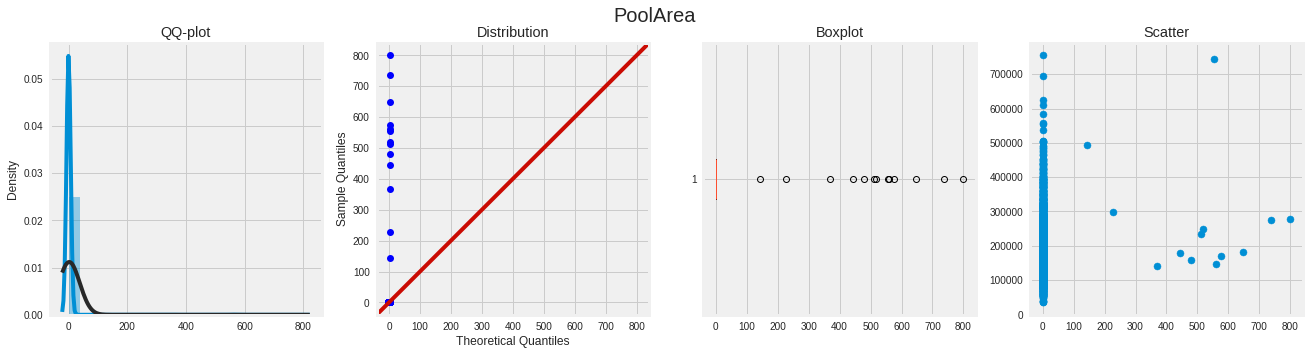

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 13


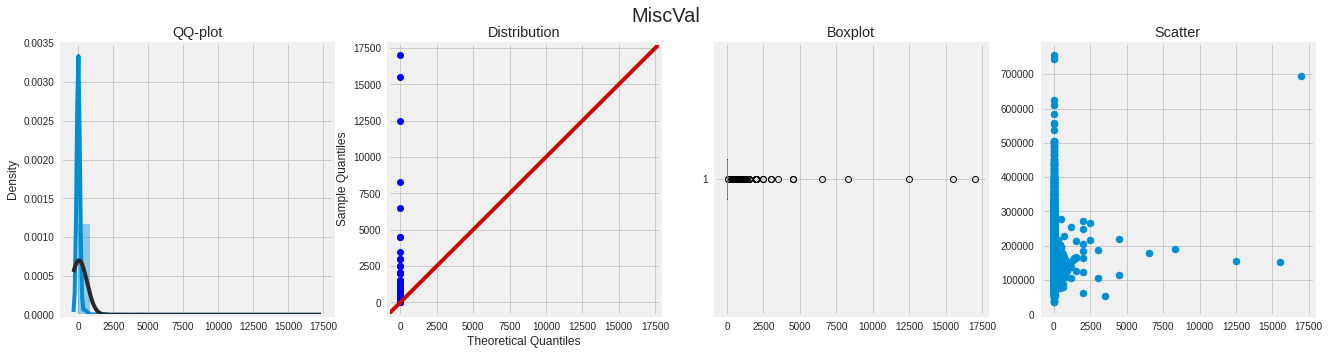

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 103


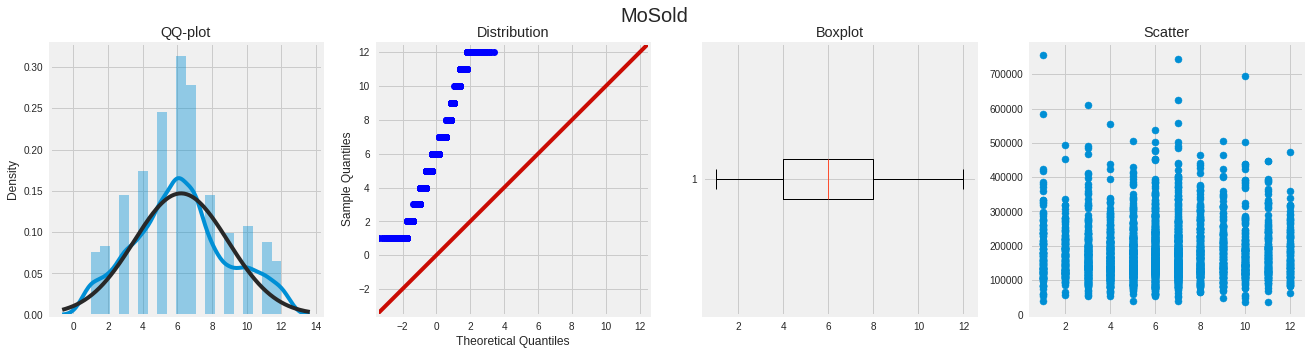

Lower Bound: -2.0, Upper Bound 14.0, Outliers Count: 0


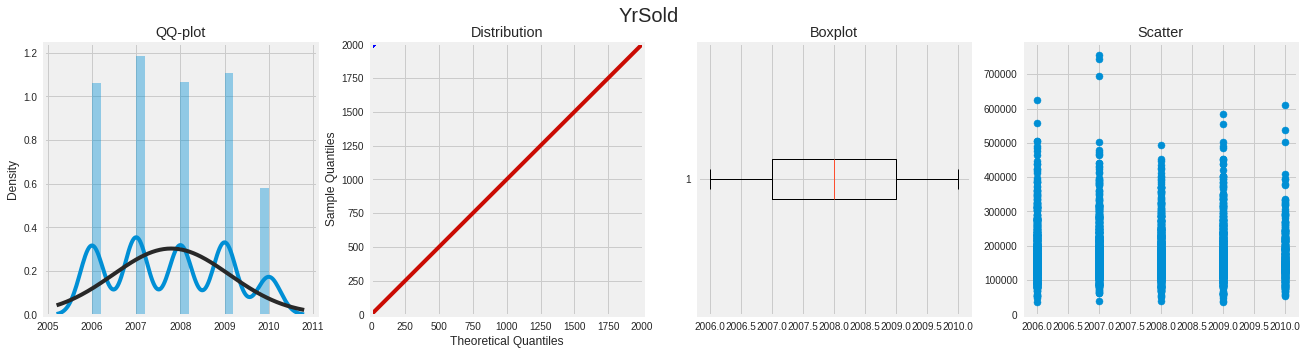

Lower Bound: 2004.0, Upper Bound 2012.0, Outliers Count: 0


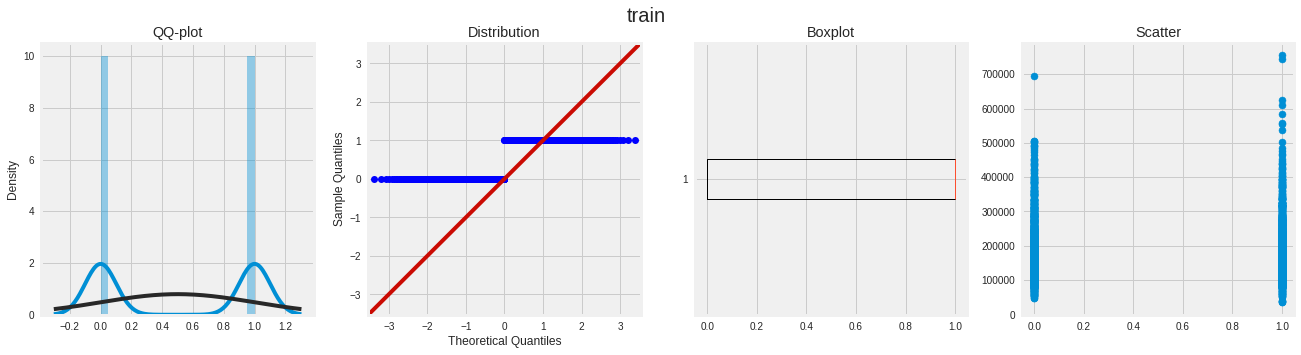

Lower Bound: -1.5, Upper Bound 2.5, Outliers Count: 0


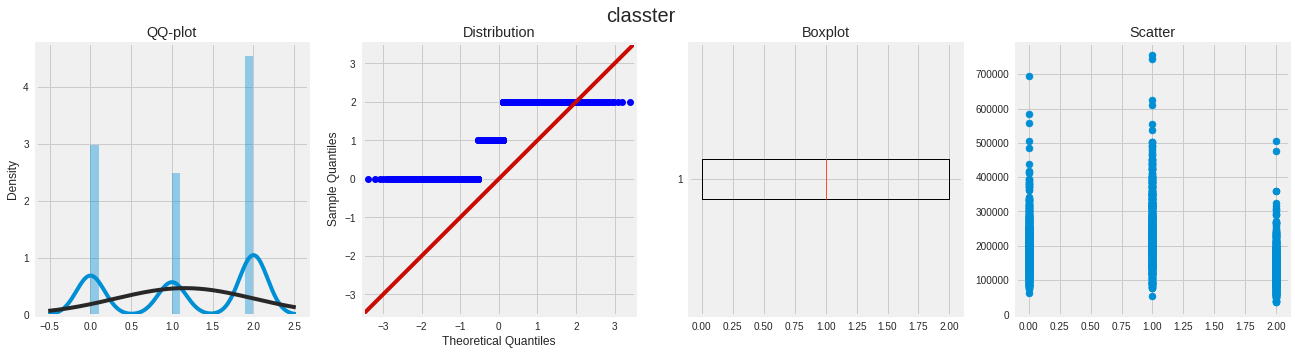

Lower Bound: -3.0, Upper Bound 5.0, Outliers Count: 0


In [395]:
for col in df.select_dtypes(exclude='object').drop('SalePrice', axis=1):
    get_num_info(df[col], title=col, target=df['SalePrice'])
    detect_outliers(df[col])

#### Drop outliers in SalePrice an LivArea

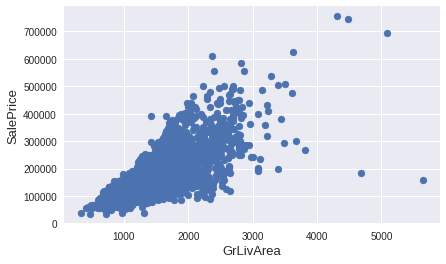

In [146]:
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [147]:
# Не забываем убрать выбросы из таргет переменной
target = target.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

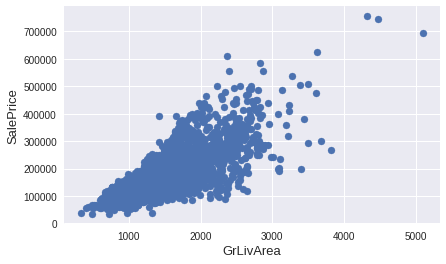

In [148]:
#Deleting outliers
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df['GrLivArea'], df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#### Преобразуем 2207 год постройки гаража в 2007

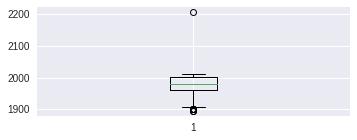

In [149]:
plt.figure(figsize=(5,2))
plt.boxplot(df['GarageYrBlt']);

In [150]:
# Т.к. данное значение лежит в тестовой выборке, удалять его не будем. Заменим на 2007 год
df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x: 2007 if x == 2207 else x)

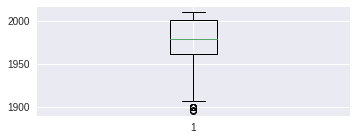

In [151]:
plt.figure(figsize=(5,2))
plt.boxplot(df['GarageYrBlt']);

#### Исправим ситуацию, когда реконструкция была осуществлена ДО постройки дома

In [152]:
df[['YearRemodAdd', 'YearBuilt']][df['YearRemodAdd'].index == 1876]

YearRemodAdd  YearBuilt
1876          2001       2002

In [153]:
df['YearRemodAdd'][df['YearRemodAdd'].index == 1876] = 2002

## Clastering

In [ ]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
X = df.select_dtypes(exclude='object').drop(['SalePrice'], axis=1)
X = StandardScaler().fit_transform(X)

In [ ]:
classs = ['YrSold', 'MiscVal', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch', 'KitchenAbvGr', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath', 'LowQualFinSF', '2ndFlrSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'LotFrontage']#, 'WoodDeckSF', 'TotalBsmtSF', 'MasVnrArea', 'LotArea']

In [ ]:
X = StandardScaler().fit_transform(df[classs])

In [ ]:
pca = PCA(n_components=2)
# tsne = TSNE(n_components=2, perplexity=20)
# umap = UMAP(n_components=2, n_neighbors=5)

In [ ]:
X_pca = pca.fit_transform(X)
# X_tsne = tsne.fit_transform(X)
# X_umap = umap.fit_transform(X)

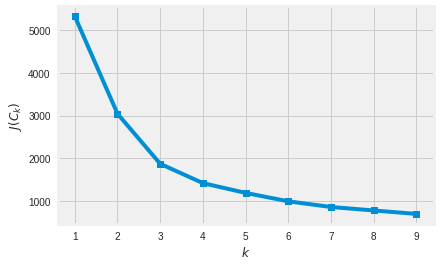

In [ ]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

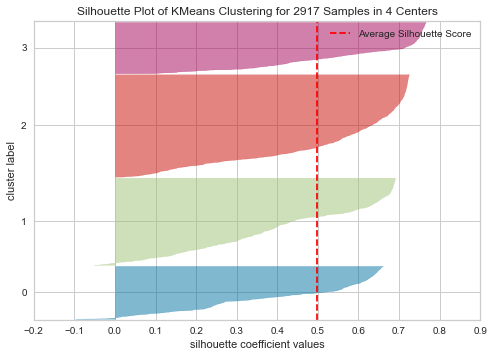

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2917 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(X_pca)
visualizer.show()

In [ ]:
km = KMeans(4)
km.fit(X_pca)

KMeans(n_clusters=4)

In [ ]:
# Добавим класстер в наш датафрейм
op = km.labels_
df['classter'] = op

## Feature Engeneering

### Generate new features

In [37]:
# Суммарные признаки
df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5 + df['FullBath'] + df['HalfBath'] * 0.5
df['TotalBsmtSF'] = df['TotalBsmtSF'] + df['BsmtFinSF1'] + df['BsmtFinSF2']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_Porch_SF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

# Признаки связанные с годом
df['YearBuilt'] = 2017 - df['YearBuilt']
df['GarageYrBlt'] = 2017 - df['GarageYrBlt']
df['TimeLastRemodAdd'] = df['YearRemodAdd'] - df['YearBuilt'] 

# Признаки есть/неть

#df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 1 if x else 0)
#df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x else 0)
#df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x else 0)
#df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
#df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# df['HasMasVnr'] = df['MasVnrArea'].apply(lambda x: 1 if x else 0)
# df['HasMiscVal'] = df['MiscVal'].apply(lambda x: 1 if x else 0)
# df['HasWoodDeckSF'] = df['WoodDeckSF'].apply(lambda x: 1 if x else 0)
# df['HasOpenPorchSF'] = df['OpenPorchSF'].apply(lambda x: 1 if x else 0)
# df['HasEnclosedPorch'] = df['EnclosedPorch'].apply(lambda x: 1 if x else 0)
# df['Has3SsnPorch'] = df['3SsnPorch'].apply(lambda x: 1 if x else 0)
# df['HasScreenPorch'] = df['ScreenPorch'].apply(lambda x: 1 if x else 0)

### Transform features to Categorical

In [154]:
#MSSubClass=The building class
df['MSSubClass'] = df['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
df['OverallCond'] = df['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

In [39]:
get_uniq_values(df.select_dtypes(exclude='object'))['Unique values'].apply(lambda x: len(x)).sort_values().head(20)

train             2
HalfBath          3
BsmtHalfBath      3
KitchenAbvGr      4
BsmtFullBath      4
FullBath          5
Fireplaces        5
GarageCars        6
BedroomAbvGr      8
OverallQual      10
TotalBath        11
PoolArea         13
TotRmsAbvGrd     14
3SsnPorch        31
LowQualFinSF     36
MiscVal          38
YearRemodAdd     61
GarageYrBlt     102
YearBuilt       118
ScreenPorch     121
Name: Unique values, dtype: int64

In [40]:
for feature in get_uniq_values(df.select_dtypes(exclude='object'))['Unique values'].apply(lambda x: len(x)).sort_values().head(11).index:
    df[feature] = df[feature].apply(str)

### Matrix of correlation

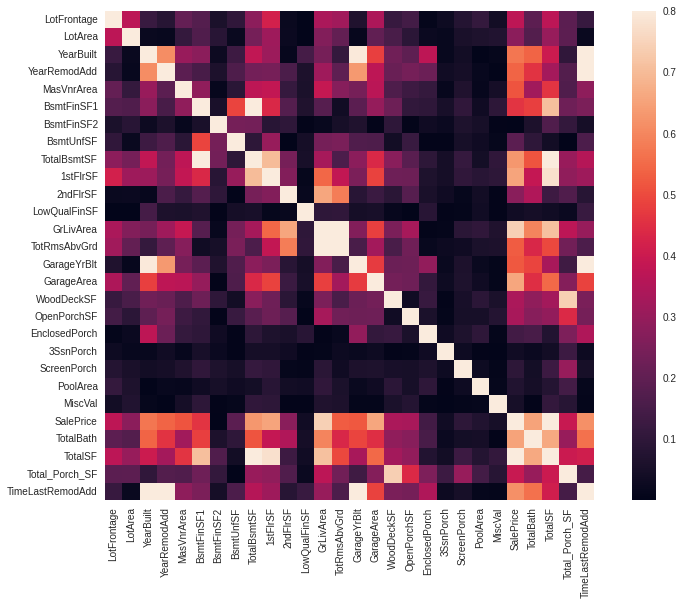

In [408]:
#correlation matrix
corrmat = df.corr().abs()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

<AxesSubplot:>

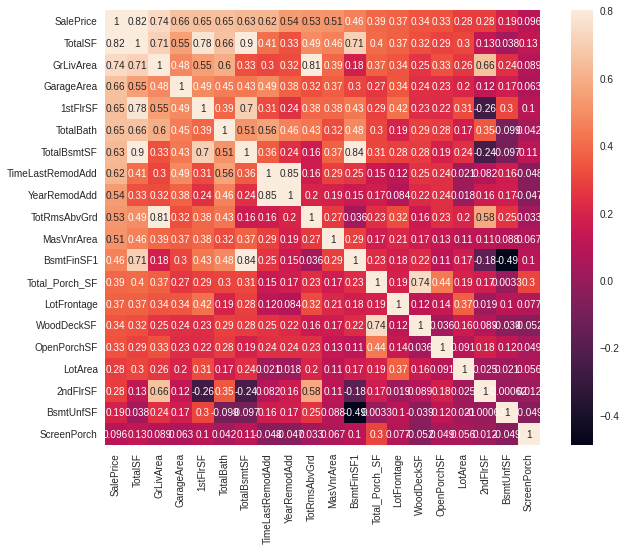

In [409]:
cols = df.corr().nlargest(20, 'SalePrice')['SalePrice'].index
plt.figure(figsize=(10, 8))
sns.heatmap(df[cols].corr(), annot=True, vmax=.8, square=True)

### Drop features

In [335]:
df.drop(['HasFireplace','1stFlrSF'], axis = 1, inplace=True)

In [41]:

df.drop('YearRemodAdd', axis = 1, inplace=True)

In [198]:
outliers = [30, 88, 462, 631, 1322]
# X = X.drop(X.index[outliers])
# y = y.drop(y.index[outliers])

In [155]:
df.drop('Utilities', axis = 1, inplace=True)

In [43]:
df.drop(['GarageArea', 'PoolArea', '2ndFlrSF', 'Fireplaces'], axis=1, inplace=True)

In [413]:
df.drop(['BedroomAbvGr', 'KitchenAbvGr'], axis = 1, inplace=True)

### Normalize features

##### Skewness

In [156]:
skewness = df.select_dtypes(exclude='object').apply(lambda x: abs(skew(x)))
skewness.sort_values(ascending=False, inplace=True)

skewness = pd.DataFrame({'Skew' :skewness})

skewness

Skew
MiscVal        21.939672
PoolArea       17.688664
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101
BsmtHalfBath    3.929996
MasVnrArea      2.621719
OpenPorchSF     2.529358
WoodDeckSF      1.844792
SalePrice       1.746453
1stFlrSF        1.257286
LotFrontage     1.102764
GrLivArea       1.068750
BsmtFinSF1      0.980645
BsmtUnfSF       0.919688
2ndFlrSF        0.861556
TotRmsAbvGrd    0.749232
Fireplaces      0.725278
HalfBath        0.696666
GarageYrBlt     0.685773
TotalBsmtSF     0.671751
BsmtFullBath    0.622415
YearBuilt       0.599194
YearRemodAdd    0.450131
BedroomAbvGr    0.326568
GarageCars      0.219297
GarageArea      0.216857
OverallQual     0.189591
FullBath        0.165514
train           0.000686

In [157]:
skewness = skewness[abs(skewness)>0.5]

skew_features = df[skewness.index]
print(skew_features.columns, '\n', len(skew_features.columns))

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
       'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'SalePrice',
       '1stFlrSF', 'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF',
       '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'GarageYrBlt',
       'TotalBsmtSF', 'BsmtFullBath', 'YearBuilt', 'YearRemodAdd',
       'BedroomAbvGr', 'GarageCars', 'GarageArea', 'OverallQual', 'FullBath',
       'train'],
      dtype='object') 
 34


##### Treat skewness features with log transformation

In [158]:
df[skew_features.columns] = np.log1p(df[skew_features.columns])
df[skew_features.columns].columns, len(df[skew_features.columns].columns)

(Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
        'KitchenAbvGr', 'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch',
        'BsmtHalfBath', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'SalePrice',
        '1stFlrSF', 'LotFrontage', 'GrLivArea', 'BsmtFinSF1', 'BsmtUnfSF',
        '2ndFlrSF', 'TotRmsAbvGrd', 'Fireplaces', 'HalfBath', 'GarageYrBlt',
        'TotalBsmtSF', 'BsmtFullBath', 'YearBuilt', 'YearRemodAdd',
        'BedroomAbvGr', 'GarageCars', 'GarageArea', 'OverallQual', 'FullBath',
        'train'],
       dtype='object'),
 34)

In [ ]:
#df['SalePrice'] = np.log1p(df['SalePrice'])

#### Повторное построение графиков после логарифмирования

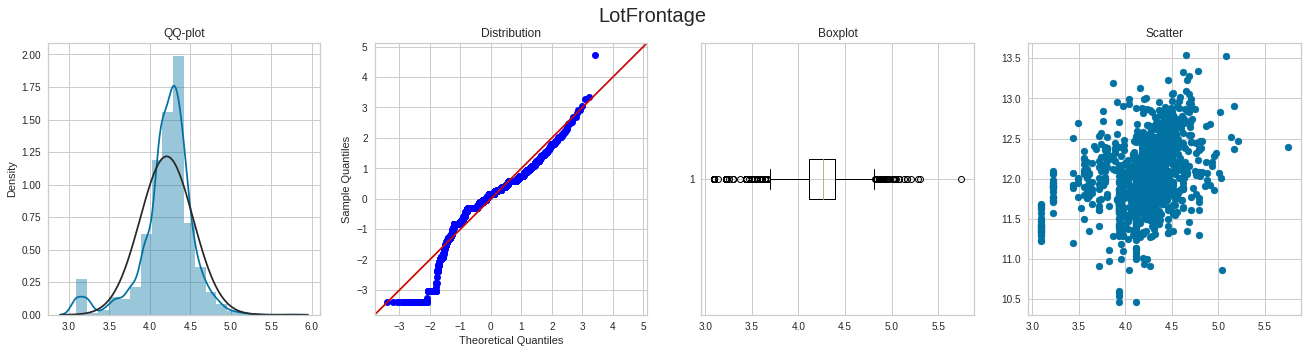

Lower Bound: 3.686, Upper Bound 4.82, Outliers Count: 238


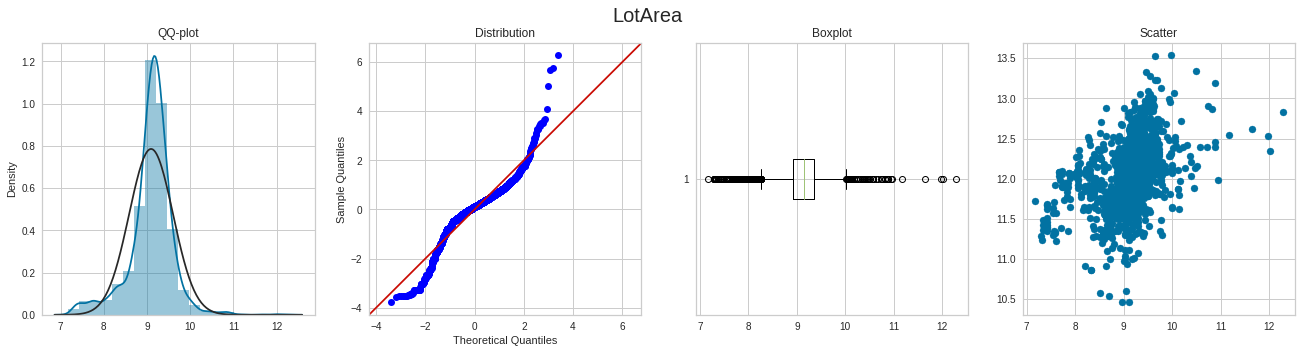

Lower Bound: 8.266, Upper Bound 10.008, Outliers Count: 256


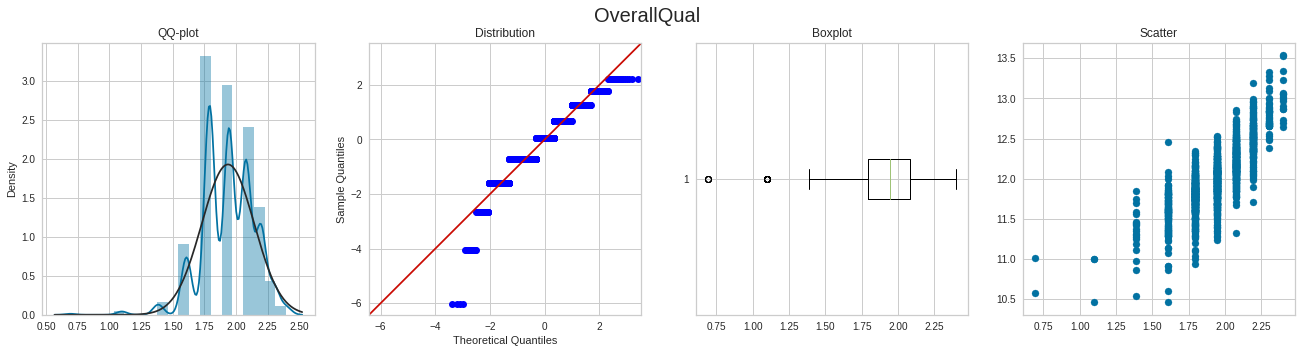

Lower Bound: 1.36, Upper Bound 2.511, Outliers Count: 17


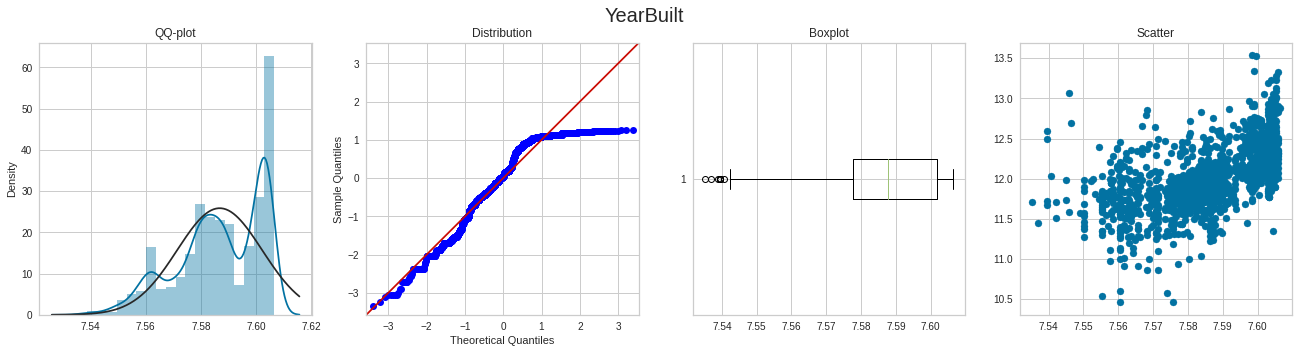

Lower Bound: 7.541, Upper Bound 7.638, Outliers Count: 9


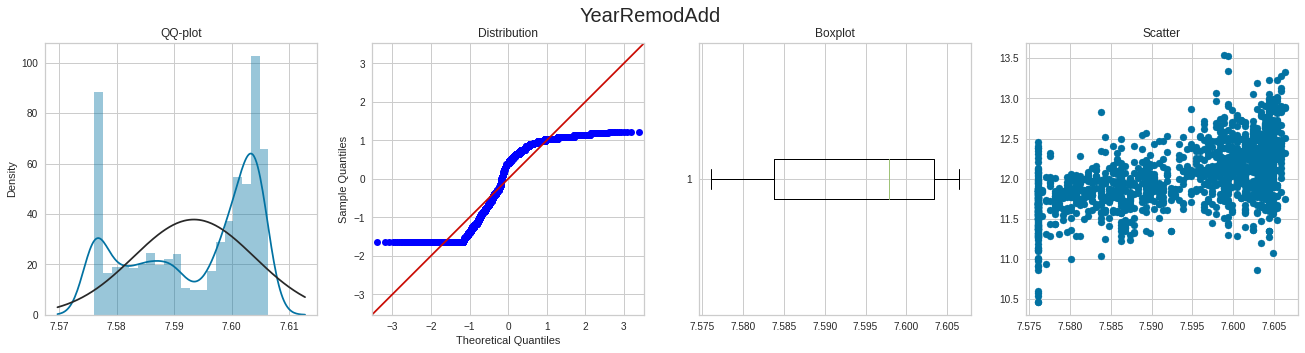

Lower Bound: 7.554, Upper Bound 7.633, Outliers Count: 0


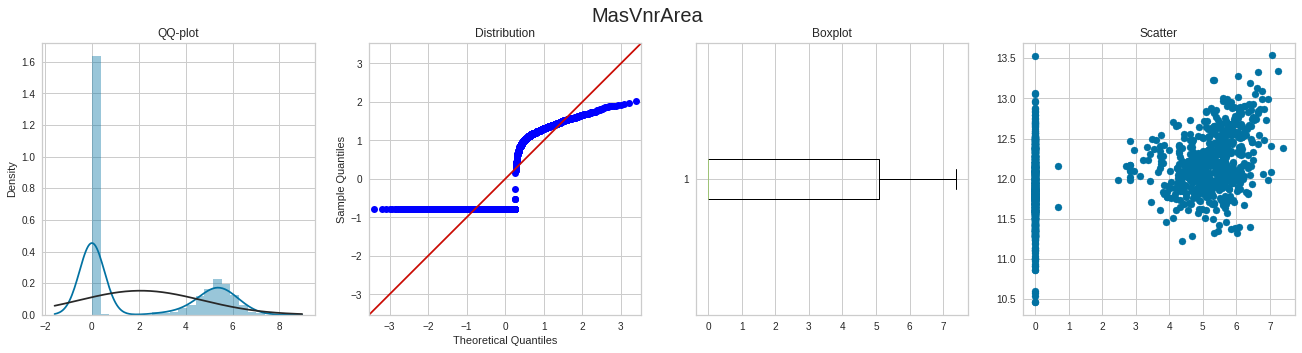

Lower Bound: -7.65, Upper Bound 12.75, Outliers Count: 0


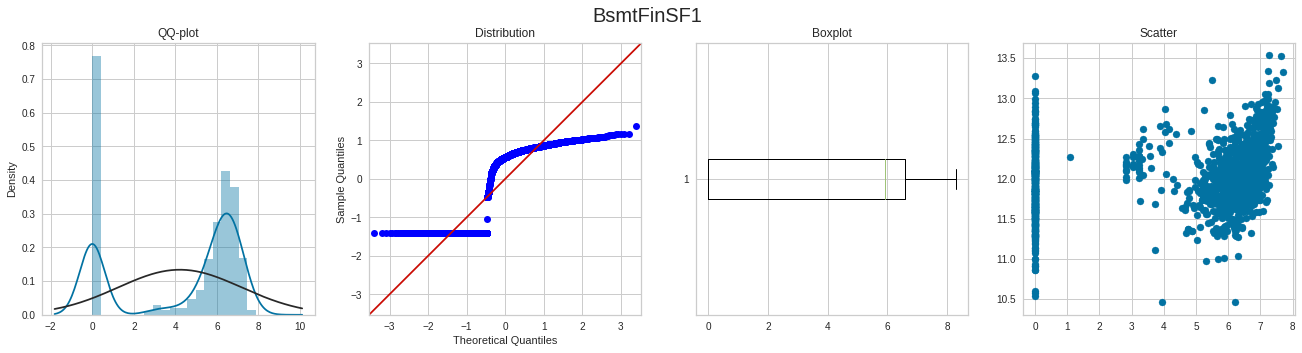

Lower Bound: -9.898, Upper Bound 16.496, Outliers Count: 0


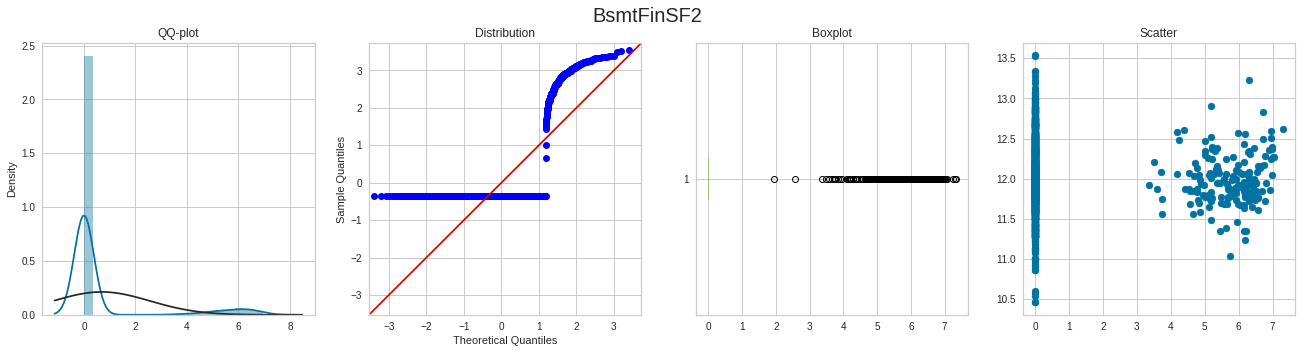

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 347


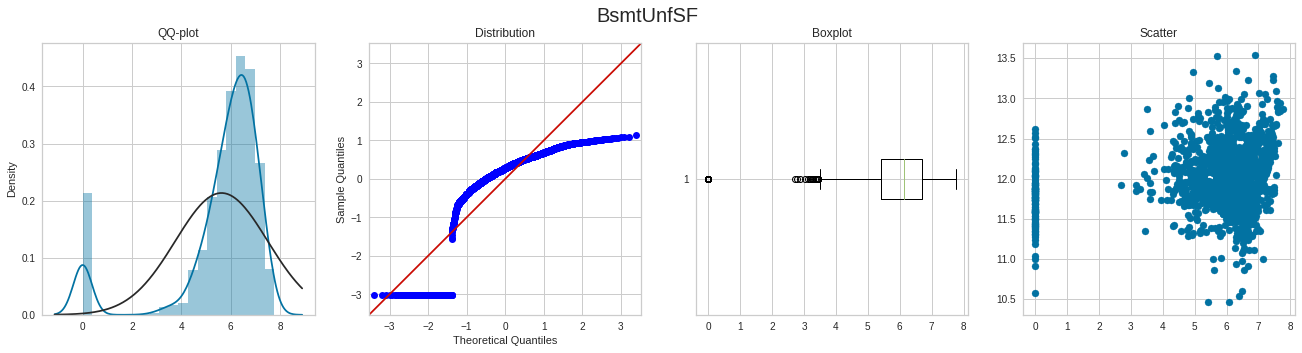

Lower Bound: 3.459, Upper Bound 8.63, Outliers Count: 262


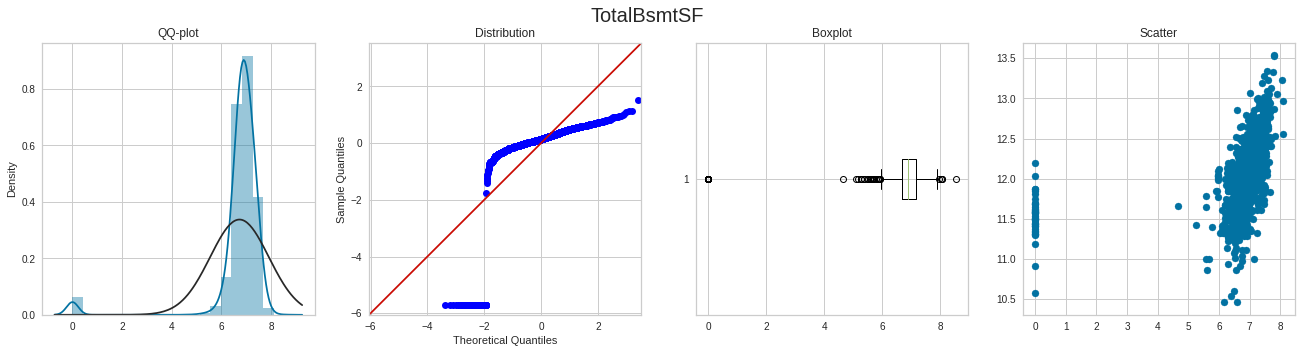

Lower Bound: 5.934, Upper Bound 7.915, Outliers Count: 111


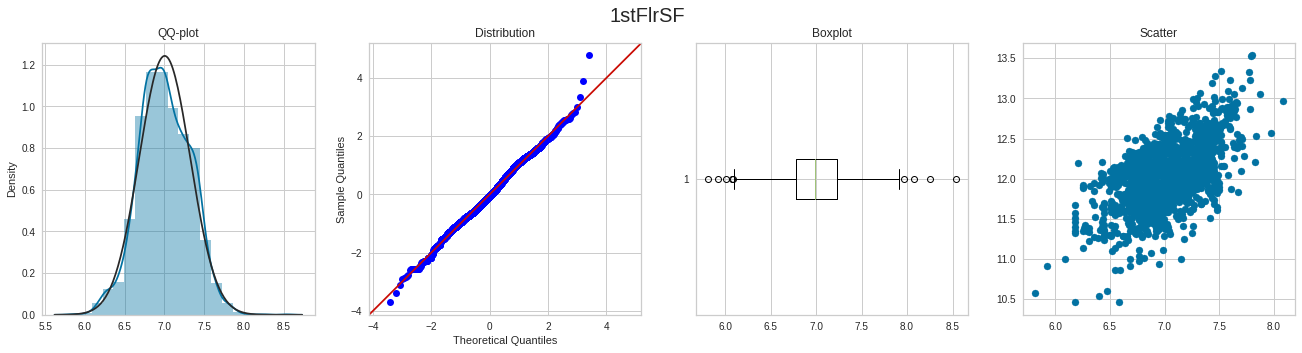

Lower Bound: 6.091, Upper Bound 7.919, Outliers Count: 9


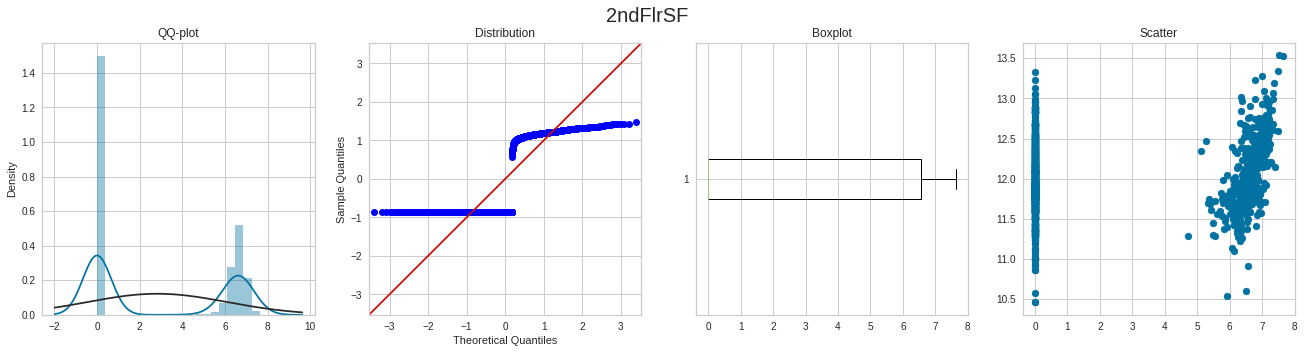

Lower Bound: -9.837, Upper Bound 16.395, Outliers Count: 0


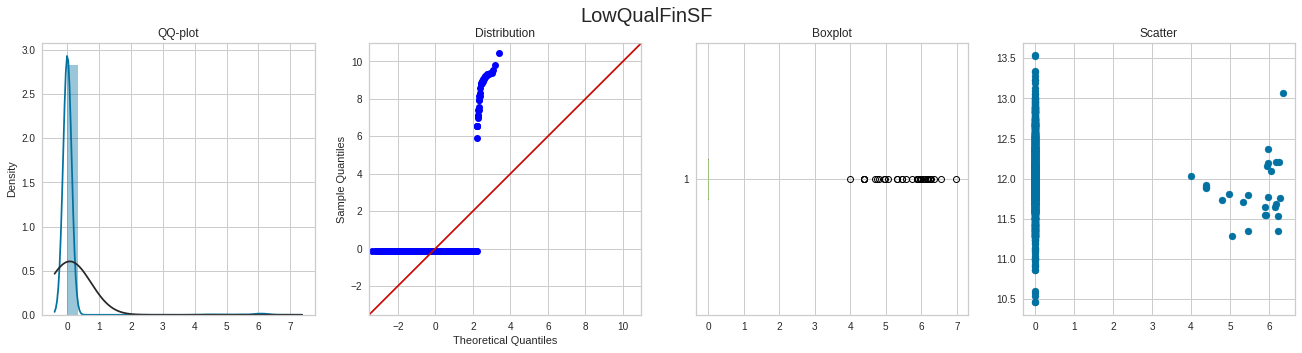

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 40


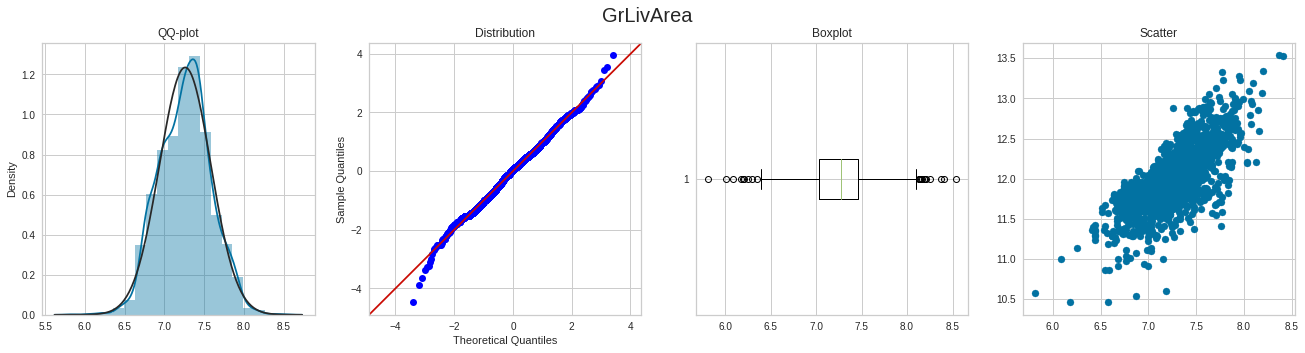

Lower Bound: 6.372, Upper Bound 8.119, Outliers Count: 21


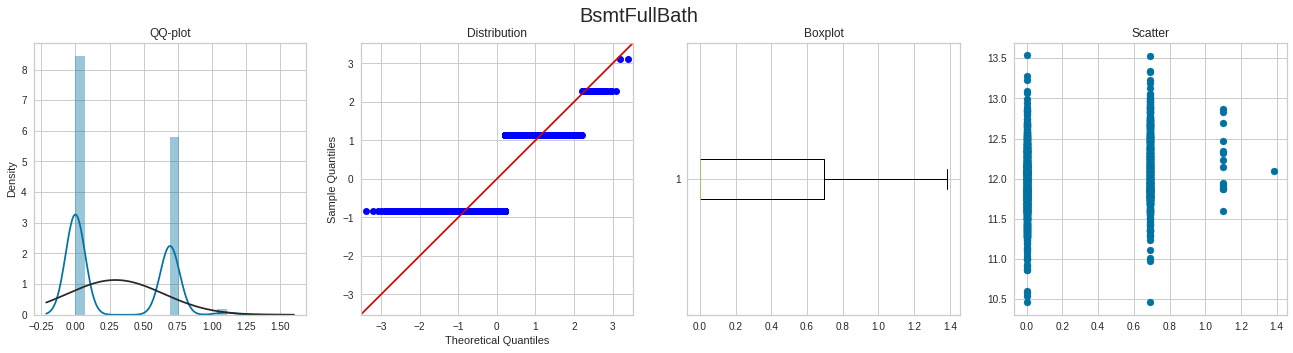

Lower Bound: -1.04, Upper Bound 1.733, Outliers Count: 0


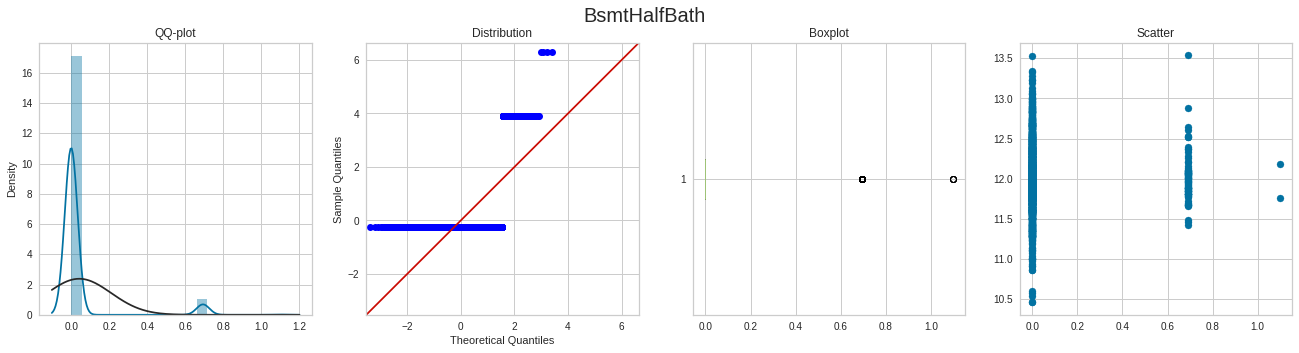

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 175


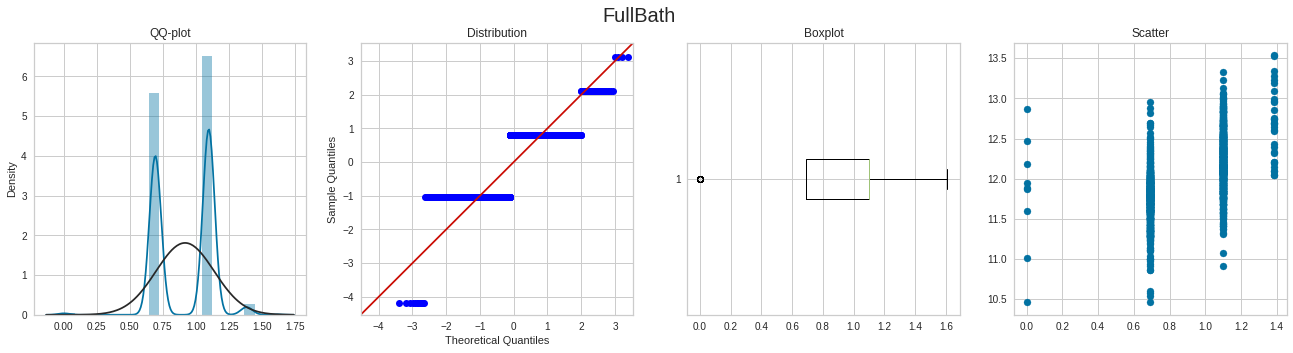

Lower Bound: 0.085, Upper Bound 1.707, Outliers Count: 12


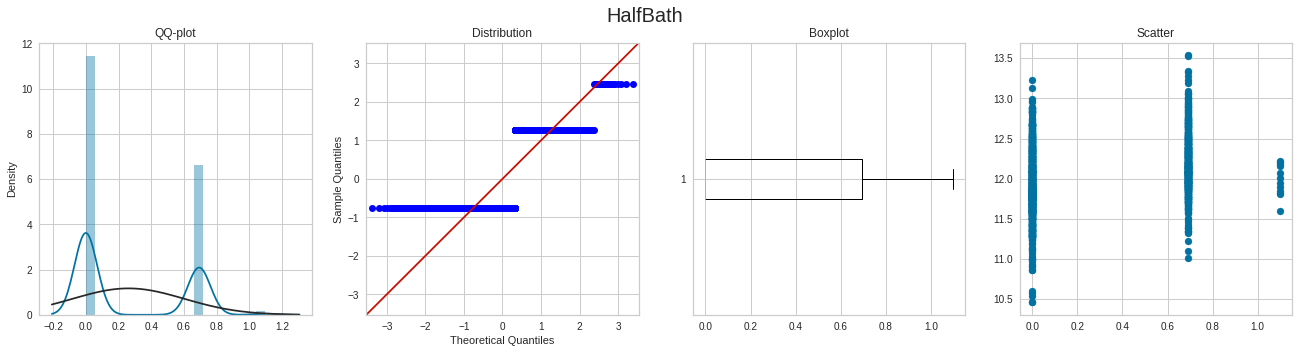

Lower Bound: -1.04, Upper Bound 1.733, Outliers Count: 0


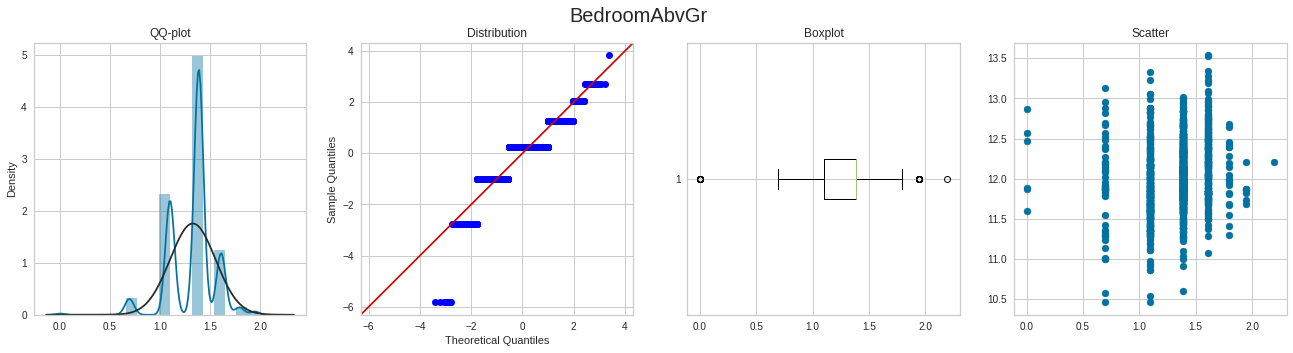

Lower Bound: 0.667, Upper Bound 1.818, Outliers Count: 30


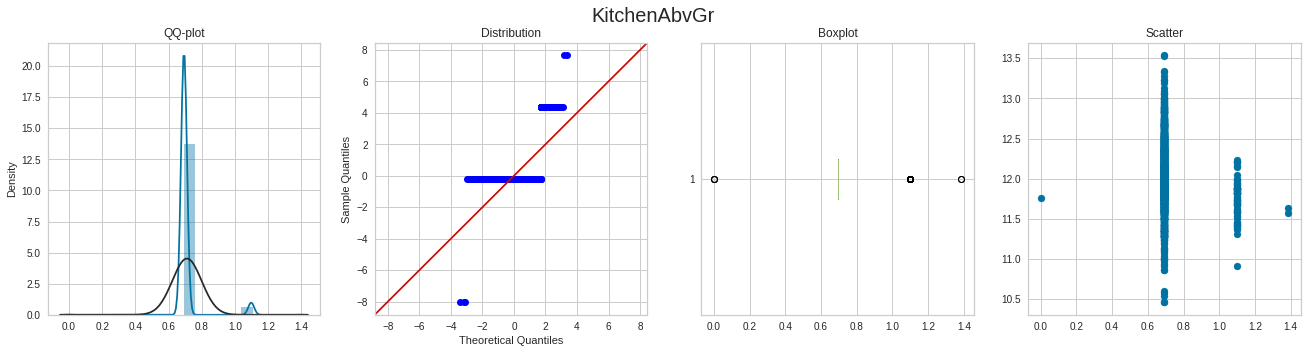

Lower Bound: 0.693, Upper Bound 0.693, Outliers Count: 134


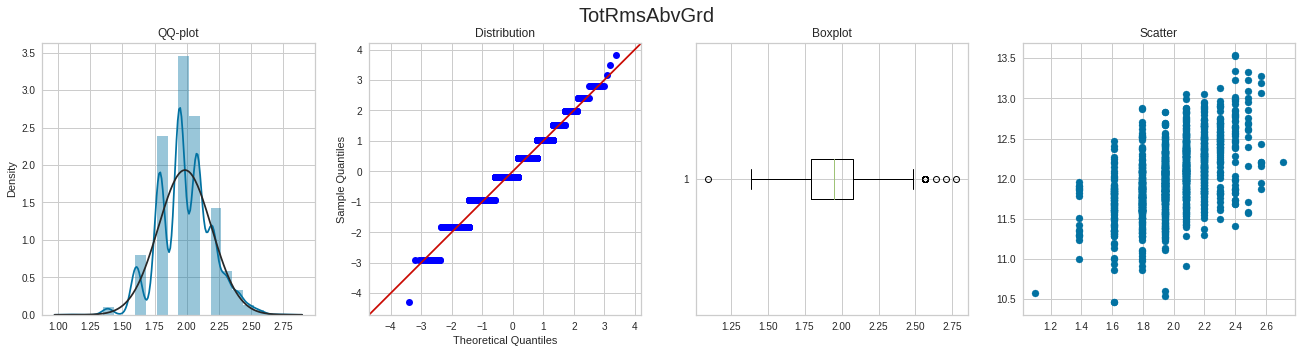

Lower Bound: 1.36, Upper Bound 2.511, Outliers Count: 19


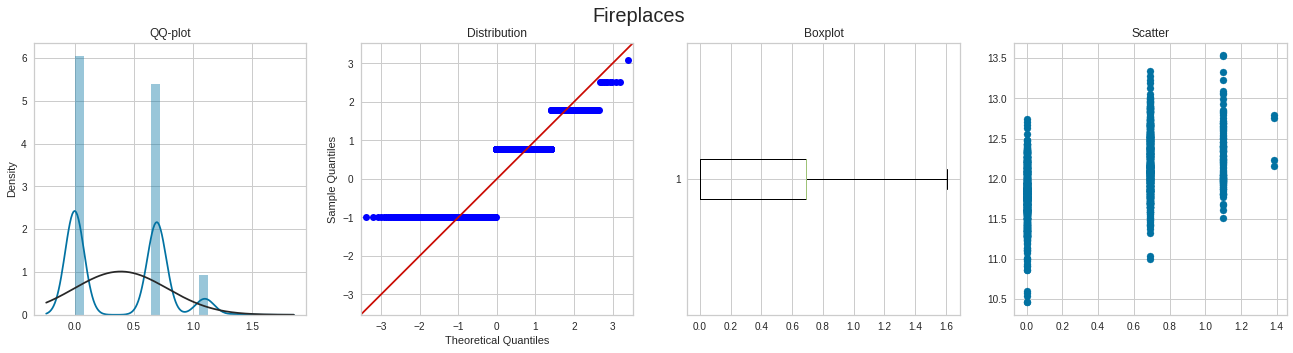

Lower Bound: -1.04, Upper Bound 1.733, Outliers Count: 0


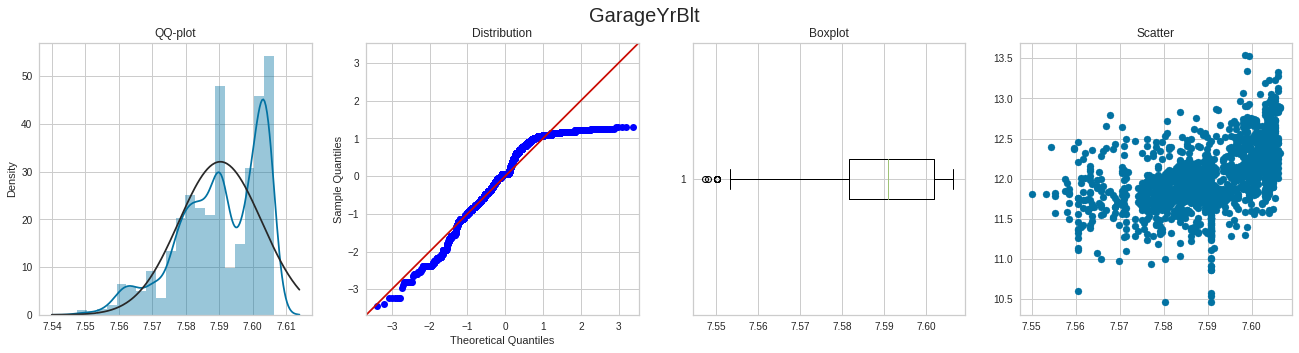

Lower Bound: 7.551, Upper Bound 7.632, Outliers Count: 8


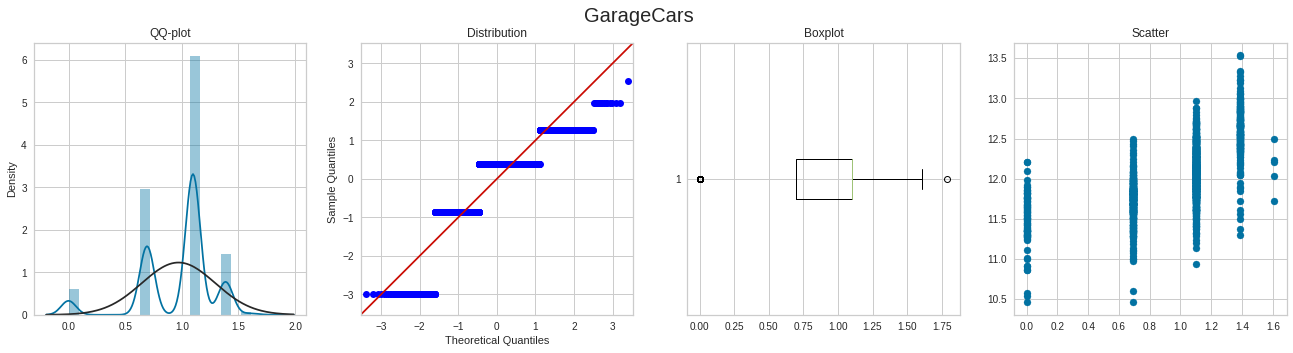

Lower Bound: 0.085, Upper Bound 1.707, Outliers Count: 159


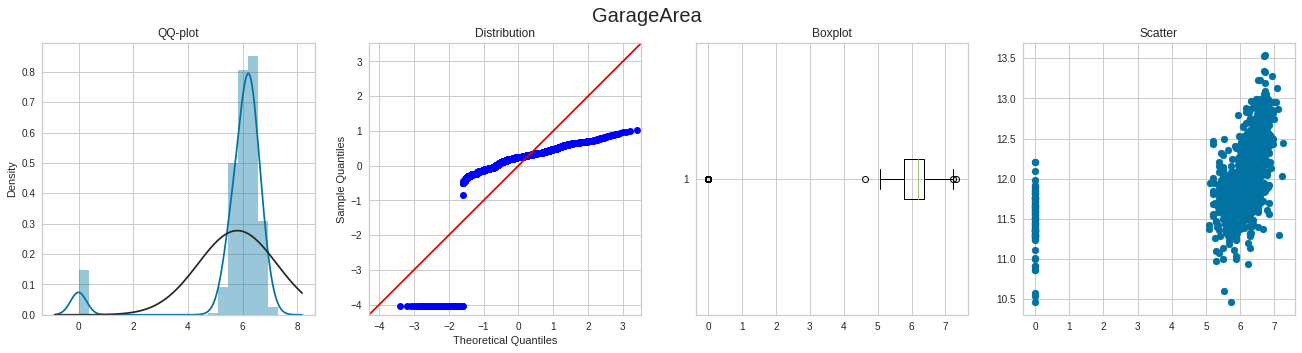

Lower Bound: 4.892, Upper Bound 7.237, Outliers Count: 161


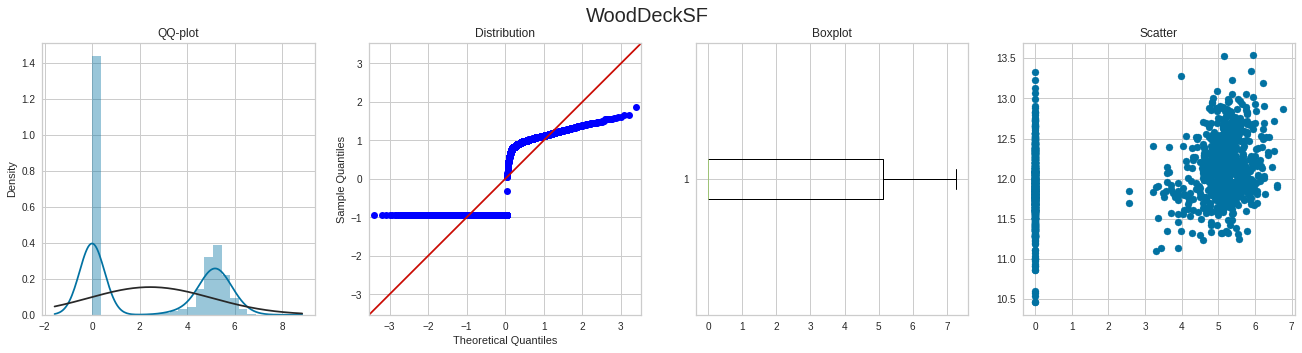

Lower Bound: -7.695, Upper Bound 12.825, Outliers Count: 0


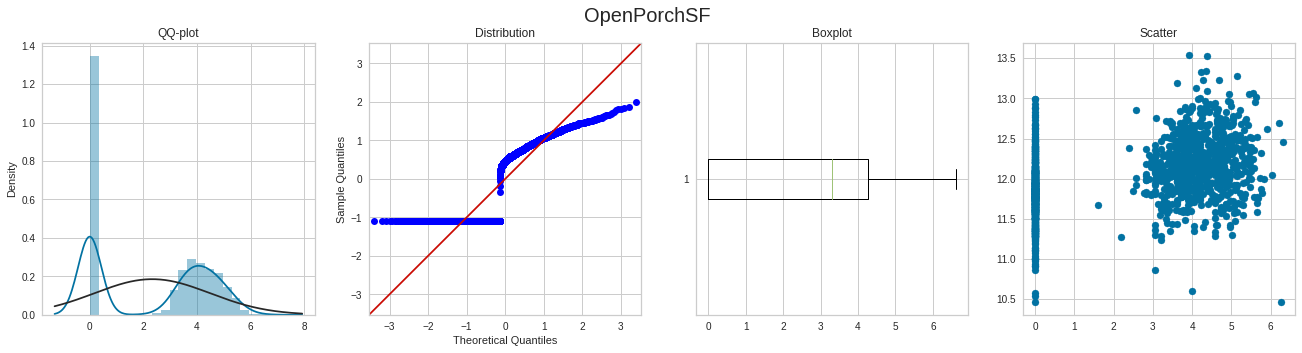

Lower Bound: -6.394, Upper Bound 10.657, Outliers Count: 0


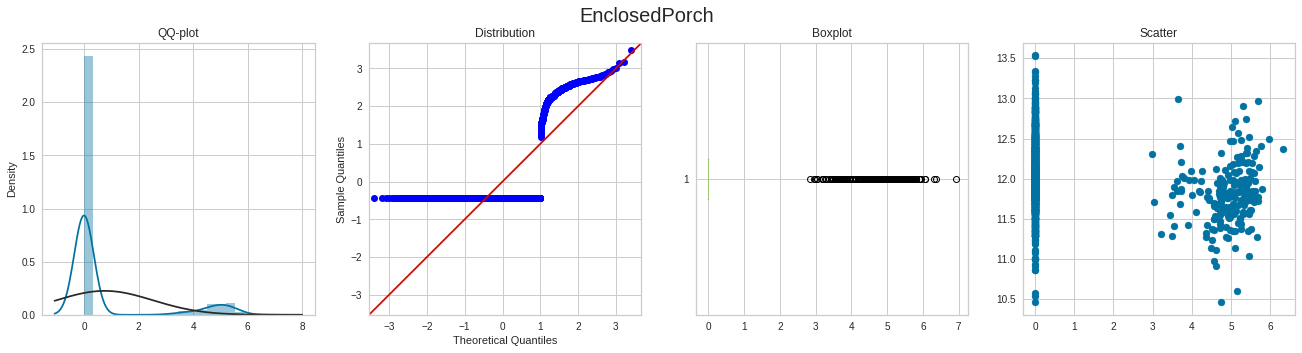

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 459


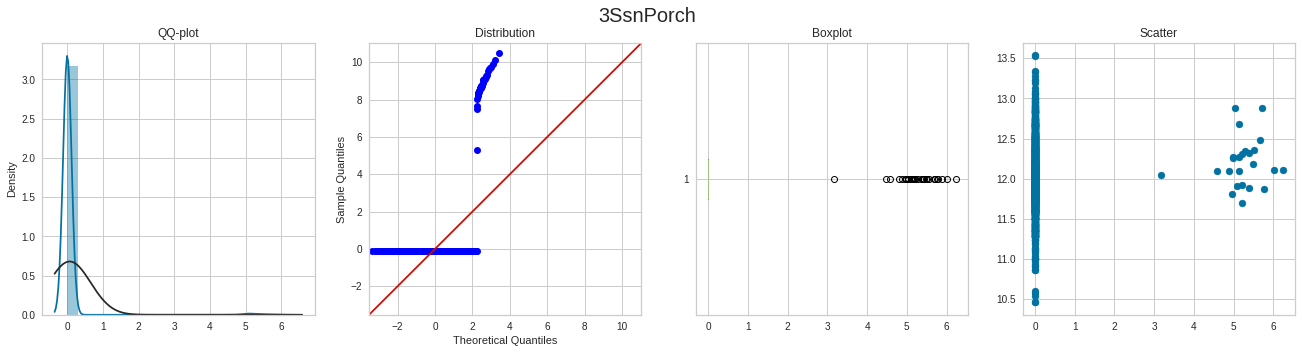

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 37


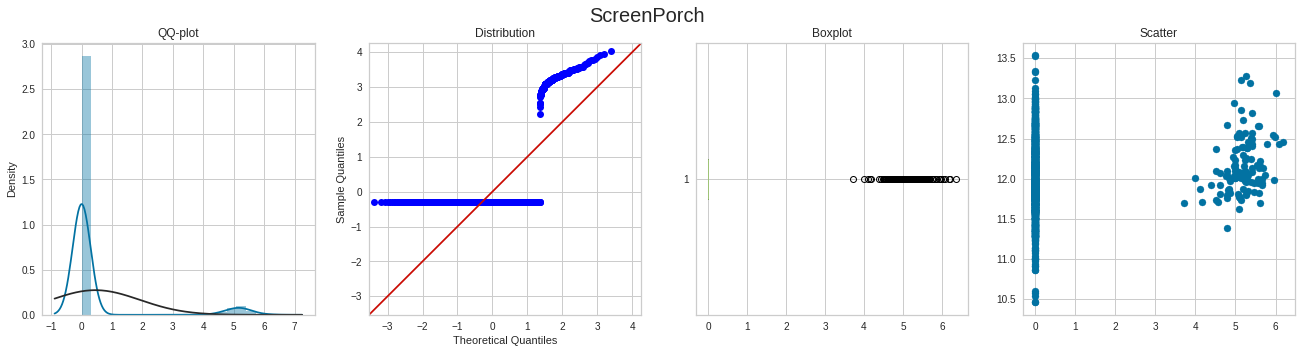

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 256


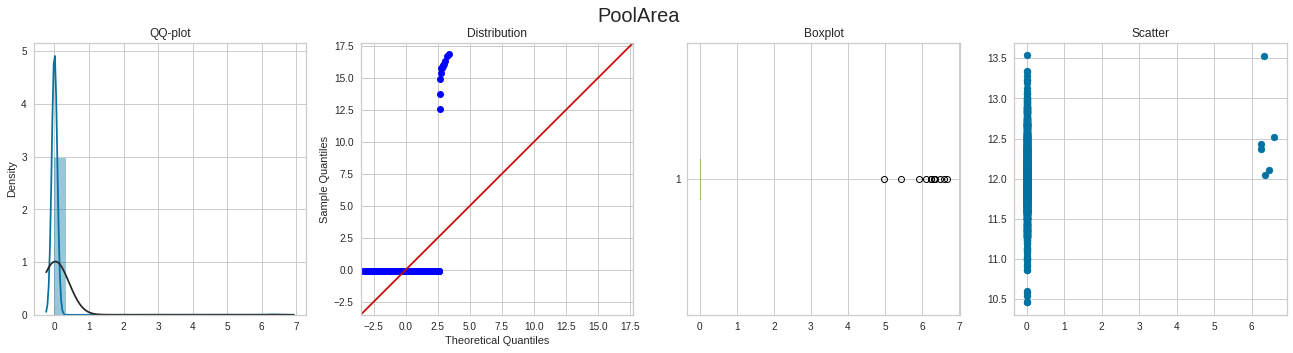

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 12


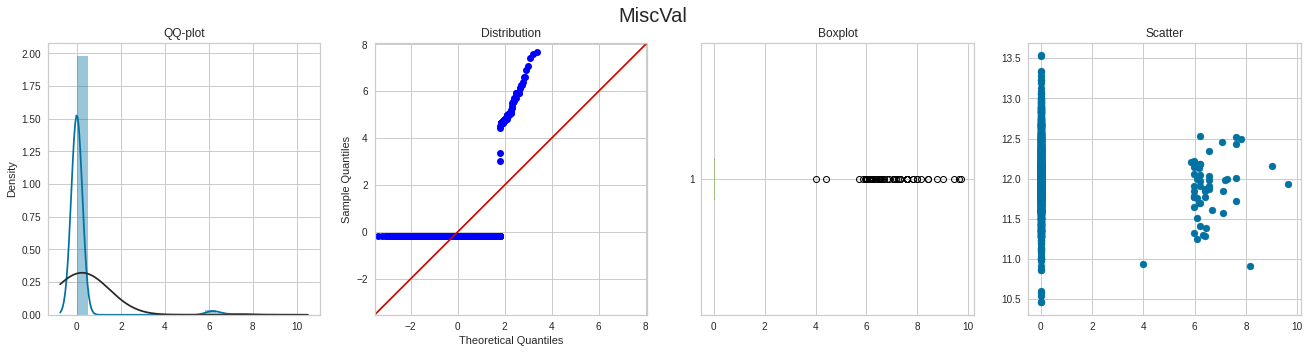

Lower Bound: 0.0, Upper Bound 0.0, Outliers Count: 103


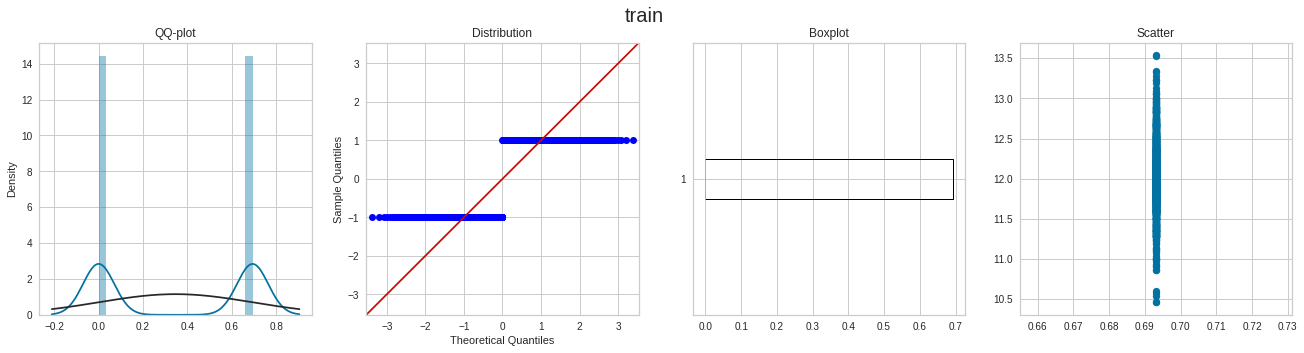

Lower Bound: -1.04, Upper Bound 1.733, Outliers Count: 0


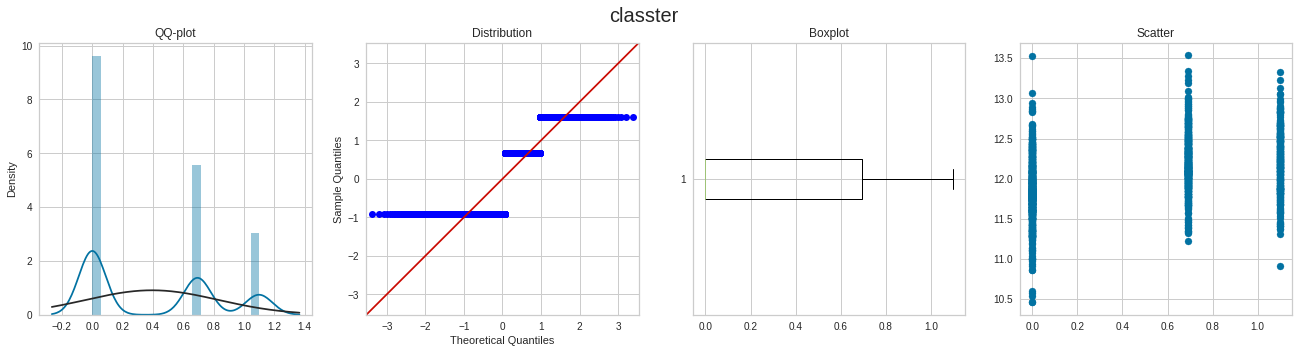

Lower Bound: -1.04, Upper Bound 1.733, Outliers Count: 0


In [53]:
for col in df[skew_features.columns].drop('SalePrice', axis=1):
    get_num_info(df[col], title=col, target=df['SalePrice'])
    detect_outliers(df[col])

### Анализ Категориальных переменных

In [ ]:
# df['OverallQual'] = df['OverallQual'].astype(str)
# df['Fireplaces'] = df['Fireplaces'].astype(str)

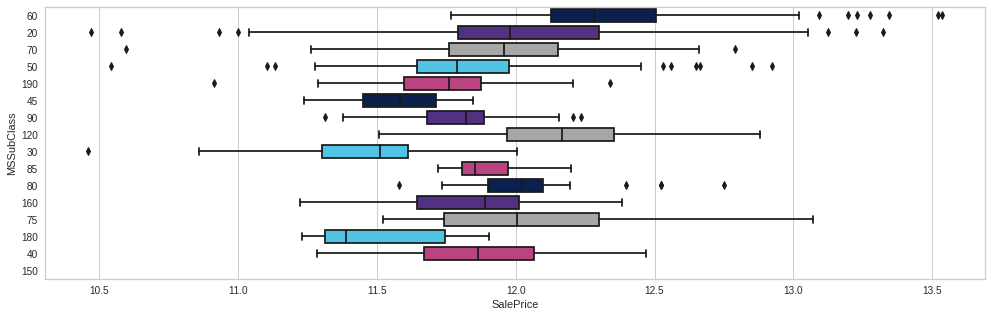

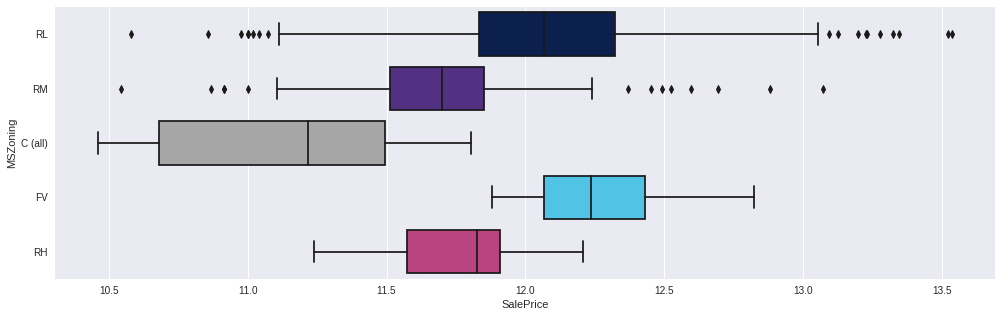

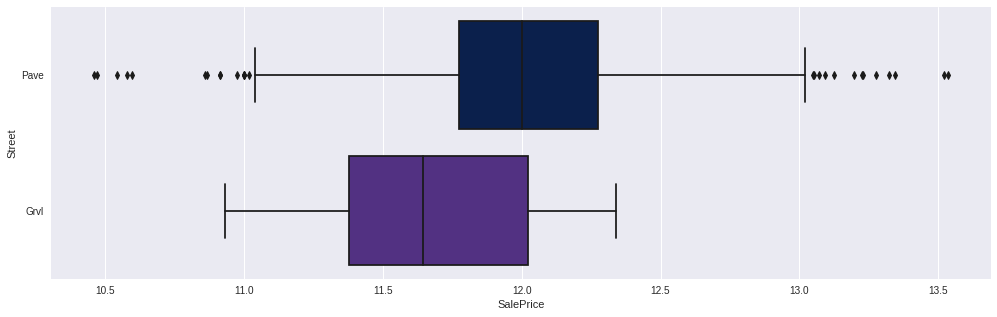

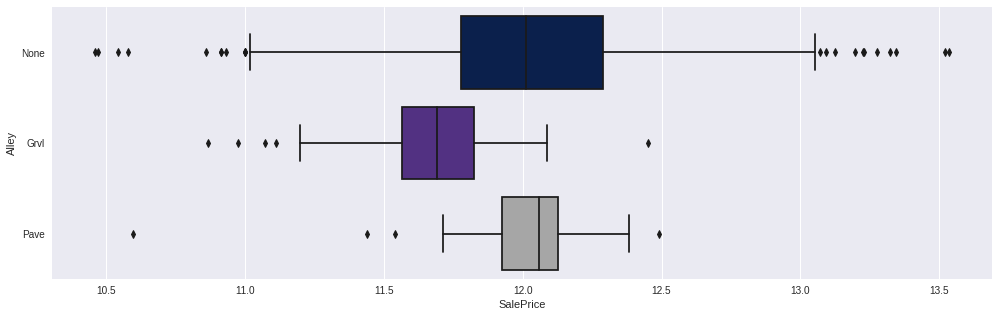

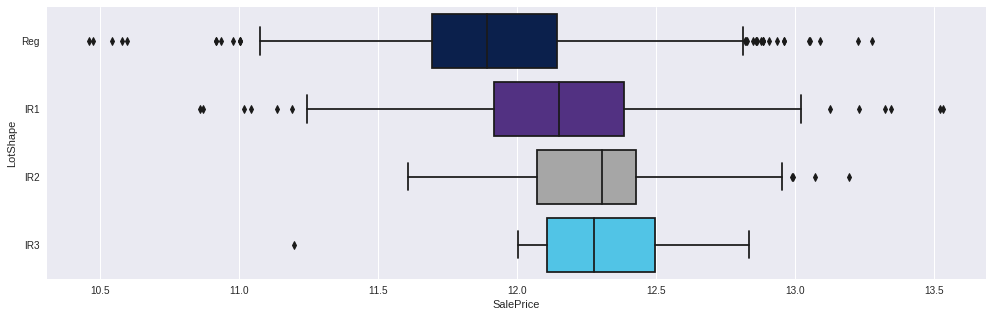

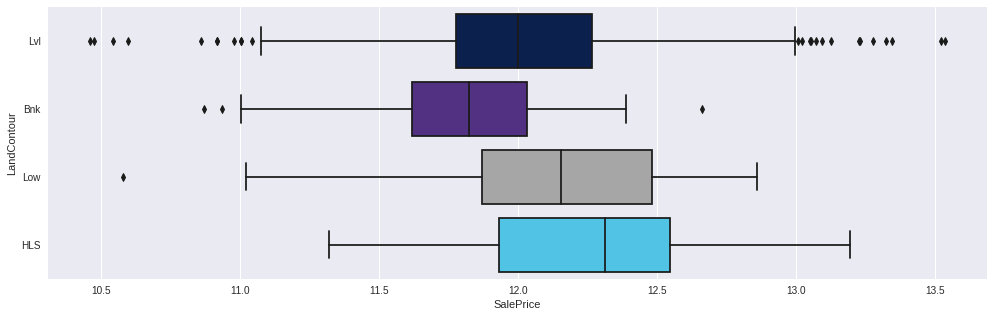

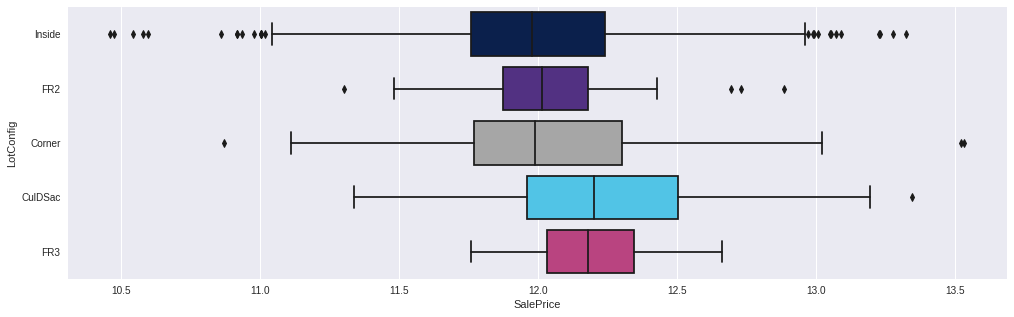

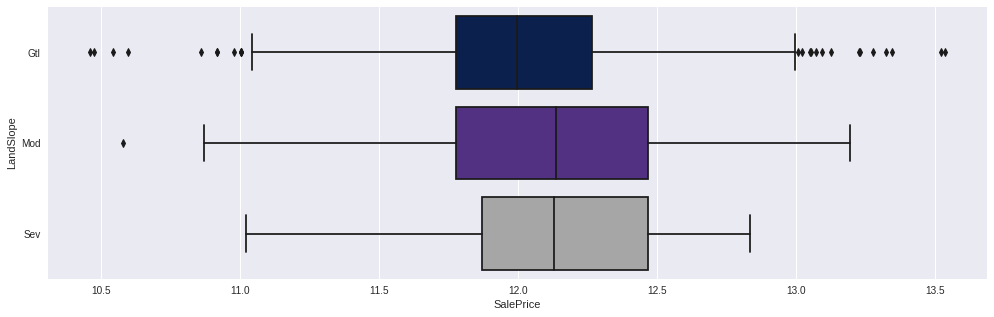

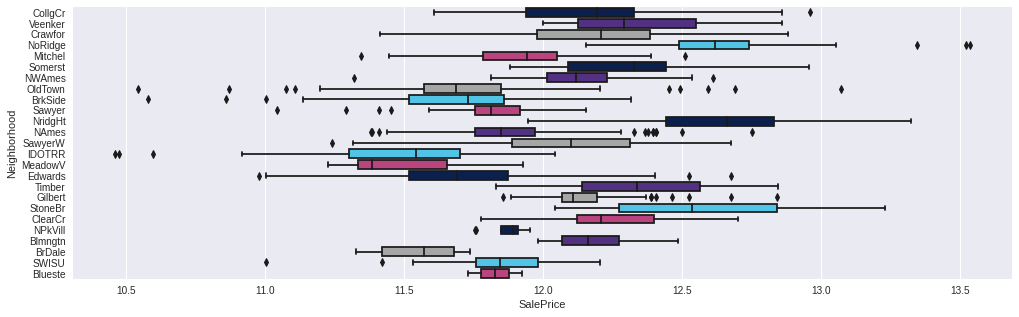

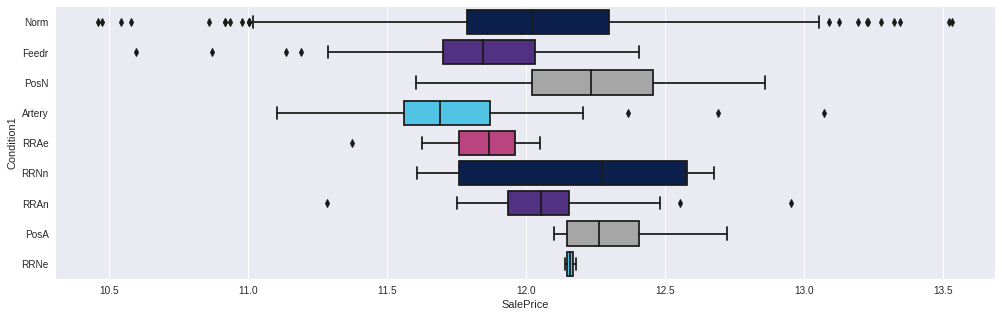

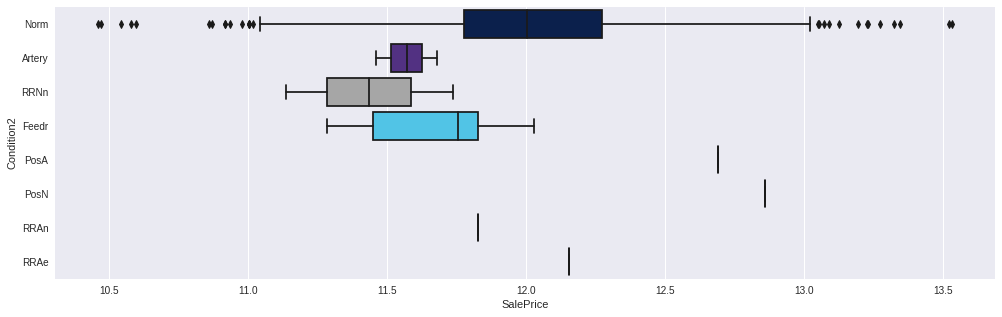

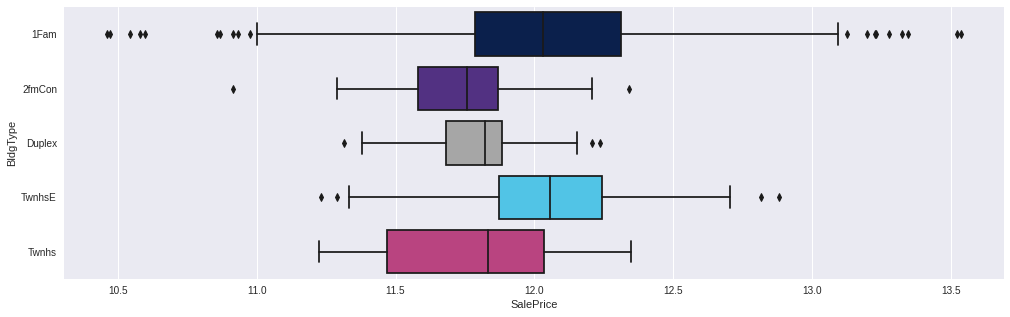

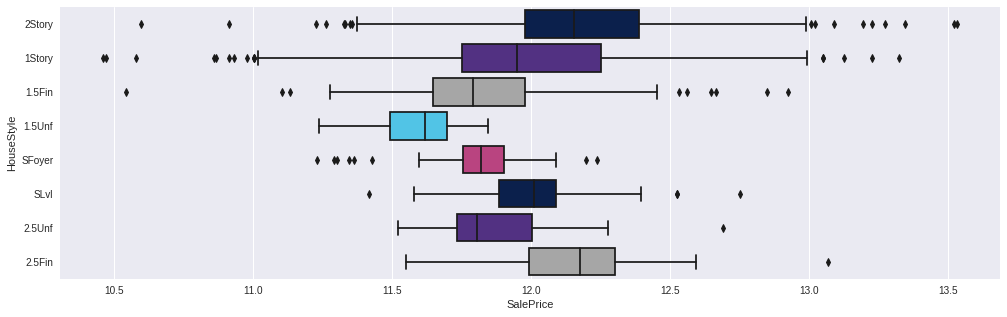

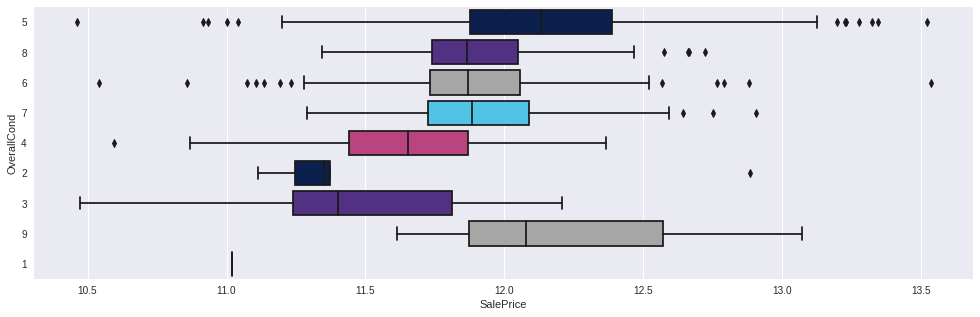

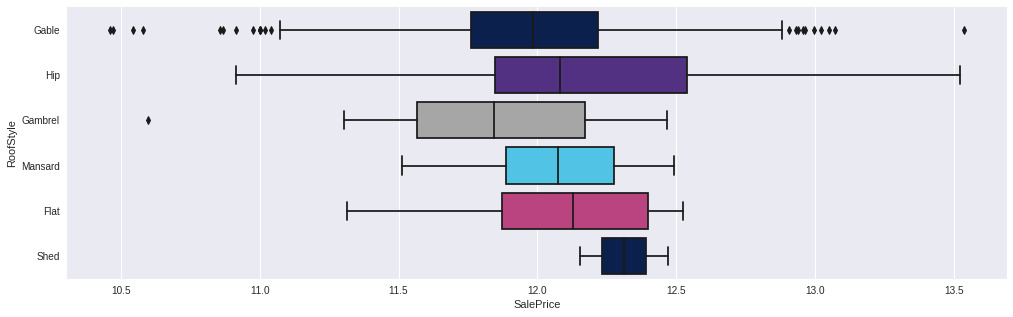

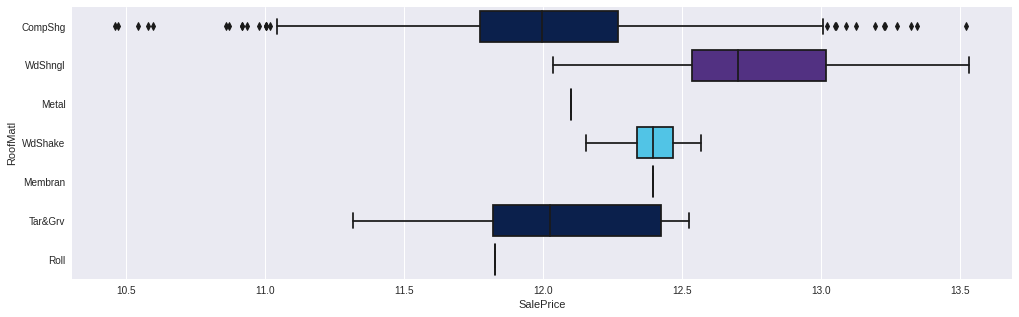

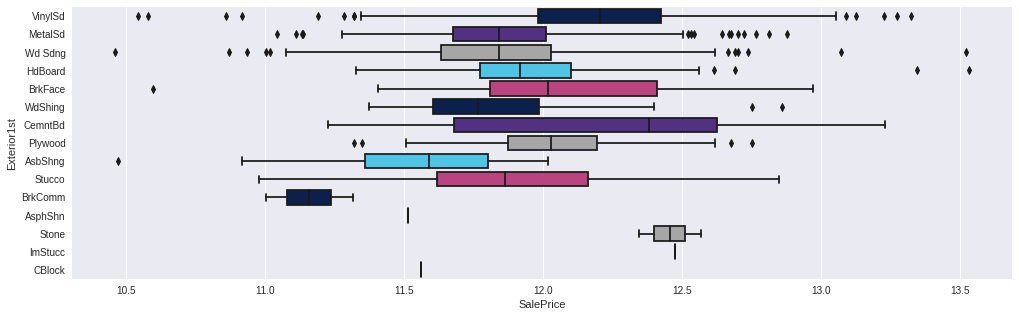

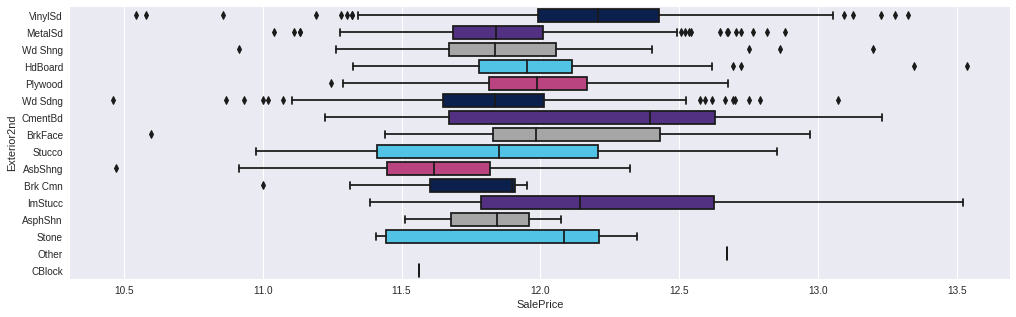

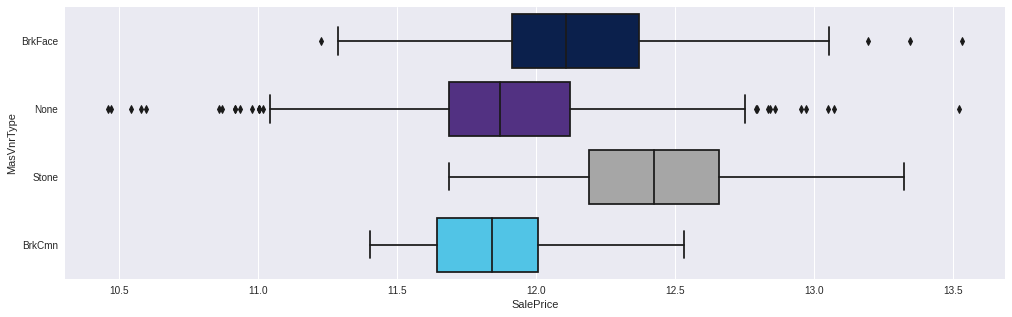

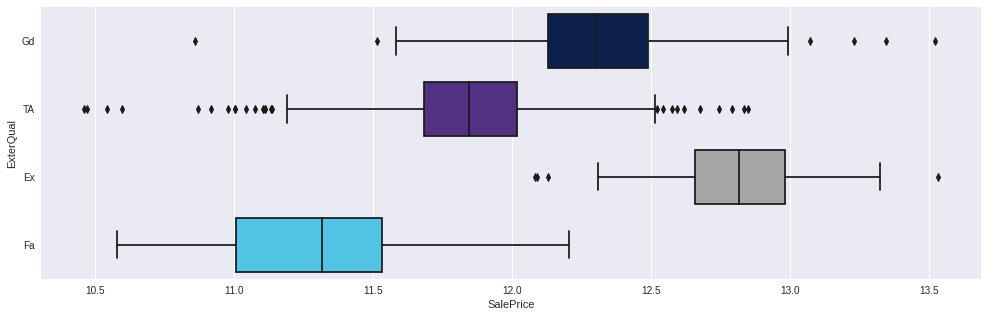

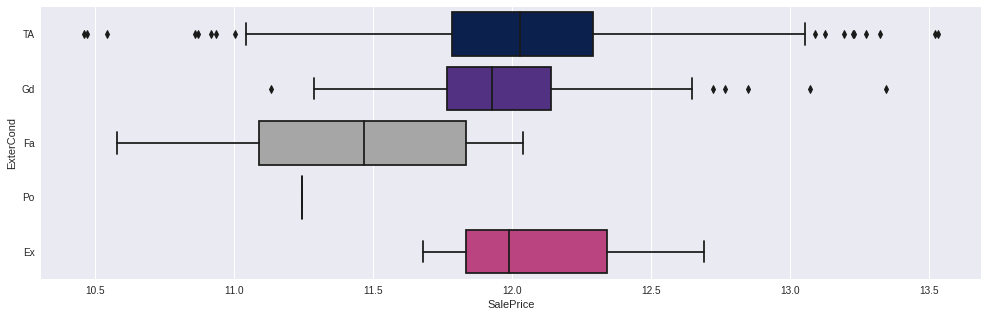

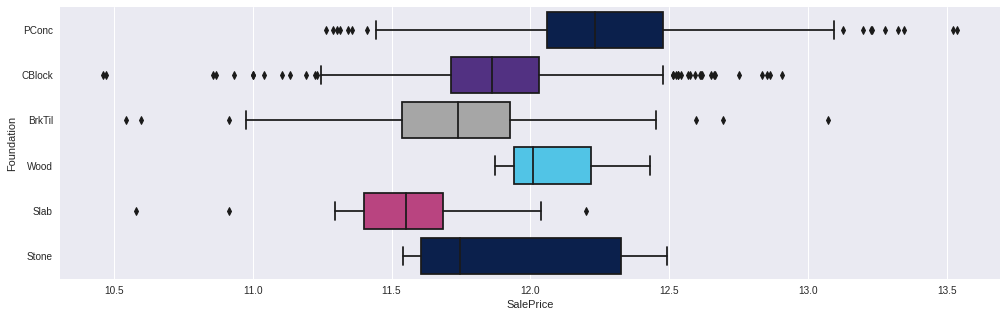

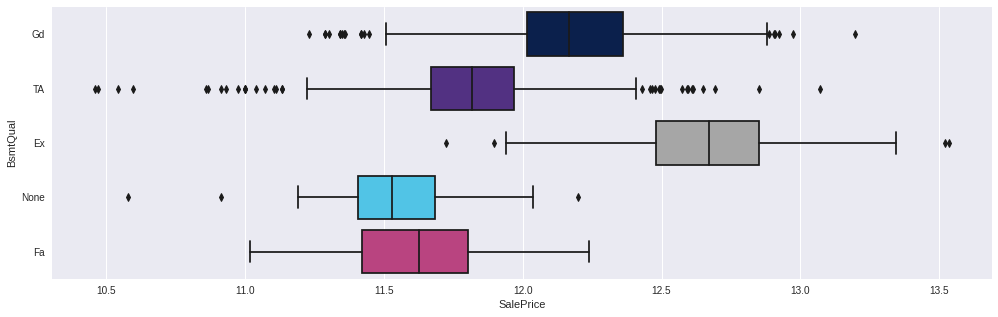

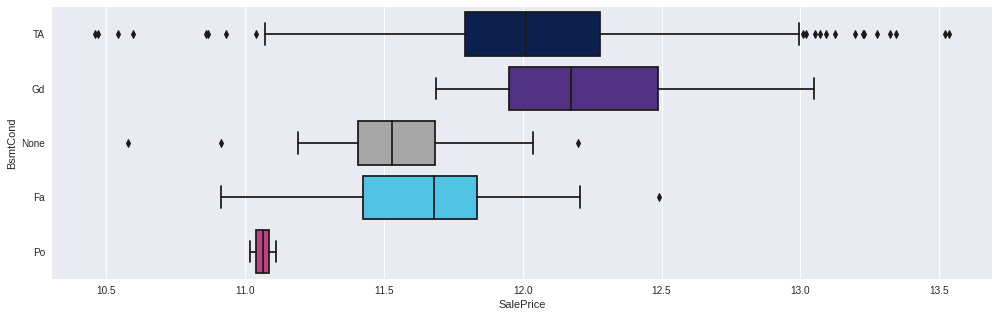

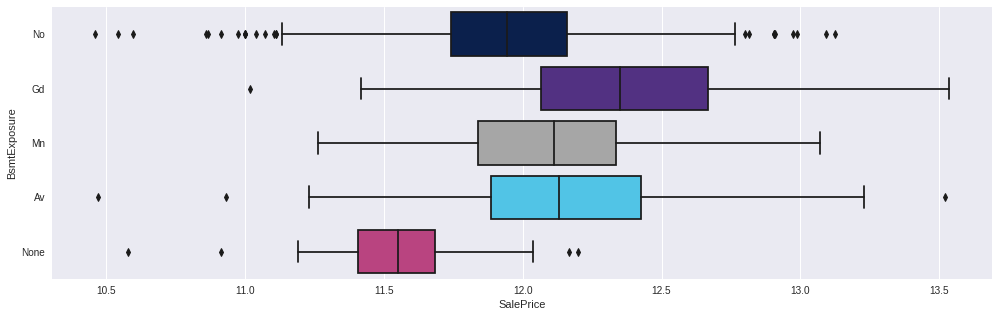

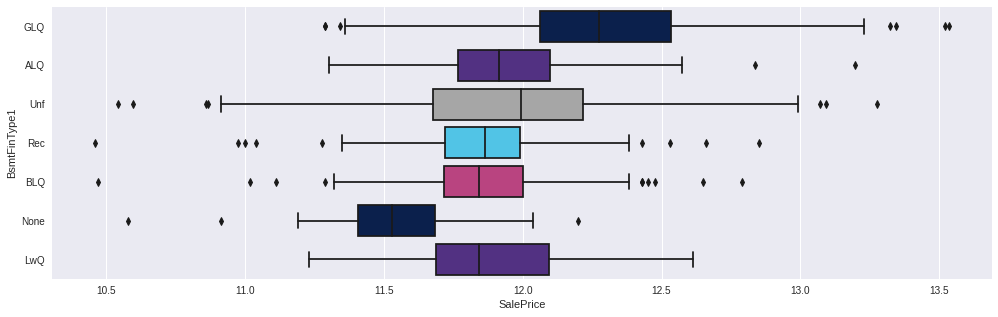

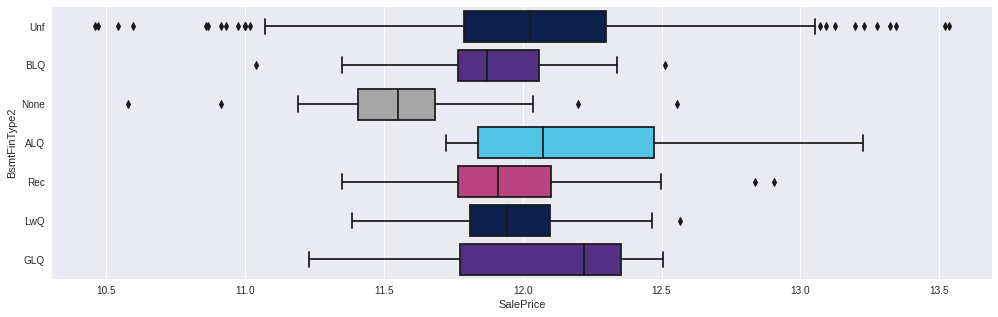

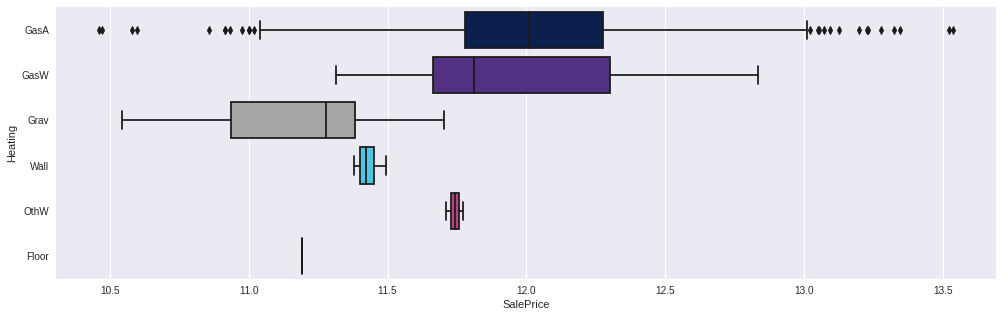

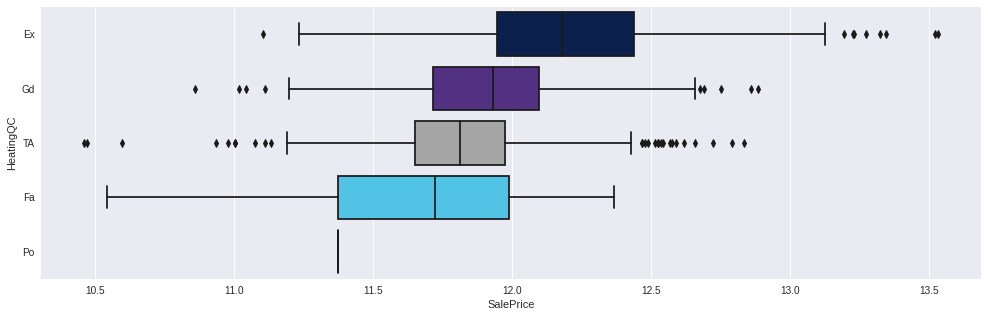

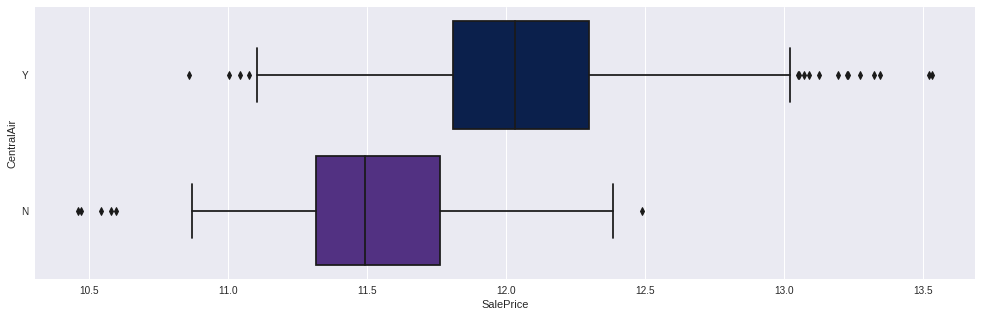

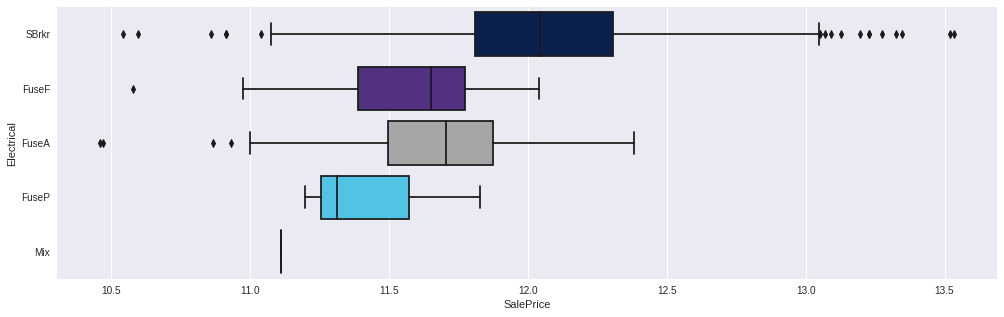

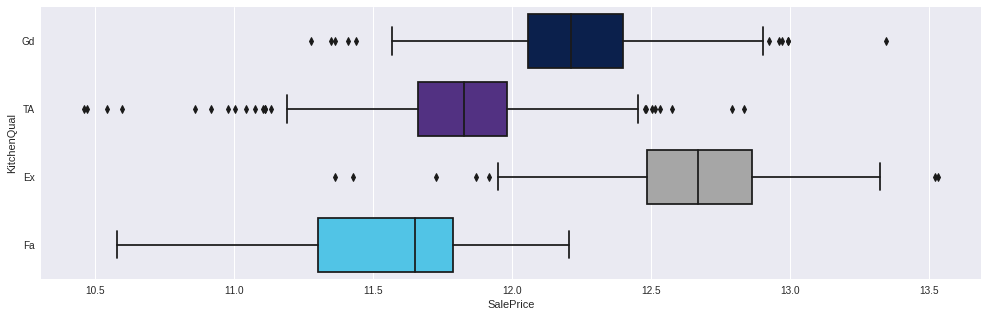

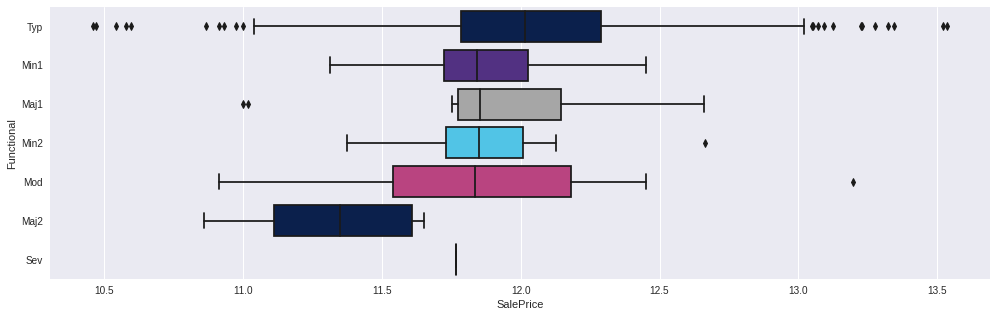

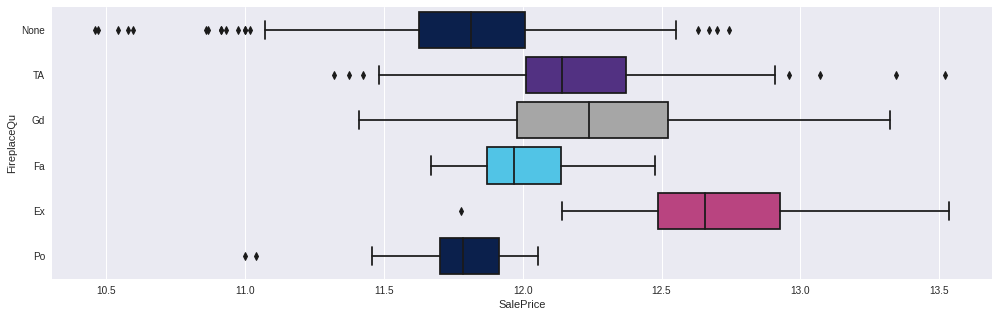

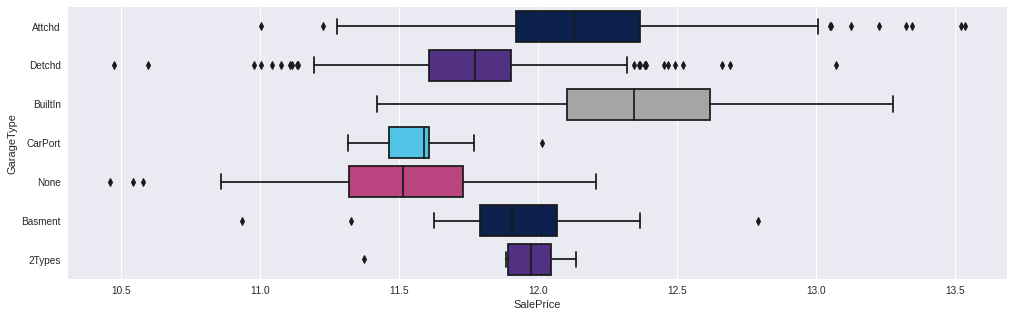

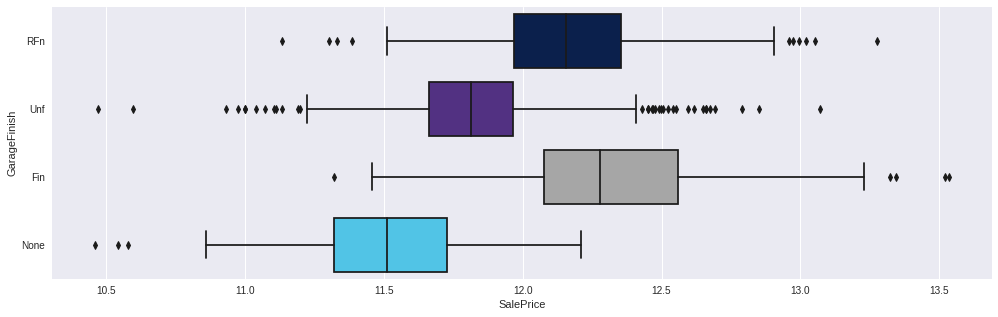

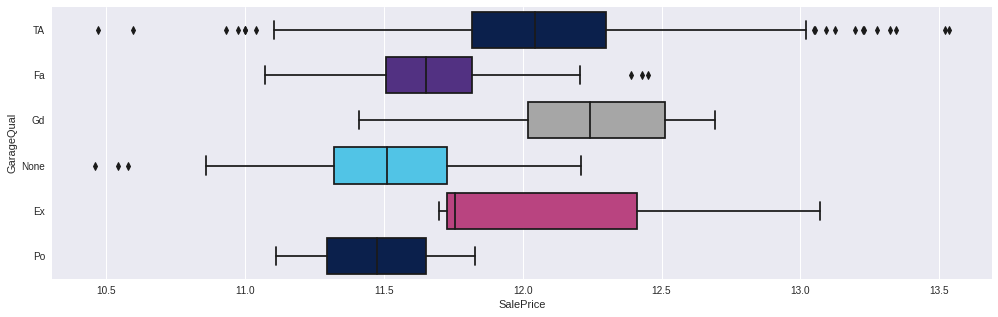

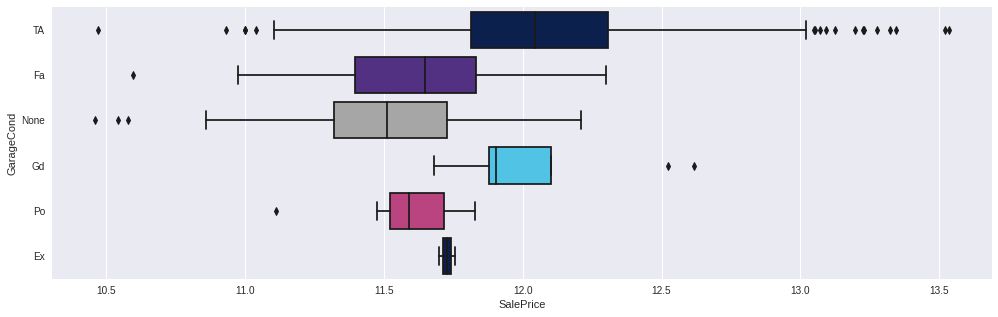

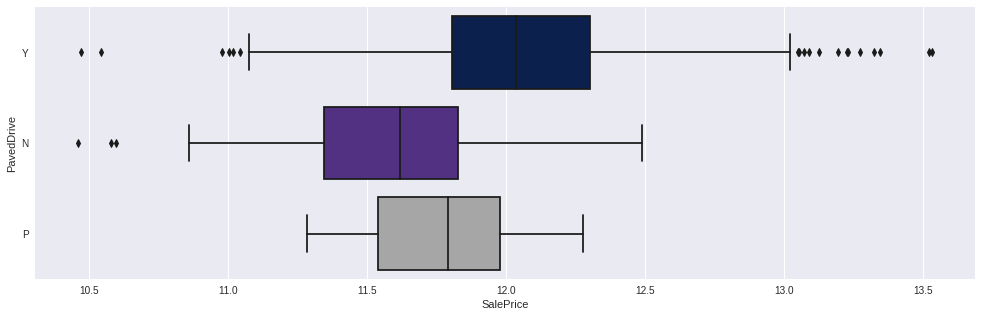

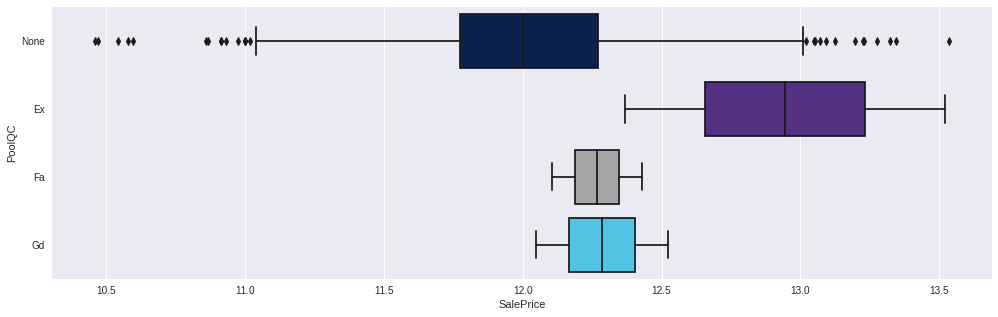

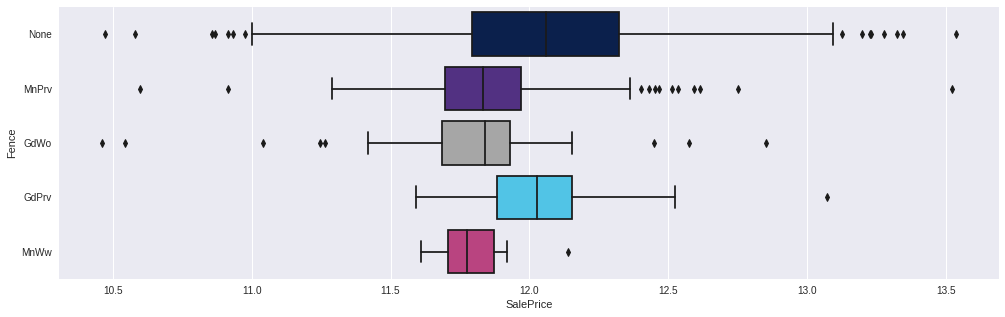

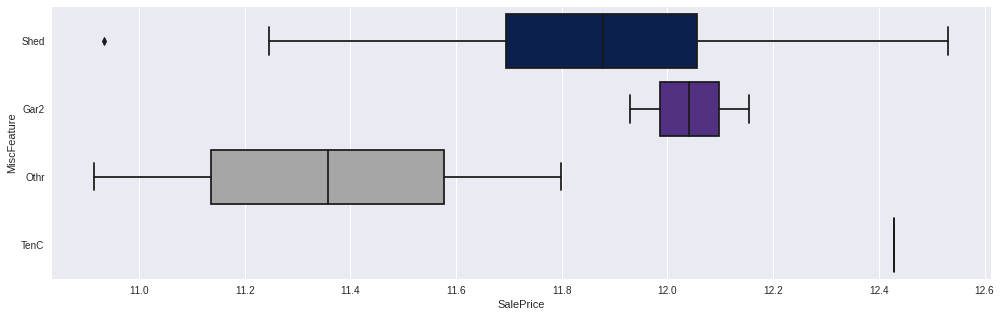

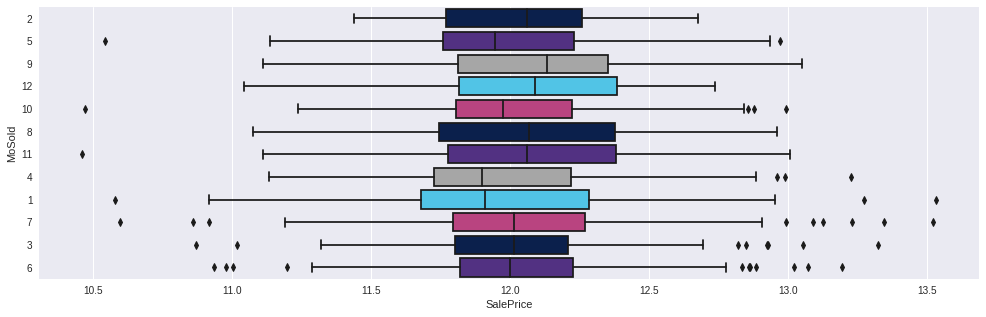

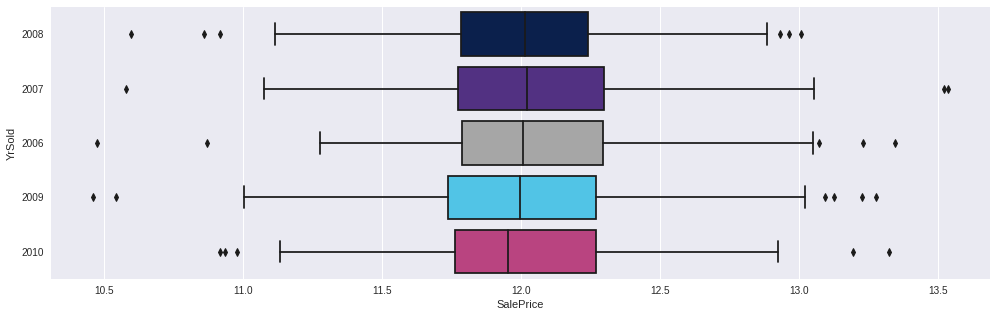

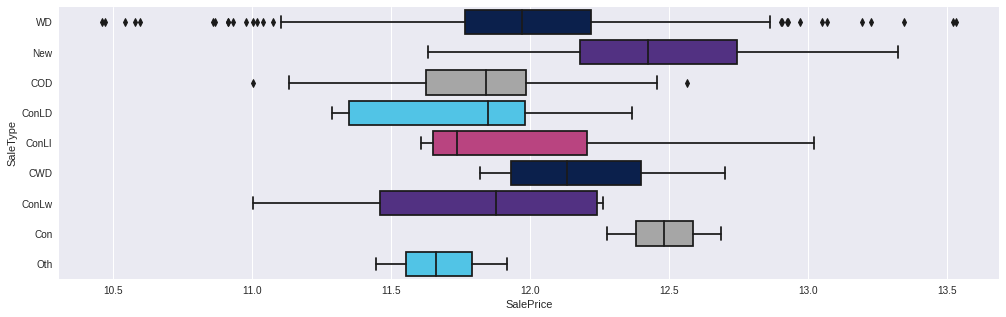

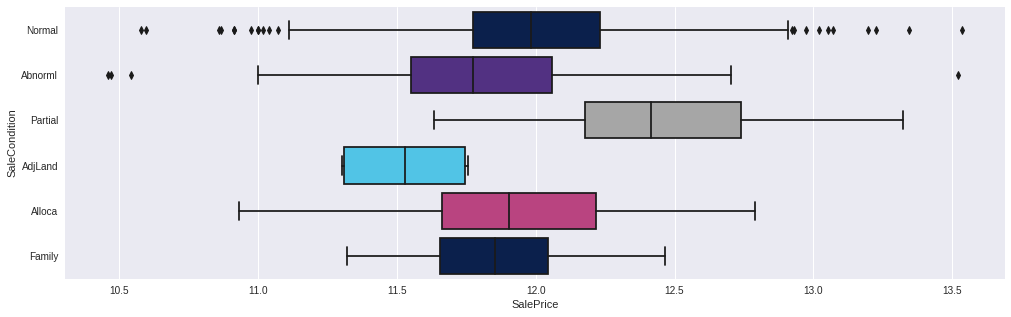

In [63]:
for col in df.select_dtypes(include='object'):
     get_boxplot(df, df['SalePrice'], df[col])

### Encoding

#### Target Encoding

In [ ]:
# saleprice = pd.read_csv('/home/mark/Documents/GitHub/ds_bootcamp/learning/00_Projects/Project_2/SalePrice.csv').drop('Id', axis=1, inplace=False)
# saleprice

In [48]:
encoder = TargetEncoder()

# for cat in cat_features:
#     full[cat] = encoder.fit_transform(full[cat], full['SalePrice'])

df[df.select_dtypes(include='object').columns] = encoder.fit_transform(df[df.select_dtypes(include='object').columns], df['SalePrice'])    

In [49]:
df

MSSubClass   MSZoning  LotFrontage   LotArea     Street      Alley  \
0      12.340823  12.079938     4.189655  9.042040  12.018896  12.030792   
1      12.054159  12.079938     4.394449  9.169623  12.018896  12.030792   
2      12.340823  12.079938     4.234107  9.328212  12.018896  12.030792   
3      11.895219  12.079938     4.110874  9.164401  12.018896  12.030792   
4      12.340823  12.079938     4.442651  9.565284  12.018896  12.030792   
...          ...        ...          ...       ...        ...        ...   
2914   11.782160  11.692758     3.091042  7.568896  12.018896  12.030792   
2915   11.782160  11.692758     3.091042  7.546974  12.018896  12.030792   
2916   12.054159  12.079938     5.081404  9.903538  12.018896  12.030792   
2917   11.870953  12.079938     4.143135  9.253591  12.018896  12.030792   
2918   12.340823  12.079938     4.317488  9.172431  12.018896  12.030792   

       LotShape  LandContour  LotConfig  LandSlope  Neighborhood  Condition1  \
0     11.915266    12.009006  11.996040  12.012498     12.181859   12.035233   
1     11.915266    12.009006  12.022518  12.012498     12.407394   11.812797   
2     12.186889    12.009006  11.996040  12.012498     12.181859   12.035233   
3     12.186889    12.009006  12.016079  12.012498     12.183672   12.035233   
4     12.186889    12.009006  12.022518  12.012498     12.660185   12.035233   
...         ...          ...        ...        ...           ...         ...   
2914  11.915266    12.009006  11.996040  12.012498     11.452653   12.035233   
2915  11.915266    12.009006  11.996040  12.012498     11.452653   12.035233   
2916  11.915266    12.009006  11.996040  12.012498     11.955635   12.035233   
2917  11.915266    12.009006  11.996040  12.012498     11.955635   12.035233   
2918  11.915266    12.009006  11.996040  12.095544     11.955635   12.035233   

      Condition2   BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0      12.016768  12.036046   12.164767    12.207921    12.151450   2.708050   
1      12.016768  12.036046   11.997938    11.962988    11.883037   3.737670   
2      12.016768  12.036046   12.164767    12.207921    12.151450   2.833213   
3      12.016768  12.036046   12.164767    12.207921    12.151450   4.634729   
4      12.016768  12.036046   12.164767    12.488847    12.151450   2.890372   
...          ...        ...         ...          ...          ...        ...   
2914   12.016768  11.749069   12.164767    11.541025    11.879147   3.871201   
2915   12.016768  12.101279   12.164767    11.541025    12.151450   3.871201   
2916   12.016768  12.036046   11.997938    11.780052    11.879147   4.060443   
2917   12.016768  12.036046   11.820769    11.780052    12.151450   3.258097   
2918   12.016768  12.036046   12.164767    12.207921    12.151450   3.218876   

      RoofStyle   RoofMatl  Exterior1st  Exterior2nd  MasVnrType  MasVnrArea  \
0     11.971553  12.013629    12.220491    12.219789   12.183083    5.283204   
1     11.971553  12.013629    11.861280    11.870369   11.883045    0.000000   
2     11.971553  12.013629    12.220491    12.219789   12.183083    5.093750   
3     11.971553  12.013629    11.815414    11.857657   11.883045    0.000000   
4     11.971553  12.013629    12.220491    12.219789   12.183083    5.860786   
...         ...        ...          ...          ...         ...         ...   
2914  11.971553  12.013629    12.208501    12.205432   11.883045    0.000000   
2915  11.971553  12.013629    12.208501    12.205432   11.883045    0.000000   
2916  11.971553  12.013629    12.220491    12.219789   11.883045    0.000000   
2917  11.971553  12.013629    11.939720    11.857657   11.883045    0.000000   
2918  11.971553  12.013629    11.939720    11.941719   12.183083    4.553877   

      ExterQual  ExterCond  Foundation   BsmtQual   BsmtCond  BsmtExposure  \
0     12.304205  12.038103   12.264226  12.171166  12.038352     11.941952   
1     11.826026  12.038103   11.855393  12.171166  12.

#### Label Encoding

In [ ]:
# cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#         'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#         'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
#         'YrSold', 'MoSold')

# for c in cols:
#     enc = LabelEncoder() 
#     enc.fit(list(df[c].values)) 
#     df[c] = enc.transform(list(df[c].values))

#### One Hot Encoding

In [160]:
df = pd.get_dummies(df)

## Modeling

### Pre Modelling

In [161]:
train = df[df['train'] > 0].drop(['SalePrice', 'train'], axis=1)
test = df[df['train'] == 0].drop(['SalePrice', 'train'], axis=1)

In [162]:
df.shape

(2917, 338)

In [163]:
df_train.shape[0], train.shape[0]

(1460, 1458)

In [164]:
df_test.shape[0], test.shape[0], df_ss.shape[0]

(1459, 1459, 1459)

In [165]:
y = df[df['train'] > 0]['SalePrice']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state= 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1020, 336), (438, 336), (1020,), (438,))

### Version 1. Classic. Linear, Ridge, Lasso, Enet, Krr

In [425]:
lr = LinearRegression()

lr.fit(X_train, y_train)

train_pre = lr.predict(X_train)
test_pre = lr.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.007203718553859278
test MSE: 0.008780279685748084


In [426]:
huber = HuberRegressor()

huber.fit(X_train, y_train)

train_pre = lr.predict(X_train)
test_pre = lr.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.007203718553859278
test MSE: 0.008780279685748084


In [427]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0005))
])

model_lasso.fit(X_train, y_train)

train_pre = model_lasso.predict(X_train)
test_pre = model_lasso.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.007662251516291006
test MSE: 0.009103325321542564


In [428]:
model_enet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.0089, l1_ratio=0.009000000000000001, random_state=3))
])

model_enet.fit(X_train, y_train)

train_pre = model_enet.predict(X_train)
test_pre = model_enet.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.007788444366118351
test MSE: 0.009183492328360946


In [429]:
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', KernelRidge(alpha=0.6,
                        kernel='polynomial',
                        degree=2,
                        coef0=2.5))
])

model_krr.fit(X_train, y_train)

train_pre = model_krr.predict(X_train)
test_pre = model_krr.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.005503322291080622
test MSE: 0.00844455657121133


### Version 2. Forest, Boosing, Stacking, blend

In [430]:
rfr = RandomForestRegressor(n_estimators=300, max_depth=10)
rfr.fit(X_train, y_train)

train_pre = rfr.predict(X_train)
test_pre = rfr.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.0024912149644540083
test MSE: 0.011798509862374672


In [431]:
gbr = GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=200)
gbr.fit(X_train, y_train)

train_pre = gbr.predict(X_train)
test_pre = gbr.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.00468342792243041
test MSE: 0.008632687251172692


In [432]:
model_xgbr = XGBRegressor(colsample_bytree=0.4, learning_rate=0.00898718134841855, max_depth=8, 
                             n_estimators=2200, reg_alpha=0.036142628805195254, reg_lambda=0.03188665185506858,
                             subsample=0.6, random_state =42)
model_xgbr.fit(X_train, y_train)

train_pre = model_xgbr.predict(X_train)
test_pre = model_xgbr.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 8.13737252233405e-05
test MSE: 0.007132605801397583


In [433]:
model_lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

model_lgbm.fit(X_train, y_train)

train_pre = model_lgbm.predict(X_train)
test_pre = model_lgbm.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
train MSE: 0.00595045865184562
test MSE: 0.008945598081223484


In [434]:
cat = CatBoostRegressor(depth=2, learning_rate = .1, iterations=200, silent = True, )

cat.fit(X_train, y_train)

train_pre = cat.predict(X_train)
test_pre = cat.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.005980521074677584
test MSE: 0.008748822504058446


In [435]:
stack = StackingRegressor(estimators = [('kNN', KNeighborsRegressor()), ('gbr', GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=200))])

stack.fit(X_train, y_train)

train_pre = stack.predict(X_train)
test_pre = stack.predict(X_test)

print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(test_pre, y_test))

train MSE: 0.0046152117812415325
test MSE: 0.008821372608036157


In [436]:
def blend(x):
    return (0.5 * model_lasso.predict(x) + 0.5 * model_xgbr.predict(x))
#     return (0.75 * rcv.predict(x)) + (0.25 * gbr.predict(x))

pred1 = blend(X_test)
print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(pred1, y_test))

train MSE: 0.0046152117812415325
test MSE: 0.007497508949707407


In [437]:
def blend_2(X):
    return ((0.1 * model_lasso.predict(X)) + \
            (0.15 * model_xgbr.predict(X)) + \
            (0.15 * gbr.predict(X)) + \
            (0.03 * cat.predict(X)) + \
            (0.02 * model_krr.predict(X)) + \
            (0.02 * model_enet.predict(X)) + \
            (0.03 * huber.predict(X)) + \
            (0.50 * stack.predict(np.array(X))))

pred1 = blend_2(X_test)
print("train MSE:", mean_squared_error(train_pre, y_train))
print("test MSE:", mean_squared_error(pred1, y_test))

train MSE: 0.0046152117812415325
test MSE: 0.007991700045575065









### Обучение на полной выборке

In [286]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0005))
])

model_lasso.fit(train, y)

train_pre = model_lasso.predict(train)

print("final MSE:", mean_squared_error(train_pre, y))

final MSE: 0.013522123283867633


In [287]:
model_enet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.0089, l1_ratio=0.009000000000000001, random_state=3))
])

model_enet.fit(train, y)

train_pre = model_enet.predict(train)

print("train MSE:", mean_squared_error(train_pre, y))

train MSE: 0.013736303620980701


In [288]:
gbr = GradientBoostingRegressor(max_depth=2, learning_rate = 0.1, n_estimators=200)
gbr.fit(X_train, y_train)

train_pre = gbr.predict(train)

print("train MSE:", mean_squared_error(train_pre, y))

train MSE: 0.008627803894184558


In [289]:
def blend(x):
    return (0.5 * model_lasso.predict(x) + 0.5 * model_xgbr.predict(x))
#     return (0.75 * rcv.predict(x)) + (0.25 * gbr.predict(x))

pred1 = blend(train)
print("train MSE:", mean_squared_error(pred1, y))

train MSE: 0.0061992386309129


### Try Optune

In [290]:
import optuna
import xgboost as xgb
from optuna.samplers import TPESampler

In [293]:
def objective(trial):
    X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.33)

    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 2, 15),
        'subsample': trial.suggest_discrete_uniform('subsample', 0.6, 1.0, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500, 50),
        'eta': trial.suggest_discrete_uniform('eta', 0.01, 0.1, 0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 5, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
#         'learning_rate': trial.suggest_discrete_uniform('leaning_rate', 0.01, 1, 0.01)
    }

    reg = xgb.XGBRegressor( **param_grid, silent=True)
    # TODO: PRUNING
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation-error')
    reg.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)], eval_metric='rmse',
            verbose=False)

#     return np.sqrt(-cross_val_score(reg, X_valid, y_valid, scoring='neg_mean_squared_error').mean())
    return mean_squared_error(y_valid, reg.predict(X_valid), squared=False)

In [294]:
train_time = 1 * 10 * 60 # h * m * s
study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
study.optimize(objective, timeout=train_time)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('\tValue: {}'.format(trial.value))
print('\tParams: ')
for key, value in trial.params.items():
    print('\t\t{}: {}'.format(key, value))

[I 2021-10-24 14:42:03,751] A new study created in memory with name: XGBRegressor


[14:42:03] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:05,521] Trial 0 finished with value: 0.20910143339709947 and parameters: {'max_depth': 8, 'subsample': 1.0, 'n_estimators': 1500, 'eta': 0.06999999999999999, 'reg_alpha': 36, 'reg_lambda': 52, 'min_child_weight': 5}. Best is trial 0 with value: 0.20910143339709947.


[14:42:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:06,214] Trial 1 finished with value: 0.2709505569059959 and parameters: {'max_depth': 9, 'subsample': 0.6, 'n_estimators': 400, 'eta': 0.03, 'reg_alpha': 50, 'reg_lambda': 37, 'min_child_weight': 2}. Best is trial 0 with value: 0.20910143339709947.


[14:42:06] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:08,554] Trial 2 finished with value: 0.15048897097280808 and parameters: {'max_depth': 13, 'subsample': 0.85, 'n_estimators': 1200, 'eta': 0.01, 'reg_alpha': 15, 'reg_lambda': 34, 'min_child_weight': 3}. Best is trial 2 with value: 0.15048897097280808.


[14:42:08] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:10,806] Trial 3 finished with value: 0.12173021778276646 and parameters: {'max_depth': 6, 'subsample': 0.75, 'n_estimators': 1500, 'eta': 0.05, 'reg_alpha': 3, 'reg_lambda': 7, 'min_child_weight': 11}. Best is trial 3 with value: 0.12173021778276646.


[14:42:10] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:12,300] Trial 4 finished with value: 0.1291134379311616 and parameters: {'max_depth': 9, 'subsample': 0.95, 'n_estimators': 650, 'eta': 0.09999999999999999, 'reg_alpha': 1, 'reg_lambda': 46, 'min_child_weight': 18}. Best is trial 3 with value: 0.12173021778276646.
[I 2021-10-24 14:42:12,514] Trial 5 finished with value: 0.1901083800244888 and parameters: {'max_depth': 6, 'subsample': 0.8, 'n_estimators': 150, 'eta': 0.05, 'reg_alpha': 22, 'reg_lambda': 67, 'min_child_weight': 18}. Best is trial 3 with value: 0.12173021778276646.


[14:42:12] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:12,697] Trial 6 finished with value: 0.19417384491660528 and parameters: {'max_depth': 13, 'subsample': 0.65, 'n_estimators': 100, 'eta': 0.09999999999999999, 'reg_alpha': 27, 'reg_lambda': 52, 'min_child_weight': 8}. Best is trial 3 with value: 0.12173021778276646.


[14:42:12] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:42:12] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:13,263] Trial 7 finished with value: 0.1887770083748994 and parameters: {'max_depth': 10, 'subsample': 0.9, 'n_estimators': 250, 'eta': 0.03, 'reg_alpha': 20, 'reg_lambda': 41, 'min_child_weight': 2}. Best is trial 3 with value: 0.12173021778276646.


[14:42:13] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:13,563] Trial 8 finished with value: 0.1913316173258427 and parameters: {'max_depth': 4, 'subsample': 0.85, 'n_estimators': 200, 'eta': 0.09, 'reg_alpha': 34, 'reg_lambda': 68, 'min_child_weight': 9}. Best is trial 3 with value: 0.12173021778276646.


[14:42:13] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:15,364] Trial 9 finished with value: 0.17412229986994587 and parameters: {'max_depth': 10, 'subsample': 0.8, 'n_estimators': 1450, 'eta': 0.08, 'reg_alpha': 23, 'reg_lambda': 84, 'min_child_weight': 6}. Best is trial 3 with value: 0.12173021778276646.


[14:42:15] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:16,482] Trial 10 finished with value: 0.12404269650757019 and parameters: {'max_depth': 2, 'subsample': 0.7, 'n_estimators': 950, 'eta': 0.05, 'reg_alpha': 2, 'reg_lambda': 12, 'min_child_weight': 13}. Best is trial 3 with value: 0.12173021778276646.


[14:42:16] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:17,627] Trial 11 finished with value: 0.10719299738998889 and parameters: {'max_depth': 2, 'subsample': 0.7, 'n_estimators': 1000, 'eta': 0.05, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:42:17] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:18,806] Trial 12 finished with value: 0.14395788173749866 and parameters: {'max_depth': 2, 'subsample': 0.7, 'n_estimators': 1100, 'eta': 0.060000000000000005, 'reg_alpha': 9, 'reg_lambda': 5, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:42:18] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:19,738] Trial 13 finished with value: 0.13250545460675253 and parameters: {'max_depth': 5, 'subsample': 0.7, 'n_estimators': 700, 'eta': 0.03, 'reg_alpha': 10, 'reg_lambda': 22, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:42:19] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:21,131] Trial 14 finished with value: 0.14186117814740223 and parameters: {'max_depth': 4, 'subsample': 0.75, 'n_estimators': 1250, 'eta': 0.04, 'reg_alpha': 7, 'reg_lambda': 22, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:42:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:22,026] Trial 15 finished with value: 0.16884142681686456 and parameters: {'max_depth': 6, 'subsample': 0.6, 'n_estimators': 850, 'eta': 0.06999999999999999, 'reg_alpha': 14, 'reg_lambda': 20, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:42:22] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:24,116] Trial 16 finished with value: 0.14077497788592322 and parameters: {'max_depth': 7, 'subsample': 0.75, 'n_estimators': 1350, 'eta': 0.01, 'reg_alpha': 4, 'reg_lambda': 99, 'min_child_weight': 16}. Best is trial 11 with value: 0.10719299738998889.


[14:42:24] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:25,212] Trial 17 finished with value: 0.17365200768330374 and parameters: {'max_depth': 15, 'subsample': 0.75, 'n_estimators': 1050, 'eta': 0.060000000000000005, 'reg_alpha': 16, 'reg_lambda': 7, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:42:25] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:25,866] Trial 18 finished with value: 0.19339284415860275 and parameters: {'max_depth': 3, 'subsample': 0.65, 'n_estimators': 550, 'eta': 0.04, 'reg_alpha': 30, 'reg_lambda': 30, 'min_child_weight': 8}. Best is trial 11 with value: 0.10719299738998889.


[14:42:25] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:26,787] Trial 19 finished with value: 0.21975013304870605 and parameters: {'max_depth': 4, 'subsample': 0.65, 'n_estimators': 900, 'eta': 0.06999999999999999, 'reg_alpha': 45, 'reg_lambda': 17, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:42:26] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:28,464] Trial 20 finished with value: 0.14079031050970675 and parameters: {'max_depth': 6, 'subsample': 0.85, 'n_estimators': 1300, 'eta': 0.02, 'reg_alpha': 7, 'reg_lambda': 28, 'min_child_weight': 16}. Best is trial 11 with value: 0.10719299738998889.


[14:42:28] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:29,635] Trial 21 finished with value: 0.1300222917989871 and parameters: {'max_depth': 2, 'subsample': 0.7, 'n_estimators': 1000, 'eta': 0.05, 'reg_alpha': 1, 'reg_lambda': 9, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:42:29] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:30,711] Trial 22 finished with value: 0.12202459927414532 and parameters: {'max_depth': 2, 'subsample': 0.75, 'n_estimators': 950, 'eta': 0.04, 'reg_alpha': 4, 'reg_lambda': 13, 'min_child_weight': 20}. Best is trial 11 with value: 0.10719299738998889.


[14:42:30] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:32,226] Trial 23 finished with value: 0.13573774710668365 and parameters: {'max_depth': 3, 'subsample': 0.75, 'n_estimators': 1150, 'eta': 0.04, 'reg_alpha': 10, 'reg_lambda': 14, 'min_child_weight': 19}. Best is trial 11 with value: 0.10719299738998889.


[14:42:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:33,086] Trial 24 finished with value: 0.13899323993948798 and parameters: {'max_depth': 3, 'subsample': 0.8, 'n_estimators': 650, 'eta': 0.060000000000000005, 'reg_alpha': 6, 'reg_lambda': 5, 'min_child_weight': 17}. Best is trial 11 with value: 0.10719299738998889.


[14:42:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:34,007] Trial 25 finished with value: 0.14024791124018232 and parameters: {'max_depth': 5, 'subsample': 0.75, 'n_estimators': 800, 'eta': 0.04, 'reg_alpha': 13, 'reg_lambda': 26, 'min_child_weight': 20}. Best is trial 11 with value: 0.10719299738998889.


[14:42:34] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:35,684] Trial 26 finished with value: 0.164611335284735 and parameters: {'max_depth': 7, 'subsample': 0.65, 'n_estimators': 1400, 'eta': 0.02, 'reg_alpha': 18, 'reg_lambda': 12, 'min_child_weight': 20}. Best is trial 11 with value: 0.10719299738998889.


[14:42:35] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:36,459] Trial 27 finished with value: 0.131603643287716 and parameters: {'max_depth': 5, 'subsample': 0.7, 'n_estimators': 500, 'eta': 0.05, 'reg_alpha': 4, 'reg_lambda': 64, 'min_child_weight': 6}. Best is trial 11 with value: 0.10719299738998889.


[14:42:36] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:37,510] Trial 28 finished with value: 0.15702858096905206 and parameters: {'max_depth': 2, 'subsample': 0.8, 'n_estimators': 1050, 'eta': 0.060000000000000005, 'reg_alpha': 11, 'reg_lambda': 17, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:42:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:39,249] Trial 29 finished with value: 0.19562413610176926 and parameters: {'max_depth': 8, 'subsample': 1.0, 'n_estimators': 1450, 'eta': 0.08, 'reg_alpha': 39, 'reg_lambda': 46, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:42:39] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:41,339] Trial 30 finished with value: 0.13617423726282069 and parameters: {'max_depth': 3, 'subsample': 0.9, 'n_estimators': 1500, 'eta': 0.02, 'reg_alpha': 5, 'reg_lambda': 25, 'min_child_weight': 8}. Best is trial 11 with value: 0.10719299738998889.


[14:42:41] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:43,063] Trial 31 finished with value: 0.1173299586468215 and parameters: {'max_depth': 2, 'subsample': 0.7, 'n_estimators': 950, 'eta': 0.05, 'reg_alpha': 1, 'reg_lambda': 14, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:42:43] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:44,513] Trial 32 finished with value: 0.12206293771825377 and parameters: {'max_depth': 4, 'subsample': 0.75, 'n_estimators': 750, 'eta': 0.04, 'reg_alpha': 1, 'reg_lambda': 12, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:42:44] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:45,874] Trial 33 finished with value: 0.1525323188127005 and parameters: {'max_depth': 2, 'subsample': 0.6, 'n_estimators': 950, 'eta': 0.05, 'reg_alpha': 7, 'reg_lambda': 33, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:42:45] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:48,120] Trial 34 finished with value: 0.11698696903443347 and parameters: {'max_depth': 3, 'subsample': 0.7, 'n_estimators': 1200, 'eta': 0.03, 'reg_alpha': 4, 'reg_lambda': 39, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:42:48] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:50,186] Trial 35 finished with value: 0.16779075007015684 and parameters: {'max_depth': 3, 'subsample': 0.65, 'n_estimators': 1200, 'eta': 0.03, 'reg_alpha': 13, 'reg_lambda': 39, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:42:50] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:52,280] Trial 36 finished with value: 0.11911962127921578 and parameters: {'max_depth': 5, 'subsample': 0.7, 'n_estimators': 1150, 'eta': 0.06999999999999999, 'reg_alpha': 1, 'reg_lambda': 62, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:42:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:54,356] Trial 37 finished with value: 0.12521922832929594 and parameters: {'max_depth': 4, 'subsample': 0.6, 'n_estimators': 1150, 'eta': 0.08, 'reg_alpha': 1, 'reg_lambda': 57, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:42:54] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:55,753] Trial 38 finished with value: 0.1435574918785659 and parameters: {'max_depth': 5, 'subsample': 0.7, 'n_estimators': 1300, 'eta': 0.06999999999999999, 'reg_alpha': 8, 'reg_lambda': 73, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:42:55] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:56,678] Trial 39 finished with value: 0.23931175386104941 and parameters: {'max_depth': 12, 'subsample': 0.65, 'n_estimators': 850, 'eta': 0.060000000000000005, 'reg_alpha': 50, 'reg_lambda': 60, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:42:56] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:42:58,085] Trial 40 finished with value: 0.1263383158056306 and parameters: {'max_depth': 3, 'subsample': 0.7, 'n_estimators': 1100, 'eta': 0.06999999999999999, 'reg_alpha': 4, 'reg_lambda': 78, 'min_child_weight': 17}. Best is trial 11 with value: 0.10719299738998889.


[14:42:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:00,537] Trial 41 finished with value: 0.14080670570065357 and parameters: {'max_depth': 6, 'subsample': 0.7, 'n_estimators': 1250, 'eta': 0.05, 'reg_alpha': 2, 'reg_lambda': 46, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:43:00] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:02,016] Trial 42 finished with value: 0.14448197812473296 and parameters: {'max_depth': 4, 'subsample': 0.65, 'n_estimators': 1050, 'eta': 0.09, 'reg_alpha': 4, 'reg_lambda': 52, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:02] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:03,712] Trial 43 finished with value: 0.14928389147553783 and parameters: {'max_depth': 7, 'subsample': 0.7, 'n_estimators': 1200, 'eta': 0.03, 'reg_alpha': 12, 'reg_lambda': 57, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:43:03] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:05,211] Trial 44 finished with value: 0.1405796303004092 and parameters: {'max_depth': 9, 'subsample': 0.75, 'n_estimators': 1350, 'eta': 0.05, 'reg_alpha': 9, 'reg_lambda': 33, 'min_child_weight': 9}. Best is trial 11 with value: 0.10719299738998889.


[14:43:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:06,994] Trial 45 finished with value: 0.14563000225823144 and parameters: {'max_depth': 5, 'subsample': 0.8, 'n_estimators': 1500, 'eta': 0.060000000000000005, 'reg_alpha': 16, 'reg_lambda': 85, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:07] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:08,079] Trial 46 finished with value: 0.18685695559407578 and parameters: {'max_depth': 3, 'subsample': 0.7, 'n_estimators': 1000, 'eta': 0.03, 'reg_alpha': 26, 'reg_lambda': 19, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:43:08] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:10,150] Trial 47 finished with value: 0.12758488705217938 and parameters: {'max_depth': 10, 'subsample': 0.65, 'n_estimators': 1150, 'eta': 0.09, 'reg_alpha': 3, 'reg_lambda': 43, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:10] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:11,196] Trial 48 finished with value: 0.1363582003896877 and parameters: {'max_depth': 4, 'subsample': 0.75, 'n_estimators': 850, 'eta': 0.06999999999999999, 'reg_alpha': 6, 'reg_lambda': 7, 'min_child_weight': 9}. Best is trial 11 with value: 0.10719299738998889.


[14:43:11] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:11,588] Trial 49 finished with value: 0.1801623927492533 and parameters: {'max_depth': 2, 'subsample': 0.7, 'n_estimators': 300, 'eta': 0.04, 'reg_alpha': 29, 'reg_lambda': 52, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:43:11] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:13,295] Trial 50 finished with value: 0.16575545848543483 and parameters: {'max_depth': 7, 'subsample': 0.6, 'n_estimators': 1400, 'eta': 0.05, 'reg_alpha': 22, 'reg_lambda': 36, 'min_child_weight': 16}. Best is trial 11 with value: 0.10719299738998889.


[14:43:13] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:14,404] Trial 51 finished with value: 0.13440095208775393 and parameters: {'max_depth': 2, 'subsample': 0.75, 'n_estimators': 950, 'eta': 0.04, 'reg_alpha': 5, 'reg_lambda': 10, 'min_child_weight': 18}. Best is trial 11 with value: 0.10719299738998889.


[14:43:14] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:15,528] Trial 52 finished with value: 0.1249482940424075 and parameters: {'max_depth': 2, 'subsample': 0.75, 'n_estimators': 900, 'eta': 0.04, 'reg_alpha': 3, 'reg_lambda': 15, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:43:15] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:17,595] Trial 53 finished with value: 0.12481548505077893 and parameters: {'max_depth': 3, 'subsample': 0.7, 'n_estimators': 1100, 'eta': 0.05, 'reg_alpha': 1, 'reg_lambda': 22, 'min_child_weight': 3}. Best is trial 11 with value: 0.10719299738998889.


[14:43:17] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:19,354] Trial 54 finished with value: 0.1328345125153256 and parameters: {'max_depth': 6, 'subsample': 0.85, 'n_estimators': 1000, 'eta': 0.03, 'reg_alpha': 8, 'reg_lambda': 10, 'min_child_weight': 7}. Best is trial 11 with value: 0.10719299738998889.


[14:43:19] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:21,324] Trial 55 finished with value: 0.11858854990157217 and parameters: {'max_depth': 2, 'subsample': 0.8, 'n_estimators': 750, 'eta': 0.060000000000000005, 'reg_alpha': 3, 'reg_lambda': 6, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:43:21] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:22,194] Trial 56 finished with value: 0.1316118785666708 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 750, 'eta': 0.060000000000000005, 'reg_alpha': 6, 'reg_lambda': 5, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:22] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:23,122] Trial 57 finished with value: 0.1254624801366301 and parameters: {'max_depth': 3, 'subsample': 0.8, 'n_estimators': 700, 'eta': 0.08, 'reg_alpha': 3, 'reg_lambda': 18, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:43:23] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:23,762] Trial 58 finished with value: 0.14705680218348924 and parameters: {'max_depth': 2, 'subsample': 0.9, 'n_estimators': 550, 'eta': 0.060000000000000005, 'reg_alpha': 10, 'reg_lambda': 8, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:43:23] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:25,840] Trial 59 finished with value: 0.12863489617817864 and parameters: {'max_depth': 5, 'subsample': 0.85, 'n_estimators': 1250, 'eta': 0.01, 'reg_alpha': 1, 'reg_lambda': 70, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:25] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:27,365] Trial 60 finished with value: 0.16048911958269116 and parameters: {'max_depth': 3, 'subsample': 0.95, 'n_estimators': 900, 'eta': 0.06999999999999999, 'reg_alpha': 34, 'reg_lambda': 24, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:43:27] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:28,558] Trial 61 finished with value: 0.14385493148838505 and parameters: {'max_depth': 2, 'subsample': 0.75, 'n_estimators': 800, 'eta': 0.05, 'reg_alpha': 5, 'reg_lambda': 12, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:43:28] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:30,085] Trial 62 finished with value: 0.12581272542412272 and parameters: {'max_depth': 2, 'subsample': 0.75, 'n_estimators': 1050, 'eta': 0.04, 'reg_alpha': 3, 'reg_lambda': 15, 'min_child_weight': 9}. Best is trial 11 with value: 0.10719299738998889.


[14:43:30] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:31,124] Trial 63 finished with value: 0.16243486205758287 and parameters: {'max_depth': 3, 'subsample': 0.7, 'n_estimators': 950, 'eta': 0.060000000000000005, 'reg_alpha': 8, 'reg_lambda': 5, 'min_child_weight': 19}. Best is trial 11 with value: 0.10719299738998889.


[14:43:31] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:32,225] Trial 64 finished with value: 0.13196301346006872 and parameters: {'max_depth': 2, 'subsample': 0.75, 'n_estimators': 1000, 'eta': 0.05, 'reg_alpha': 5, 'reg_lambda': 14, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:43:32] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:33,308] Trial 65 finished with value: 0.11488340955385568 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 650, 'eta': 0.03, 'reg_alpha': 2, 'reg_lambda': 28, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:33] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:34,342] Trial 66 finished with value: 0.11454029734920033 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 650, 'eta': 0.02, 'reg_alpha': 2, 'reg_lambda': 21, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:34] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:35,254] Trial 67 finished with value: 0.12129344281824145 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 600, 'eta': 0.02, 'reg_alpha': 2, 'reg_lambda': 22, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:35] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:35,954] Trial 68 finished with value: 0.15306093918379363 and parameters: {'max_depth': 5, 'subsample': 0.85, 'n_estimators': 450, 'eta': 0.02, 'reg_alpha': 7, 'reg_lambda': 27, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:35] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:37,049] Trial 69 finished with value: 0.1479271017401845 and parameters: {'max_depth': 15, 'subsample': 0.8, 'n_estimators': 650, 'eta': 0.01, 'reg_alpha': 2, 'reg_lambda': 31, 'min_child_weight': 8}. Best is trial 11 with value: 0.10719299738998889.


[14:43:37] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:38,048] Trial 70 finished with value: 0.14112315436987474 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 700, 'eta': 0.03, 'reg_alpha': 6, 'reg_lambda': 29, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:43:38] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:39,050] Trial 71 finished with value: 0.12871731046521565 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 550, 'eta': 0.02, 'reg_alpha': 2, 'reg_lambda': 21, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:39] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:39,877] Trial 72 finished with value: 0.13446471035279012 and parameters: {'max_depth': 3, 'subsample': 0.85, 'n_estimators': 600, 'eta': 0.02, 'reg_alpha': 1, 'reg_lambda': 37, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:39] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:41,060] Trial 73 finished with value: 0.12866686582774317 and parameters: {'max_depth': 4, 'subsample': 0.8, 'n_estimators': 750, 'eta': 0.02, 'reg_alpha': 3, 'reg_lambda': 24, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:43:41] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:41,889] Trial 74 finished with value: 0.1663850588495429 and parameters: {'max_depth': 3, 'subsample': 0.85, 'n_estimators': 600, 'eta': 0.01, 'reg_alpha': 5, 'reg_lambda': 49, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:41] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:42,464] Trial 75 finished with value: 0.13382042002263486 and parameters: {'max_depth': 5, 'subsample': 0.8, 'n_estimators': 350, 'eta': 0.03, 'reg_alpha': 3, 'reg_lambda': 17, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:43:42] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:43,150] Trial 76 finished with value: 0.1293008469401875 and parameters: {'max_depth': 4, 'subsample': 0.65, 'n_estimators': 450, 'eta': 0.02, 'reg_alpha': 1, 'reg_lambda': 41, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:43] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:44,204] Trial 77 finished with value: 0.19611467174475758 and parameters: {'max_depth': 3, 'subsample': 0.85, 'n_estimators': 600, 'eta': 0.01, 'reg_alpha': 11, 'reg_lambda': 64, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:43:44] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:45,012] Trial 78 finished with value: 0.2146379566689924 and parameters: {'max_depth': 2, 'subsample': 0.8, 'n_estimators': 650, 'eta': 0.02, 'reg_alpha': 42, 'reg_lambda': 20, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:43:45] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:46,135] Trial 79 finished with value: 0.14386958814360637 and parameters: {'max_depth': 5, 'subsample': 0.7, 'n_estimators': 800, 'eta': 0.03, 'reg_alpha': 9, 'reg_lambda': 10, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:46] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:46,839] Trial 80 finished with value: 0.16789145476600878 and parameters: {'max_depth': 4, 'subsample': 0.75, 'n_estimators': 500, 'eta': 0.06999999999999999, 'reg_alpha': 19, 'reg_lambda': 26, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:43:46] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:47,953] Trial 81 finished with value: 0.11164729823977981 and parameters: {'max_depth': 6, 'subsample': 0.7, 'n_estimators': 650, 'eta': 0.060000000000000005, 'reg_alpha': 4, 'reg_lambda': 7, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:47] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:49,027] Trial 82 finished with value: 0.1326819934014117 and parameters: {'max_depth': 6, 'subsample': 0.7, 'n_estimators': 650, 'eta': 0.060000000000000005, 'reg_alpha': 4, 'reg_lambda': 9, 'min_child_weight': 12}. Best is trial 11 with value: 0.10719299738998889.


[14:43:49] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:51,251] Trial 83 finished with value: 0.11679120736365059 and parameters: {'max_depth': 14, 'subsample': 0.65, 'n_estimators': 750, 'eta': 0.06999999999999999, 'reg_alpha': 2, 'reg_lambda': 7, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:51] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:52,178] Trial 84 finished with value: 0.14974486509287693 and parameters: {'max_depth': 3, 'subsample': 0.65, 'n_estimators': 700, 'eta': 0.06999999999999999, 'reg_alpha': 7, 'reg_lambda': 8, 'min_child_weight': 9}. Best is trial 11 with value: 0.10719299738998889.


[14:43:52] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:53,375] Trial 85 finished with value: 0.14175341165507502 and parameters: {'max_depth': 8, 'subsample': 0.65, 'n_estimators': 800, 'eta': 0.06999999999999999, 'reg_alpha': 5, 'reg_lambda': 12, 'min_child_weight': 11}. Best is trial 11 with value: 0.10719299738998889.


[14:43:53] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:55,604] Trial 86 finished with value: 0.11779315759490726 and parameters: {'max_depth': 9, 'subsample': 0.65, 'n_estimators': 750, 'eta': 0.08, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:43:55] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:56,712] Trial 87 finished with value: 0.11391751773610811 and parameters: {'max_depth': 14, 'subsample': 0.65, 'n_estimators': 750, 'eta': 0.08, 'reg_alpha': 4, 'reg_lambda': 6, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:43:56] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:58,248] Trial 88 finished with value: 0.13126930205453033 and parameters: {'max_depth': 13, 'subsample': 0.6, 'n_estimators': 850, 'eta': 0.08, 'reg_alpha': 4, 'reg_lambda': 14, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:43:58] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:43:59,287] Trial 89 finished with value: 0.13400484850391123 and parameters: {'max_depth': 14, 'subsample': 0.65, 'n_estimators': 800, 'eta': 0.09, 'reg_alpha': 6, 'reg_lambda': 17, 'min_child_weight': 16}. Best is trial 11 with value: 0.10719299738998889.


[14:43:59] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:00,089] Trial 90 finished with value: 0.13904472415091904 and parameters: {'max_depth': 14, 'subsample': 0.6, 'n_estimators': 700, 'eta': 0.08, 'reg_alpha': 8, 'reg_lambda': 7, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:44:00] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:01,679] Trial 91 finished with value: 0.1234773834039782 and parameters: {'max_depth': 11, 'subsample': 0.65, 'n_estimators': 750, 'eta': 0.09999999999999999, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:44:01] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:03,691] Trial 92 finished with value: 0.13017121197963763 and parameters: {'max_depth': 14, 'subsample': 0.65, 'n_estimators': 900, 'eta': 0.08, 'reg_alpha': 2, 'reg_lambda': 10, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:44:03] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:05,003] Trial 93 finished with value: 0.1304264951188948 and parameters: {'max_depth': 13, 'subsample': 0.7, 'n_estimators': 750, 'eta': 0.08, 'reg_alpha': 3, 'reg_lambda': 12, 'min_child_weight': 14}. Best is trial 11 with value: 0.10719299738998889.


[14:44:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:06,227] Trial 94 finished with value: 0.14337239919457137 and parameters: {'max_depth': 12, 'subsample': 0.65, 'n_estimators': 850, 'eta': 0.09, 'reg_alpha': 4, 'reg_lambda': 7, 'min_child_weight': 13}. Best is trial 11 with value: 0.10719299738998889.


[14:44:06] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:07,206] Trial 95 finished with value: 0.13714622409524638 and parameters: {'max_depth': 8, 'subsample': 0.65, 'n_estimators': 650, 'eta': 0.060000000000000005, 'reg_alpha': 6, 'reg_lambda': 5, 'min_child_weight': 15}. Best is trial 11 with value: 0.10719299738998889.


[14:44:07] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:08,088] Trial 96 finished with value: 0.14062315135254028 and parameters: {'max_depth': 12, 'subsample': 0.6, 'n_estimators': 700, 'eta': 0.06999999999999999, 'reg_alpha': 7, 'reg_lambda': 16, 'min_child_weight': 16}. Best is trial 11 with value: 0.10719299738998889.


[14:44:08] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-10-24 14:44:09,722] Trial 97 finished with value: 0.130740167138799 and parameters: {'max_depth': 9, 'subsample': 0.7, 'n_estimators': 750, 'eta': 0.060000000000000005, 'reg_alpha': 2, 'reg_lambda': 8, 'min_child_weight': 10}. Best is trial 11 with value: 0.10719299738998889.


[14:44:09] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

In [ ]:
xgb_params = trial.params
# xgb_params['eta'] = 0.01
xgb_params['tree_method'] = 'gpu_hist'

n_splits = 10
test_preds = None
kf_rmse = []

for fold, (train_idx, valid_idx) in enumerate(KFold(n_splits=n_splits, shuffle=True).split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse', verbose=False)
       
    valid_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, valid_pred, squared=False)
    print(f'Fold {fold+1}/{n_splits} RMSE: {rmse:.4f}')
    kf_rmse.append(rmse)
    
    if test_preds is None:
        test_preds = model.predict(test)
    else:
        test_preds += model.predict(test)

test_preds /= n_splits
print(f'Average KFold RMSE: {np.mean(np.array(kf_rmse)):.5f}')

## Sumbit

In [ ]:
sub = pd.DataFrame()
sub['Id'] = range(1461, 2920)
final_test_pre = blend_2(test)
normal_prices_arr = np.expm1(final_test_pre)
sub['SalePrice'] = normal_prices_arr.tolist()

Id      SalePrice
1     1461  127101.179688
2     1462   71709.828125
3     1463  129451.281250
4     1464  204913.796875
5     1465   98173.062500
...    ...            ...
1455  2915  108408.171875
1456  2916   96971.664062
1457  2917  144654.812500
1458  2918  135637.687500
1459  2919  212124.546875

[1459 rows x 2 columns]

In [ ]:
sub.to_csv('submission.csv', header=True, index=False)

In [ ]:
#!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m ""

Successfully submitted to House Prices - Advanced Regression Techniques



  0%|          | 0.00/22.5k [00:00<?, ?B/s]
100%|##########| 22.5k/22.5k [00:03<00:00, 5.88kB/s]
